시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [1]:
!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:22])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   ECLO    39609 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 no

In [2]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월',\n       '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간',\n       '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', 'ECLO', '연', '월', '일', '시간', '도시',\n       '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

트레인 테스트에 cctv정보추가

In [3]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])
child_df

,시설종류,대상시설명,소재지도로명주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자,도시,구,동,번지
0,초등학교,남도초등학교,대구광역시 남구 현충동길 74(대명동),35.845027,128.581402,대구광역시,남부경찰서,Y,7.0,6~8,2020-03-23,대구광역시,남구,대명동,1709
1,초등학교,영선초등학교,대구광역시 남구 영선길96(이천동),35.852901,128.596014,대구광역시,남부경찰서,Y,8.0,6~10,2020-03-23,대구광역시,남구,이천동,477
2,초등학교,성명초등학교,대구광역시 남구 성당로 30길 55(대명동),35.845152,128.570825,대구광역시,남부경찰서,Y,14.0,8~12,2020-03-23,대구광역시,남구,대명동,3050
3,초등학교,남덕초등학교,대구광역시 남구 앞산순환로 93길 33,35.833042,128.573949,대구광역시,남부경찰서,Y,6.0,6~8,2020-03-23,대구광역시,남구,대명동,531-1
4,초등학교,대명초등학교,대구광역시 남구 대명로 110,35.838869,128.568889,대구광역시,남부경찰서,Y,5.0,6~10,2020-03-23,대구광역시,남구,대명동,960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,어린이집,남산교회어린이집,대구광역시 중구 관덕정길 16,35.865040,128.590565,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~10,2019-06-01,대구광역시,중구,남산동,941-1
636,초등학교,대구초등학교,대구광역시 중구 명륜로23길 80,35.864037,128.595370,대구광역시 중구청,대구광역시 중부경찰서,Y,12.0,3~12,2019-06-01,대구광역시,중구,봉산동,57
637,어린이집,대구삼성어린이집,대구광역시 중구 달구벌대로 2016-40,35.864469,128.584301,대구광역시 중구청,대구광역시 중부경찰서,Y,2.0,7~8,2019-06-01,대구광역시,중구,남산동,153-2
638,어린이집,동화나라어린이집,대구광역시 중구 남산로3안길 20,35.860371,128.577492,대구광역시 중구청,대구광역시 중부경찰서,Y,5.0,6~8,2019-06-01,대구광역시,중구,남산동,2623-6


In [ ]:
print(child_df['CCTV설치대수'].unique()) #4는 주차카메라
print(child_df['동'].unique())
print(train_df['동'].unique())

[ 7.  8. 14.  6.  5.  9. 10.  4.  2.  3.  1.  0. 11. nan 12.]
['대명동' '이천동' '봉덕동' '가창면' '구지면' '옥포면' '논공읍' '화원읍' '다사읍' '하빈면' '유가읍' '현풍면'
 nan '태전동' '구암동' '복현동' '관음동' '읍내동' '산격동' '국우동' '침산동' '매천동' '동천동' '사수동'
 '동변동' '서변동' '학정동' '대현동' '검단동' '노원동1가' '도남동' '고성동2가' '칠성동2가' '조야동' '팔달동'
 '고성동1가' '내당동' '중리동' '원대동1가' '비산동' '평리동' '이현동' '수성동4가' '노변동' '황금동' '만촌동'
 '범어동' '수성동1가' '두산동' '신매동' '파동' '상동' '매호동' '욱수동' '지산동' '중동' '시지동' '범물동'
 '수성동3가' '사월동' '수성동2가' '수창동' '남산동' '서문로1가' '삼덕동3가' '동인동4가' '봉산동' '대신동'
 '삼덕동2가' '남일동' '덕산동' '동산동']
['대신동' '감삼동' '두산동' '복현동' '신암동' '지산동' '상인동' '태전동' '지묘동' '평리동' '신기동' '상리동'
 '월성동' '황금동' '구암동' '신천동' '만촌동' '남산동' '비산동' '침산동' '두류동' '신매동' '대곡동' '유가읍'
 '논공읍' '율하동' '시지동' '봉무동' '다사읍' '동산동' '이현동' '이천동' '수성동4가' '노원동3가' '서변동'
 '관음동' '학정동' '파동' '상동' '이곡동' '효목동' '읍내동' '남성로' '죽전동' '대명동' '동천동' '지저동'
 '사수동' '덕산동' '본리동' '용계동' '범어동' '신당동' '성당동' '용산동' '태평로3가' '도학동' '욱수동' '불로동'
 '칠성동1가' '장기동' '매호동' '대천동' '삼덕동1가' '수성동2가' '팔달동' '삼덕동' '진천동' '수성동3가' '가창면'
 '방촌동' '산격동' '월암동' '현풍읍' '구지면' '매천동' '송

In [4]:
child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서

#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())

(39609, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64
(10963, 15)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
dtype: int64


In [5]:
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])
cctv_df

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,도시,구,동,번지
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,903-13
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,853-8
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,866-46
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,2680-17
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,1616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,671-8
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,812
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-8
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,270-3


In [ ]:
print(cctv_df['단속구분'].unique()) #4는 주차카메라
print(cctv_df['동'].unique())
print(train_df['동'].unique())

[ 4  1  2 99]
['대명동' '봉덕동' '이천동' '하빈면' '다사읍' '옥포읍' '구지면' '가창면' '현풍읍' '화원읍' '논공읍' '유가읍'
 '하리' '정대리' '용계리' '유가면' '현풍면' '남리' '세천리' '매곡리' '삼산리' '북리' '호림동' '용산동'
 '월암동' '호산동' '본리동' '월성동' '송현동' '이곡동' '장기동' '대천동' '신당동' '대곡동' '진천동' '상인동'
 '감삼동' '본동' '성당동' '유천동' '죽전동' '두류동' '도원동' '파호동' '남산동' '동산동' '공평동' '삼덕동2가'
 '봉산동' '동성로3가' '남일동' '문화동' '수동' '동인동3가' '대신동' '대봉동' '수창동' '대안동' '삼덕동3가'
 '동인동4가' '종로2가' '태평로1가' '삼덕동1가' '동성로2가' nan '종로1가' '북성로1가' '북성로2가' '서야동'
 '인교동' '계산동2가' '금호동' '미곡동' '팔달동' '범어동' '신천동' '지저동' '황금동' '봉무동' '내당동' '비산동'
 '수성동1가' '고모동' '만촌동' '도학동' '국우동' '태전동' '대현동' '파동' '범물동' '평광동' '도동' '덕곡동'
 '중동' '갈산동' '두산동' '율하동' '신평동' '평리동' '중리동' '침산동' '복현동' '산격동' '신매동' '조야동'
 '율암동' '서변동' '신서동' '입석동' '효목동' '평리4동' '매천동' '읍내동' '사복동' '신암동' '구암동' '지묘동'
 '노원동3가' '삼덕동' '신암4동' '백안동' '군위읍' '이현동' '신암1동' '비산2.3동' '지산동' '두류1.2동'
 '칠성동1가' '침산2동' '비산4동' '가천동' '상동' '시지동' '서성로2가' '태평로3가' '칠성동2가' '방촌동'
 '관음동' '부계면' '신기동' '수성동4가' '효령면' '노원동1가' '동인동2가' '노원동2가' '각산동' '신안동' '학정동'
 '괴전동' '동천동' '의흥면' '우보면' '미대동' '소보면' '상리동

In [81]:
cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())

(39609, 17)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64
(10963, 16)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
dtype: int64


In [126]:
#동마다 CCTV 제한속도 평균
speed_df = {'동':[],
             '평균속도':[]}
speed_df = pd.DataFrame(speed_df)
speed_list = []
for i in cctv_df['동'].unique() :
  temp_list = []
  count_list = []
  temp = 0
  sum_list = []
  for j in [30,50,60,70,80,100] :
    temp_list.append(len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)])*j)
    temp += (len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)]))
    #print(temp_list)
    #print(temp)

  sum_list = sum(temp_list)
  if temp != 0 :
    speed_list.append(sum_list/temp)
  else:
    speed_list.append(0)
  #print(speed_list)
#len(speed_list)

speed_df['동'] = cctv_df['동'].unique()
speed_df['평균속도'] = speed_list
speed_df = speed_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, speed_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, speed_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


[90]
3
[90, 800]
19
[90, 800, 180]
22
[90, 800, 180, 0]
22
[90, 800, 180, 0, 0]
22
[90, 800, 180, 0, 0, 0]
22
[48.63636363636363]
[150]
5
[150, 100]
7
[150, 100, 60]
8
[150, 100, 60, 0]
8
[150, 100, 60, 0, 0]
8
[150, 100, 60, 0, 0, 0]
8
[48.63636363636363, 38.75]
[60]
2
[60, 100]
4
[60, 100, 0]
4
[60, 100, 0, 0]
4
[60, 100, 0, 0, 0]
4
[60, 100, 0, 0, 0, 0]
4
[48.63636363636363, 38.75, 40.0]
[180]
6
[180, 0]
6
[180, 0, 120]
8
[180, 0, 120, 280]
12
[180, 0, 120, 280, 0]
12
[180, 0, 120, 280, 0, 0]
12
[48.63636363636363, 38.75, 40.0, 48.333333333333336]
[660]
22
[660, 500]
32
[660, 500, 720]
44
[660, 500, 720, 140]
46
[660, 500, 720, 140, 0]
46
[660, 500, 720, 140, 0, 0]
46
[48.63636363636363, 38.75, 40.0, 48.333333333333336, 43.91304347826087]
[270]
9
[270, 300]
15
[270, 300, 240]
19
[270, 300, 240, 0]
19
[270, 300, 240, 0, 160]
21
[270, 300, 240, 0, 160, 100]
22
[48.63636363636363, 38.75, 40.0, 48.333333333333336, 43.91304347826087, 48.63636363636363]
[240]
8
[240, 0]
8
[240, 0, 240]
12

In [ ]:
print(train_df['기상상태'].unique())
print(train_df['노면상태'].unique())
print(train_df['사고유형'].unique())
print(train_df['ECLO'].unique())
print(train_df['도로형태1'].unique())
print(train_df['도로형태2'].unique())
print(train_df['기상상태'].value_counts())
print(train_df['노면상태'].value_counts())
print(train_df['사고유형'].value_counts())
print(train_df['도로형태1'].value_counts())
print(train_df['도로형태2'].value_counts())

['맑음' '흐림' '기타' '비' '안개' '눈']
['건조' '젖음/습기' '서리/결빙' '기타' '침수' '적설']
['차대사람' '차대차' '차량단독']
[ 5  3  6 18  9  8 15  2  1  7  4 12 13 10 11 16 40 22 21 17 25 14 20 27
 19 24 26 23 28 31 30 47 36 33 34 35 37 65 56 32 57 45 52 74 39 66]
['단일로' '교차로' '기타' '주차장' '미분류']
['기타' '교차로안' '터널' '지하차도(도로)내' '교량' '교차로횡단보도내' '주차장' '교차로부근' '고가도로위' '미분류']
맑음    36184
비      2635
흐림      738
기타       34
안개       10
눈         8
Name: 기상상태, dtype: int64
건조       36423
젖음/습기     3104
기타          51
서리/결빙       25
침수           3
적설           3
Name: 노면상태, dtype: int64
차대차     31785
차대사람     6833
차량단독      991
Name: 사고유형, dtype: int64
단일로    20233
교차로    17153
기타      1986
주차장      236
미분류        1
Name: 도로형태1, dtype: int64
기타           21478
교차로안          9931
교차로부근         5746
교차로횡단보도내      1474
지하차도(도로)내      309
주차장            236
교량             232
고가도로위          138
터널              64
미분류              1
Name: 도로형태2, dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [128]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

In [ ]:
train_df[train_df['동'] == '내당동']['도로형태1'].value_counts()
train_df[train_df['동'] == '다사읍']['도로형태1'].value_counts()


#내당동 관음동 신매동 파동 노원동3가 단일로, 율하동, 다사읍 교차로

교차로    395
단일로    299
기타      81
주차장     16
미분류      1
Name: 도로형태1, dtype: int64

In [129]:
#만총동만 test로 미분류 임

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

In [ ]:
train_df[(train_df['동'] == '다사읍') & (train_df['도로형태1'] == '단일로')]['도로형태2'].value_counts()

기타       293
교량         4
고가도로위      1
터널         1
Name: 도로형태2, dtype: int64

In [130]:
train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

추가 EDA

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           39609 non-null  object 
 1   요일           39609 non-null  object 
 2   기상상태         39609 non-null  object 
 3   노면상태         39609 non-null  object 
 4   사고유형         39609 non-null  object 
 5   ECLO         39609 non-null  int64  
 6   연            39609 non-null  int64  
 7   월            39609 non-null  int64  
 8   일            39609 non-null  int64  
 9   시간           39609 non-null  int64  
 10  도시           39609 non-null  object 
 11  구            39609 non-null  object 
 12  동            39609 non-null  object 
 13  도로형태1        39609 non-null  object 
 14  도로형태2        39609 non-null  object 
 15  어린이CCTV설치대수  39609 non-null  float64
 16  CCTV개수       39609 non-null  float64
dtypes: float64(2), int64(5), object(10)
memory usage: 6.4+ MB


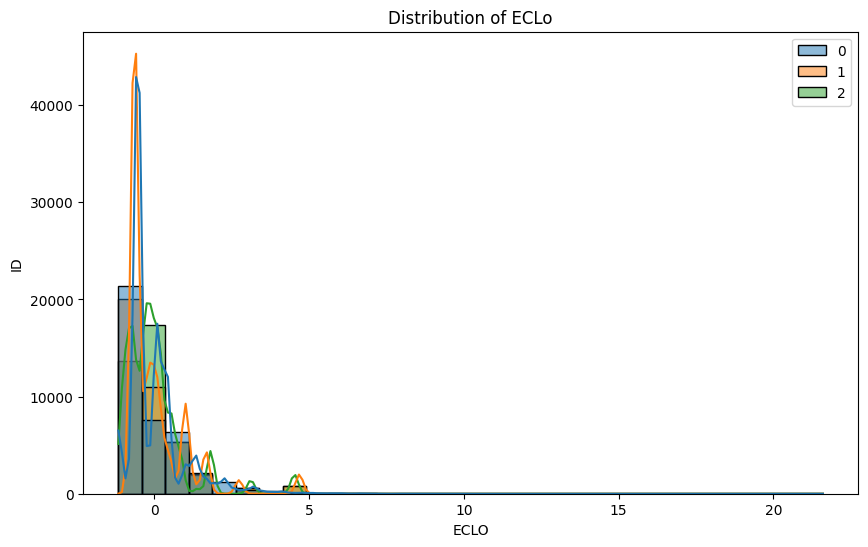

In [ ]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_std, bins=30, kde=True)
plt.title('Distribution of ECLo')
plt.xlabel('ECLO')
plt.ylabel('ID')
plt.show()

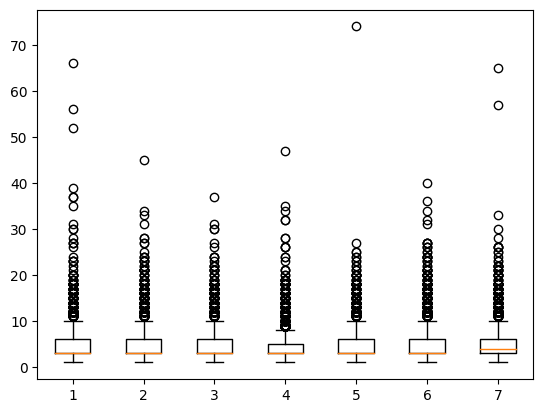

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '토요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '일요일'].loc[:,'ECLO',]])
plt.show()

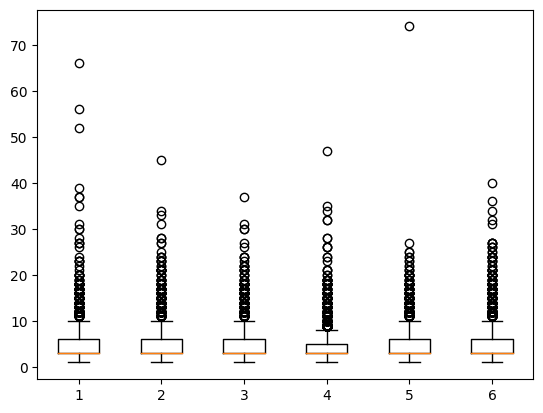

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[train_df['요일'] == '월요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '화요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '수요일'].loc[:,'ECLO'],
             train_df[train_df['요일'] == '목요일'].loc[:,'ECLO',],
             train_df[train_df['요일'] == '금요일'].loc[:,'ECLO',],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

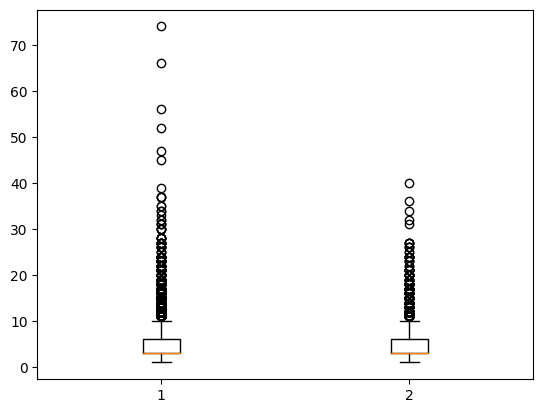

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([train_df[(train_df['요일'] == '월요일')|
                      (train_df['요일'] == '화요일')|
                      (train_df['요일'] == '수요일')|
                      (train_df['요일'] == '목요일')|
                      (train_df['요일'] == '금요일')].loc[:,'ECLO'],
             train_df[(train_df['요일'] == '토요일')|(train_df['요일'] == '토요일')].loc[:,'ECLO']])
plt.show()

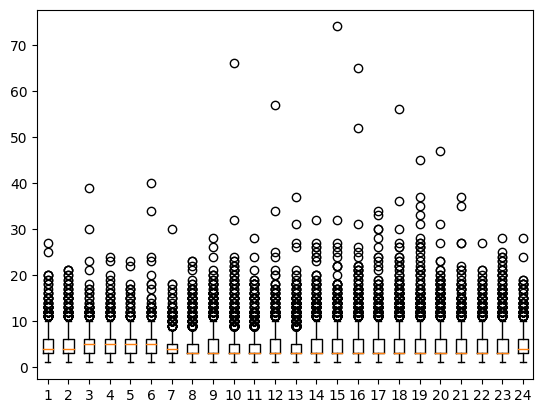

In [ ]:
plt.boxplot([train_df[train_df['시간'] == 0].loc[:,'ECLO',],
              train_df[train_df['시간'] == 1].loc[:,'ECLO',],
              train_df[train_df['시간'] == 2].loc[:,'ECLO'],
              train_df[train_df['시간'] == 3].loc[:,'ECLO',],
              train_df[train_df['시간'] == 4].loc[:,'ECLO',],
              train_df[train_df['시간'] == 5].loc[:,'ECLO',],
              train_df[train_df['시간'] == 6].loc[:,'ECLO',],
             train_df[train_df['시간'] == 7].loc[:,'ECLO',],
             train_df[train_df['시간'] == 8].loc[:,'ECLO',],
             train_df[train_df['시간'] == 9].loc[:,'ECLO',],
             train_df[train_df['시간'] == 10].loc[:,'ECLO',],
             train_df[train_df['시간'] == 11].loc[:,'ECLO',],
             train_df[train_df['시간'] == 12].loc[:,'ECLO',],
             train_df[train_df['시간'] == 13].loc[:,'ECLO',],
             train_df[train_df['시간'] == 14].loc[:,'ECLO',],
             train_df[train_df['시간'] == 15].loc[:,'ECLO',],
             train_df[train_df['시간'] == 16].loc[:,'ECLO',],
             train_df[train_df['시간'] == 17].loc[:,'ECLO',],
             train_df[train_df['시간'] == 18].loc[:,'ECLO',],
             train_df[train_df['시간'] == 19].loc[:,'ECLO',],
             train_df[train_df['시간'] == 20].loc[:,'ECLO',],
             train_df[train_df['시간'] == 21].loc[:,'ECLO',],
             train_df[train_df['시간'] == 22].loc[:,'ECLO',],
             train_df[train_df['시간'] == 23].loc[:,'ECLO',]])
plt.show()

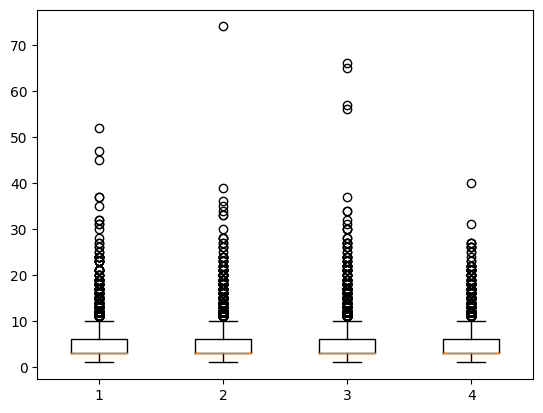

In [ ]:
plt.boxplot([train_df[(train_df['월'] >= 3)&(train_df['월'] <= 5)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 6)&(train_df['월'] <= 8)].loc[:,'ECLO',],
             train_df[(train_df['월'] >= 9)&(train_df['월'] <= 11)].loc[:,'ECLO'],
             train_df[(train_df['월'] == 12)|(train_df['월'] >= 1)&(train_df['월'] <= 2)].loc[:,'ECLO']])
plt.show()

피처, 타겟 분리 라벨인코딩

In [131]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = train_df.drop(columns=['ID','ECLO'])
y = train_df['ECLO']
test_df = test_df.drop(columns=['ID'])
print(X.shape, y.shape, test_df.shape)

(39609, 16) (39609,) (10963, 16)


In [132]:
from sklearn.preprocessing import LabelEncoder

FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시']
for i in FEATURE:
    le = LabelEncoder()
    X[i]= le.fit_transform(X[i])
    test_df[i]= le.transform(test_df[i])

X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수,평균속도
0,6,2,0,0,2019,1,1,0,0,7,40,2,5,2.0,1.0,0.000000
1,6,5,0,0,2019,1,1,0,0,1,4,2,5,0.0,4.0,52.500000
2,6,2,0,0,2019,1,1,1,0,6,66,2,5,5.0,4.0,55.000000
3,6,2,0,1,2019,1,1,2,0,4,79,2,5,11.0,10.0,37.500000
4,6,2,0,1,2019,1,1,4,0,3,129,2,5,0.0,12.0,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,2021,12,31,19,0,6,118,0,3,1.0,1.0,0.000000
39605,0,2,0,1,2021,12,31,19,0,1,103,2,5,0.0,18.0,45.000000
39606,0,2,0,1,2021,12,31,21,0,1,144,0,3,0.0,9.0,41.111111
39607,0,2,0,1,2021,12,31,22,0,1,158,1,5,0.0,1.0,60.000000


In [133]:
test_df

,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,어린이CCTV설치대수,CCTV개수,평균속도
0,5,2,0,0,2022,1,1,1,0,6,99,0,3,5.0,4.0,52.500000
1,5,2,0,0,2022,1,1,1,0,6,168,2,5,10.0,7.0,47.142857
2,5,2,0,1,2022,1,1,4,0,6,117,0,3,1.0,1.0,0.000000
3,5,2,0,1,2022,1,1,4,0,6,126,2,5,7.0,11.0,42.727273
4,5,2,0,1,2022,1,1,6,0,1,4,0,3,0.0,4.0,52.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,5,2,0,1,2022,12,31,18,0,0,38,2,9,26.0,27.0,48.636364
10959,5,2,0,1,2022,12,31,18,0,6,123,2,5,5.0,4.0,52.500000
10960,5,2,0,1,2022,12,31,20,0,6,134,2,5,0.0,0.0,0.000000
10961,5,2,0,1,2022,12,31,20,0,6,77,0,2,7.0,7.0,44.285714


모델 훈련 및 예측

In [134]:
#xgboost3.csv
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # XGBoost의 하이퍼파라미터를 설정합니다.
    param = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'lambda': trial.suggest_float('lambda', 1e-3, 0.1),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1),
        'subsample': trial.suggest_float('subsample', 0.4, 1),
        'learning_rate': trial.suggest_float('learning_rate',0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4,8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 50),
    }

    # XGBoost 모델을 생성합니다.
    model = xgb.XGBRegressor(**param)

    # 모델을 훈련합니다.
    model.fit(X_train, np.log1p(y_train), eval_set=[(X_val,np.log1p(y_val))],early_stopping_rounds=100)

    # 검증 데이터에 대한 예측을 수행합니다.
    y_pred = model.predict(X_val)

    # RMSE를 계산하여 반환합니다.
    rmsle = np.sqrt(mean_squared_log_error(y_val, np.expm1(y_pred)))
    return rmsle

# Optuna를 사용하여 하이퍼파라미터 튜닝을 수행합니다.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터를 출력합니다.
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_params = trial.params
final_model = xgb.XGBRegressor(
    objective='reg:squaredlogerror',
    eval_metric='rmsle',
    verbosity=0,
    n_jobs=-1,
    tree_method='hist',
    **best_params
)

final_model.fit(X, y, verbose=False)
y_pred = final_model.predict(test_df)

[I 2023-11-18 16:11:22,121] A new study created in memory with name: no-name-e5199d65-07c3-4a19-ac5b-e4aed78730f0


[0]	validation_0-rmsle:0.56476
[1]	validation_0-rmsle:0.54863
[2]	validation_0-rmsle:0.53288
[3]	validation_0-rmsle:0.51750
[4]	validation_0-rmsle:0.50251
[5]	validation_0-rmsle:0.48793
[6]	validation_0-rmsle:0.47371
[7]	validation_0-rmsle:0.45987
[8]	validation_0-rmsle:0.44642
[9]	validation_0-rmsle:0.43335
[10]	validation_0-rmsle:0.42070
[11]	validation_0-rmsle:0.40842
[12]	validation_0-rmsle:0.39654
[13]	validation_0-rmsle:0.38505
[14]	validation_0-rmsle:0.37396
[15]	validation_0-rmsle:0.36324
[16]	validation_0-rmsle:0.35288
[17]	validation_0-rmsle:0.34293
[18]	validation_0-rmsle:0.33336
[19]	validation_0-rmsle:0.32416
[20]	validation_0-rmsle:0.31530
[21]	validation_0-rmsle:0.30683
[22]	validation_0-rmsle:0.29872
[23]	validation_0-rmsle:0.29093
[24]	validation_0-rmsle:0.28348
[25]	validation_0-rmsle:0.27641
[26]	validation_0-rmsle:0.26965
[27]	validation_0-rmsle:0.26325
[28]	validation_0-rmsle:0.25713
[29]	validation_0-rmsle:0.25136
[30]	validation_0-rmsle:0.24590
[31]	validation_0-

[I 2023-11-18 16:11:25,278] Trial 0 finished with value: 0.4467923429483162 and parameters: {'lambda': 0.05121622356013199, 'alpha': 0.22218812193330595, 'colsample_bytree': 0.42461473554082485, 'subsample': 0.8890698176874582, 'learning_rate': 0.048905777722994294, 'n_estimators': 170, 'max_depth': 4, 'min_child_weight': 3}. Best is trial 0 with value: 0.4467923429483162.


[0]	validation_0-rmsle:0.57620
[1]	validation_0-rmsle:0.57117
[2]	validation_0-rmsle:0.56617
[3]	validation_0-rmsle:0.56121
[4]	validation_0-rmsle:0.55628
[5]	validation_0-rmsle:0.55140
[6]	validation_0-rmsle:0.54653
[7]	validation_0-rmsle:0.54171
[8]	validation_0-rmsle:0.53692
[9]	validation_0-rmsle:0.53216
[10]	validation_0-rmsle:0.52746
[11]	validation_0-rmsle:0.52279
[12]	validation_0-rmsle:0.51816
[13]	validation_0-rmsle:0.51355
[14]	validation_0-rmsle:0.50899
[15]	validation_0-rmsle:0.50445
[16]	validation_0-rmsle:0.49995
[17]	validation_0-rmsle:0.49548
[18]	validation_0-rmsle:0.49107
[19]	validation_0-rmsle:0.48668
[20]	validation_0-rmsle:0.48233
[21]	validation_0-rmsle:0.47802
[22]	validation_0-rmsle:0.47373
[23]	validation_0-rmsle:0.46948
[24]	validation_0-rmsle:0.46527
[25]	validation_0-rmsle:0.46109
[26]	validation_0-rmsle:0.45695
[27]	validation_0-rmsle:0.45286
[28]	validation_0-rmsle:0.44878
[29]	validation_0-rmsle:0.44476
[30]	validation_0-rmsle:0.44077
[31]	validation_0-

[I 2023-11-18 16:11:31,826] Trial 1 finished with value: 0.4868792705291706 and parameters: {'lambda': 0.05151359778986159, 'alpha': 0.07675751868009736, 'colsample_bytree': 0.6191261190144053, 'subsample': 0.498997575410101, 'learning_rate': 0.014901259782412867, 'n_estimators': 179, 'max_depth': 6, 'min_child_weight': 29}. Best is trial 0 with value: 0.4467923429483162.


[0]	validation_0-rmsle:0.57344
[1]	validation_0-rmsle:0.56570
[2]	validation_0-rmsle:0.55804
[3]	validation_0-rmsle:0.55046
[4]	validation_0-rmsle:0.54298
[5]	validation_0-rmsle:0.53557
[6]	validation_0-rmsle:0.52824
[7]	validation_0-rmsle:0.52100
[8]	validation_0-rmsle:0.51385
[9]	validation_0-rmsle:0.50678
[10]	validation_0-rmsle:0.49980
[11]	validation_0-rmsle:0.49291
[12]	validation_0-rmsle:0.48611
[13]	validation_0-rmsle:0.47940
[14]	validation_0-rmsle:0.47277
[15]	validation_0-rmsle:0.46623
[16]	validation_0-rmsle:0.45977
[17]	validation_0-rmsle:0.45340
[18]	validation_0-rmsle:0.44713
[19]	validation_0-rmsle:0.44094
[20]	validation_0-rmsle:0.43483
[21]	validation_0-rmsle:0.42881
[22]	validation_0-rmsle:0.42287
[23]	validation_0-rmsle:0.41702
[24]	validation_0-rmsle:0.41125
[25]	validation_0-rmsle:0.40557
[26]	validation_0-rmsle:0.39997
[27]	validation_0-rmsle:0.39446
[28]	validation_0-rmsle:0.38904
[29]	validation_0-rmsle:0.38371
[30]	validation_0-rmsle:0.37846
[31]	validation_0-

[I 2023-11-18 16:11:37,254] Trial 2 finished with value: 0.4469300693945519 and parameters: {'lambda': 0.060359056643321, 'alpha': 0.6041022545242805, 'colsample_bytree': 0.6990418396509277, 'subsample': 0.9483422313200537, 'learning_rate': 0.02306027708441124, 'n_estimators': 385, 'max_depth': 8, 'min_child_weight': 26}. Best is trial 0 with value: 0.4467923429483162.


[0]	validation_0-rmsle:0.56892
[1]	validation_0-rmsle:0.55679
[2]	validation_0-rmsle:0.54488
[3]	validation_0-rmsle:0.53317
[4]	validation_0-rmsle:0.52168
[5]	validation_0-rmsle:0.51039
[6]	validation_0-rmsle:0.49931
[7]	validation_0-rmsle:0.48845
[8]	validation_0-rmsle:0.47782
[9]	validation_0-rmsle:0.46738
[10]	validation_0-rmsle:0.45717
[11]	validation_0-rmsle:0.44718
[12]	validation_0-rmsle:0.43742
[13]	validation_0-rmsle:0.42787
[14]	validation_0-rmsle:0.41854
[15]	validation_0-rmsle:0.40942
[16]	validation_0-rmsle:0.40051
[17]	validation_0-rmsle:0.39182
[18]	validation_0-rmsle:0.38336
[19]	validation_0-rmsle:0.37511
[20]	validation_0-rmsle:0.36706
[21]	validation_0-rmsle:0.35925
[22]	validation_0-rmsle:0.35162
[23]	validation_0-rmsle:0.34419
[24]	validation_0-rmsle:0.33699
[25]	validation_0-rmsle:0.32996
[26]	validation_0-rmsle:0.32316
[27]	validation_0-rmsle:0.31659
[28]	validation_0-rmsle:0.31019
[29]	validation_0-rmsle:0.30401
[30]	validation_0-rmsle:0.29802
[31]	validation_0-

[I 2023-11-18 16:11:44,213] Trial 3 finished with value: 0.4465570923226424 and parameters: {'lambda': 0.05786837895081427, 'alpha': 0.9351843501643988, 'colsample_bytree': 0.5327140703197446, 'subsample': 0.8583705292882204, 'learning_rate': 0.03646210566613692, 'n_estimators': 913, 'max_depth': 8, 'min_child_weight': 49}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.56986
[1]	validation_0-rmsle:0.55863
[2]	validation_0-rmsle:0.54757
[3]	validation_0-rmsle:0.53670
[4]	validation_0-rmsle:0.52601
[5]	validation_0-rmsle:0.51550
[6]	validation_0-rmsle:0.50516
[7]	validation_0-rmsle:0.49501
[8]	validation_0-rmsle:0.48505
[9]	validation_0-rmsle:0.47527
[10]	validation_0-rmsle:0.46569
[11]	validation_0-rmsle:0.45628
[12]	validation_0-rmsle:0.44706
[13]	validation_0-rmsle:0.43802
[14]	validation_0-rmsle:0.42918
[15]	validation_0-rmsle:0.42051
[16]	validation_0-rmsle:0.41202
[17]	validation_0-rmsle:0.40374
[18]	validation_0-rmsle:0.39563
[19]	validation_0-rmsle:0.38771
[20]	validation_0-rmsle:0.37997
[21]	validation_0-rmsle:0.37242
[22]	validation_0-rmsle:0.36505
[23]	validation_0-rmsle:0.35784
[24]	validation_0-rmsle:0.35081
[25]	validation_0-rmsle:0.34397
[26]	validation_0-rmsle:0.33729
[27]	validation_0-rmsle:0.33082
[28]	validation_0-rmsle:0.32448
[29]	validation_0-rmsle:0.31835
[30]	validation_0-rmsle:0.31239
[31]	validation_0-

[I 2023-11-18 16:11:52,160] Trial 4 finished with value: 0.44661458896553485 and parameters: {'lambda': 0.048439779978281, 'alpha': 0.03093353817794363, 'colsample_bytree': 0.4442046097349676, 'subsample': 0.857639723304281, 'learning_rate': 0.033694279883299885, 'n_estimators': 808, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.57392
[1]	validation_0-rmsle:0.56665
[2]	validation_0-rmsle:0.55944
[3]	validation_0-rmsle:0.55231
[4]	validation_0-rmsle:0.54526
[5]	validation_0-rmsle:0.53829
[6]	validation_0-rmsle:0.53137
[7]	validation_0-rmsle:0.52455
[8]	validation_0-rmsle:0.51780
[9]	validation_0-rmsle:0.51112
[10]	validation_0-rmsle:0.50453
[11]	validation_0-rmsle:0.49801
[12]	validation_0-rmsle:0.49157
[13]	validation_0-rmsle:0.48520
[14]	validation_0-rmsle:0.47891
[15]	validation_0-rmsle:0.47268
[16]	validation_0-rmsle:0.46654
[17]	validation_0-rmsle:0.46048
[18]	validation_0-rmsle:0.45449
[19]	validation_0-rmsle:0.44858
[20]	validation_0-rmsle:0.44276
[21]	validation_0-rmsle:0.43699
[22]	validation_0-rmsle:0.43130
[23]	validation_0-rmsle:0.42568
[24]	validation_0-rmsle:0.42015
[25]	validation_0-rmsle:0.41468
[26]	validation_0-rmsle:0.40929
[27]	validation_0-rmsle:0.40400
[28]	validation_0-rmsle:0.39874
[29]	validation_0-rmsle:0.39358
[30]	validation_0-rmsle:0.38850
[31]	validation_0-

[I 2023-11-18 16:11:53,991] Trial 5 finished with value: 0.4813016972192041 and parameters: {'lambda': 0.07696627676829998, 'alpha': 0.2518940062961931, 'colsample_bytree': 0.9210458727831328, 'subsample': 0.5955192499169111, 'learning_rate': 0.021637276211281514, 'n_estimators': 128, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.56844
[1]	validation_0-rmsle:0.55583
[2]	validation_0-rmsle:0.54345
[3]	validation_0-rmsle:0.53130
[4]	validation_0-rmsle:0.51937
[5]	validation_0-rmsle:0.50769
[6]	validation_0-rmsle:0.49622
[7]	validation_0-rmsle:0.48500
[8]	validation_0-rmsle:0.47401
[9]	validation_0-rmsle:0.46325
[10]	validation_0-rmsle:0.45273
[11]	validation_0-rmsle:0.44244
[12]	validation_0-rmsle:0.43238
[13]	validation_0-rmsle:0.42256
[14]	validation_0-rmsle:0.41298
[15]	validation_0-rmsle:0.40362
[16]	validation_0-rmsle:0.39451
[17]	validation_0-rmsle:0.38561
[18]	validation_0-rmsle:0.37696
[19]	validation_0-rmsle:0.36854
[20]	validation_0-rmsle:0.36034
[21]	validation_0-rmsle:0.35238
[22]	validation_0-rmsle:0.34463
[23]	validation_0-rmsle:0.33711
[24]	validation_0-rmsle:0.32982
[25]	validation_0-rmsle:0.32275
[26]	validation_0-rmsle:0.31590
[27]	validation_0-rmsle:0.30927
[28]	validation_0-rmsle:0.30286
[29]	validation_0-rmsle:0.29666
[30]	validation_0-rmsle:0.29067
[31]	validation_0-

[I 2023-11-18 16:11:55,666] Trial 6 finished with value: 0.4502663004756071 and parameters: {'lambda': 0.026374985091025597, 'alpha': 0.44947155295783503, 'colsample_bytree': 0.9830545405764813, 'subsample': 0.9576594555138908, 'learning_rate': 0.03790295213585551, 'n_estimators': 118, 'max_depth': 5, 'min_child_weight': 43}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.58102
[1]	validation_0-rmsle:0.58076
[2]	validation_0-rmsle:0.58050
[3]	validation_0-rmsle:0.58025
[4]	validation_0-rmsle:0.57999
[5]	validation_0-rmsle:0.57974
[6]	validation_0-rmsle:0.57948
[7]	validation_0-rmsle:0.57922
[8]	validation_0-rmsle:0.57897
[9]	validation_0-rmsle:0.57871
[10]	validation_0-rmsle:0.57846
[11]	validation_0-rmsle:0.57820
[12]	validation_0-rmsle:0.57795
[13]	validation_0-rmsle:0.57769
[14]	validation_0-rmsle:0.57744
[15]	validation_0-rmsle:0.57718
[16]	validation_0-rmsle:0.57692
[17]	validation_0-rmsle:0.57667
[18]	validation_0-rmsle:0.57642
[19]	validation_0-rmsle:0.57616
[20]	validation_0-rmsle:0.57591
[21]	validation_0-rmsle:0.57565
[22]	validation_0-rmsle:0.57540
[23]	validation_0-rmsle:0.57514
[24]	validation_0-rmsle:0.57489
[25]	validation_0-rmsle:0.57463
[26]	validation_0-rmsle:0.57438
[27]	validation_0-rmsle:0.57412
[28]	validation_0-rmsle:0.57387
[29]	validation_0-rmsle:0.57362
[30]	validation_0-rmsle:0.57336
[31]	validation_0-

[I 2023-11-18 16:12:12,712] Trial 7 finished with value: 0.9088225954749688 and parameters: {'lambda': 0.012125813410728516, 'alpha': 0.677568098241483, 'colsample_bytree': 0.6505269073134243, 'subsample': 0.6953393144646103, 'learning_rate': 0.0007519563370509163, 'n_estimators': 926, 'max_depth': 6, 'min_child_weight': 40}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.57933
[1]	validation_0-rmsle:0.57739
[2]	validation_0-rmsle:0.57545
[3]	validation_0-rmsle:0.57352
[4]	validation_0-rmsle:0.57159
[5]	validation_0-rmsle:0.56968
[6]	validation_0-rmsle:0.56776
[7]	validation_0-rmsle:0.56585
[8]	validation_0-rmsle:0.56395
[9]	validation_0-rmsle:0.56205
[10]	validation_0-rmsle:0.56015
[11]	validation_0-rmsle:0.55827
[12]	validation_0-rmsle:0.55638
[13]	validation_0-rmsle:0.55451
[14]	validation_0-rmsle:0.55264
[15]	validation_0-rmsle:0.55077
[16]	validation_0-rmsle:0.54890
[17]	validation_0-rmsle:0.54705
[18]	validation_0-rmsle:0.54519
[19]	validation_0-rmsle:0.54335
[20]	validation_0-rmsle:0.54151
[21]	validation_0-rmsle:0.53967
[22]	validation_0-rmsle:0.53784
[23]	validation_0-rmsle:0.53602
[24]	validation_0-rmsle:0.53420
[25]	validation_0-rmsle:0.53238
[26]	validation_0-rmsle:0.53057
[27]	validation_0-rmsle:0.52876
[28]	validation_0-rmsle:0.52696
[29]	validation_0-rmsle:0.52516
[30]	validation_0-rmsle:0.52337
[31]	validation_0-

[I 2023-11-18 16:12:32,444] Trial 8 finished with value: 0.44790721655677057 and parameters: {'lambda': 0.034056583072455945, 'alpha': 0.042838879020849145, 'colsample_bytree': 0.9473722355249752, 'subsample': 0.6381666650970824, 'learning_rate': 0.005707664256801113, 'n_estimators': 920, 'max_depth': 7, 'min_child_weight': 34}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.56889
[1]	validation_0-rmsle:0.55673
[2]	validation_0-rmsle:0.54478
[3]	validation_0-rmsle:0.53304
[4]	validation_0-rmsle:0.52153
[5]	validation_0-rmsle:0.51023
[6]	validation_0-rmsle:0.49912
[7]	validation_0-rmsle:0.48825
[8]	validation_0-rmsle:0.47759
[9]	validation_0-rmsle:0.46713
[10]	validation_0-rmsle:0.45691
[11]	validation_0-rmsle:0.44690
[12]	validation_0-rmsle:0.43711
[13]	validation_0-rmsle:0.42752
[14]	validation_0-rmsle:0.41817
[15]	validation_0-rmsle:0.40902
[16]	validation_0-rmsle:0.40009
[17]	validation_0-rmsle:0.39137
[18]	validation_0-rmsle:0.38287
[19]	validation_0-rmsle:0.37459
[20]	validation_0-rmsle:0.36653
[21]	validation_0-rmsle:0.35868
[22]	validation_0-rmsle:0.35105
[23]	validation_0-rmsle:0.34361
[24]	validation_0-rmsle:0.33638
[25]	validation_0-rmsle:0.32934
[26]	validation_0-rmsle:0.32253
[27]	validation_0-rmsle:0.31593
[28]	validation_0-rmsle:0.30951
[29]	validation_0-rmsle:0.30331
[30]	validation_0-rmsle:0.29730
[31]	validation_0-

[I 2023-11-18 16:12:36,836] Trial 9 finished with value: 0.44758765500828573 and parameters: {'lambda': 0.08820142442033647, 'alpha': 0.11359248240405619, 'colsample_bytree': 0.9112314543627916, 'subsample': 0.7725869965430225, 'learning_rate': 0.03653222714175749, 'n_estimators': 211, 'max_depth': 8, 'min_child_weight': 34}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.55785
[1]	validation_0-rmsle:0.53523
[2]	validation_0-rmsle:0.51340
[3]	validation_0-rmsle:0.49232
[4]	validation_0-rmsle:0.47204
[5]	validation_0-rmsle:0.45252
[6]	validation_0-rmsle:0.43376
[7]	validation_0-rmsle:0.41580
[8]	validation_0-rmsle:0.39863
[9]	validation_0-rmsle:0.38222
[10]	validation_0-rmsle:0.36663
[11]	validation_0-rmsle:0.35179
[12]	validation_0-rmsle:0.33777
[13]	validation_0-rmsle:0.32447
[14]	validation_0-rmsle:0.31196
[15]	validation_0-rmsle:0.30012
[16]	validation_0-rmsle:0.28903
[17]	validation_0-rmsle:0.27866
[18]	validation_0-rmsle:0.26900
[19]	validation_0-rmsle:0.26002
[20]	validation_0-rmsle:0.25164
[21]	validation_0-rmsle:0.24393
[22]	validation_0-rmsle:0.23678
[23]	validation_0-rmsle:0.23018
[24]	validation_0-rmsle:0.22415
[25]	validation_0-rmsle:0.21860
[26]	validation_0-rmsle:0.21357
[27]	validation_0-rmsle:0.20906
[28]	validation_0-rmsle:0.20491
[29]	validation_0-rmsle:0.20120
[30]	validation_0-rmsle:0.19786
[31]	validation_0-

[I 2023-11-18 16:12:44,635] Trial 10 finished with value: 0.4466943822741173 and parameters: {'lambda': 0.09896506444388894, 'alpha': 0.9185088845157521, 'colsample_bytree': 0.5373298633105721, 'subsample': 0.7744182244941391, 'learning_rate': 0.06956875150572947, 'n_estimators': 673, 'max_depth': 7, 'min_child_weight': 50}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.54843
[1]	validation_0-rmsle:0.51713
[2]	validation_0-rmsle:0.48737
[3]	validation_0-rmsle:0.45914
[4]	validation_0-rmsle:0.43249
[5]	validation_0-rmsle:0.40741
[6]	validation_0-rmsle:0.38388
[7]	validation_0-rmsle:0.36187
[8]	validation_0-rmsle:0.34141
[9]	validation_0-rmsle:0.32243
[10]	validation_0-rmsle:0.30505
[11]	validation_0-rmsle:0.28908
[12]	validation_0-rmsle:0.27458
[13]	validation_0-rmsle:0.26143
[14]	validation_0-rmsle:0.24966
[15]	validation_0-rmsle:0.23912
[16]	validation_0-rmsle:0.22964
[17]	validation_0-rmsle:0.22136
[18]	validation_0-rmsle:0.21409
[19]	validation_0-rmsle:0.20777
[20]	validation_0-rmsle:0.20224
[21]	validation_0-rmsle:0.19752
[22]	validation_0-rmsle:0.19346
[23]	validation_0-rmsle:0.18991
[24]	validation_0-rmsle:0.18689
[25]	validation_0-rmsle:0.18438
[26]	validation_0-rmsle:0.18224
[27]	validation_0-rmsle:0.18049
[28]	validation_0-rmsle:0.17894
[29]	validation_0-rmsle:0.17772
[30]	validation_0-rmsle:0.17668
[31]	validation_0-

[I 2023-11-18 16:12:48,630] Trial 11 finished with value: 0.4467019883301055 and parameters: {'lambda': 0.06319884864691677, 'alpha': 0.9836960410477567, 'colsample_bytree': 0.4118478251440061, 'subsample': 0.8357513314628914, 'learning_rate': 0.09822430599877341, 'n_estimators': 732, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.56138
[1]	validation_0-rmsle:0.54206
[2]	validation_0-rmsle:0.52330
[3]	validation_0-rmsle:0.50509
[4]	validation_0-rmsle:0.48745
[5]	validation_0-rmsle:0.47034
[6]	validation_0-rmsle:0.45380
[7]	validation_0-rmsle:0.43782
[8]	validation_0-rmsle:0.42241
[9]	validation_0-rmsle:0.40756
[10]	validation_0-rmsle:0.39328
[11]	validation_0-rmsle:0.37956
[12]	validation_0-rmsle:0.36643
[13]	validation_0-rmsle:0.35385
[14]	validation_0-rmsle:0.34183
[15]	validation_0-rmsle:0.33032
[16]	validation_0-rmsle:0.31935
[17]	validation_0-rmsle:0.30896
[18]	validation_0-rmsle:0.29909
[19]	validation_0-rmsle:0.28974
[20]	validation_0-rmsle:0.28086
[21]	validation_0-rmsle:0.27252
[22]	validation_0-rmsle:0.26462
[23]	validation_0-rmsle:0.25720
[24]	validation_0-rmsle:0.25024
[25]	validation_0-rmsle:0.24372
[26]	validation_0-rmsle:0.23765
[27]	validation_0-rmsle:0.23200
[28]	validation_0-rmsle:0.22673
[29]	validation_0-rmsle:0.22187
[30]	validation_0-rmsle:0.21737
[31]	validation_0-

[I 2023-11-18 16:12:53,675] Trial 12 finished with value: 0.44669880772527343 and parameters: {'lambda': 0.03804606869025056, 'alpha': 0.7995911051031828, 'colsample_bytree': 0.5087278776095663, 'subsample': 0.9991279910402062, 'learning_rate': 0.05897294109199749, 'n_estimators': 774, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 3 with value: 0.4465570923226424.


[0]	validation_0-rmsle:0.57034
[1]	validation_0-rmsle:0.55960
[2]	validation_0-rmsle:0.54902
[3]	validation_0-rmsle:0.53860
[4]	validation_0-rmsle:0.52835
[5]	validation_0-rmsle:0.51826
[6]	validation_0-rmsle:0.50833
[7]	validation_0-rmsle:0.49857
[8]	validation_0-rmsle:0.48899
[9]	validation_0-rmsle:0.47956
[10]	validation_0-rmsle:0.47031
[11]	validation_0-rmsle:0.46123
[12]	validation_0-rmsle:0.45233
[13]	validation_0-rmsle:0.44359
[14]	validation_0-rmsle:0.43503
[15]	validation_0-rmsle:0.42663
[16]	validation_0-rmsle:0.41839
[17]	validation_0-rmsle:0.41033
[18]	validation_0-rmsle:0.40245
[19]	validation_0-rmsle:0.39473
[20]	validation_0-rmsle:0.38717
[21]	validation_0-rmsle:0.37980
[22]	validation_0-rmsle:0.37256
[23]	validation_0-rmsle:0.36549
[24]	validation_0-rmsle:0.35859
[25]	validation_0-rmsle:0.35184
[26]	validation_0-rmsle:0.34526
[27]	validation_0-rmsle:0.33887
[28]	validation_0-rmsle:0.33261
[29]	validation_0-rmsle:0.32654
[30]	validation_0-rmsle:0.32062
[31]	validation_0-

[I 2023-11-18 16:13:05,042] Trial 13 finished with value: 0.4465133638885674 and parameters: {'lambda': 0.06978537785649479, 'alpha': 0.4568365432884193, 'colsample_bytree': 0.5173696912963758, 'subsample': 0.849270011682653, 'learning_rate': 0.03221375378070444, 'n_estimators': 985, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.56411
[1]	validation_0-rmsle:0.54738
[2]	validation_0-rmsle:0.53107
[3]	validation_0-rmsle:0.51516
[4]	validation_0-rmsle:0.49967
[5]	validation_0-rmsle:0.48459
[6]	validation_0-rmsle:0.46990
[7]	validation_0-rmsle:0.45565
[8]	validation_0-rmsle:0.44182
[9]	validation_0-rmsle:0.42840
[10]	validation_0-rmsle:0.41541
[11]	validation_0-rmsle:0.40283
[12]	validation_0-rmsle:0.39070
[13]	validation_0-rmsle:0.37897
[14]	validation_0-rmsle:0.36767
[15]	validation_0-rmsle:0.35674
[16]	validation_0-rmsle:0.34623
[17]	validation_0-rmsle:0.33615
[18]	validation_0-rmsle:0.32647
[19]	validation_0-rmsle:0.31721
[20]	validation_0-rmsle:0.30831
[21]	validation_0-rmsle:0.29983
[22]	validation_0-rmsle:0.29170
[23]	validation_0-rmsle:0.28393
[24]	validation_0-rmsle:0.27655
[25]	validation_0-rmsle:0.26949
[26]	validation_0-rmsle:0.26282
[27]	validation_0-rmsle:0.25654
[28]	validation_0-rmsle:0.25054
[29]	validation_0-rmsle:0.24491
[30]	validation_0-rmsle:0.23959
[31]	validation_0-

[I 2023-11-18 16:13:09,717] Trial 14 finished with value: 0.44683438188516317 and parameters: {'lambda': 0.07471949207622418, 'alpha': 0.453207075953729, 'colsample_bytree': 0.5486279577932333, 'subsample': 0.7806686575594782, 'learning_rate': 0.05079051259504531, 'n_estimators': 999, 'max_depth': 7, 'min_child_weight': 21}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.57228
[1]	validation_0-rmsle:0.56341
[2]	validation_0-rmsle:0.55465
[3]	validation_0-rmsle:0.54600
[4]	validation_0-rmsle:0.53747
[5]	validation_0-rmsle:0.52904
[6]	validation_0-rmsle:0.52072
[7]	validation_0-rmsle:0.51251
[8]	validation_0-rmsle:0.50443
[9]	validation_0-rmsle:0.49645
[10]	validation_0-rmsle:0.48859
[11]	validation_0-rmsle:0.48084
[12]	validation_0-rmsle:0.47321
[13]	validation_0-rmsle:0.46569
[14]	validation_0-rmsle:0.45829
[15]	validation_0-rmsle:0.45099
[16]	validation_0-rmsle:0.44382
[17]	validation_0-rmsle:0.43677
[18]	validation_0-rmsle:0.42983
[19]	validation_0-rmsle:0.42299
[20]	validation_0-rmsle:0.41627
[21]	validation_0-rmsle:0.40968
[22]	validation_0-rmsle:0.40319
[23]	validation_0-rmsle:0.39681
[24]	validation_0-rmsle:0.39055
[25]	validation_0-rmsle:0.38439
[26]	validation_0-rmsle:0.37835
[27]	validation_0-rmsle:0.37242
[28]	validation_0-rmsle:0.36661
[29]	validation_0-rmsle:0.36092
[30]	validation_0-rmsle:0.35533
[31]	validation_0-

[I 2023-11-18 16:13:17,062] Trial 15 finished with value: 0.4468818830397916 and parameters: {'lambda': 0.06965015054982165, 'alpha': 0.792721644967536, 'colsample_bytree': 0.8004502632946277, 'subsample': 0.8992757454508804, 'learning_rate': 0.026482709980866735, 'n_estimators': 555, 'max_depth': 8, 'min_child_weight': 48}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.57690
[1]	validation_0-rmsle:0.57256
[2]	validation_0-rmsle:0.56824
[3]	validation_0-rmsle:0.56395
[4]	validation_0-rmsle:0.55968
[5]	validation_0-rmsle:0.55545
[6]	validation_0-rmsle:0.55124
[7]	validation_0-rmsle:0.54705
[8]	validation_0-rmsle:0.54289
[9]	validation_0-rmsle:0.53875
[10]	validation_0-rmsle:0.53465
[11]	validation_0-rmsle:0.53057
[12]	validation_0-rmsle:0.52653
[13]	validation_0-rmsle:0.52250
[14]	validation_0-rmsle:0.51851
[15]	validation_0-rmsle:0.51453
[16]	validation_0-rmsle:0.51058
[17]	validation_0-rmsle:0.50667
[18]	validation_0-rmsle:0.50278
[19]	validation_0-rmsle:0.49892
[20]	validation_0-rmsle:0.49508
[21]	validation_0-rmsle:0.49126
[22]	validation_0-rmsle:0.48748
[23]	validation_0-rmsle:0.48372
[24]	validation_0-rmsle:0.47999
[25]	validation_0-rmsle:0.47627
[26]	validation_0-rmsle:0.47259
[27]	validation_0-rmsle:0.46894
[28]	validation_0-rmsle:0.46530
[29]	validation_0-rmsle:0.46170
[30]	validation_0-rmsle:0.45814
[31]	validation_0-

[I 2023-11-18 16:13:30,071] Trial 16 finished with value: 0.4472803169434816 and parameters: {'lambda': 0.07742122158593895, 'alpha': 0.5742178688505353, 'colsample_bytree': 0.5956481069755339, 'subsample': 0.40276455335035405, 'learning_rate': 0.012850046245710123, 'n_estimators': 553, 'max_depth': 5, 'min_child_weight': 24}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.56681
[1]	validation_0-rmsle:0.55264
[2]	validation_0-rmsle:0.53877
[3]	validation_0-rmsle:0.52518
[4]	validation_0-rmsle:0.51190
[5]	validation_0-rmsle:0.49892
[6]	validation_0-rmsle:0.48620
[7]	validation_0-rmsle:0.47379
[8]	validation_0-rmsle:0.46168
[9]	validation_0-rmsle:0.44985
[10]	validation_0-rmsle:0.43836
[11]	validation_0-rmsle:0.42714
[12]	validation_0-rmsle:0.41623
[13]	validation_0-rmsle:0.40562
[14]	validation_0-rmsle:0.39531
[15]	validation_0-rmsle:0.38527
[16]	validation_0-rmsle:0.37552
[17]	validation_0-rmsle:0.36609
[18]	validation_0-rmsle:0.35696
[19]	validation_0-rmsle:0.34812
[20]	validation_0-rmsle:0.33955
[21]	validation_0-rmsle:0.33129
[22]	validation_0-rmsle:0.32330
[23]	validation_0-rmsle:0.31556
[24]	validation_0-rmsle:0.30811
[25]	validation_0-rmsle:0.30094
[26]	validation_0-rmsle:0.29402
[27]	validation_0-rmsle:0.28741
[28]	validation_0-rmsle:0.28102
[29]	validation_0-rmsle:0.27493
[30]	validation_0-rmsle:0.26908
[31]	validation_0-

[I 2023-11-18 16:13:34,874] Trial 17 finished with value: 0.44712965060884335 and parameters: {'lambda': 0.06169798949703312, 'alpha': 0.35558574616046584, 'colsample_bytree': 0.49233994355475563, 'subsample': 0.8147431531468161, 'learning_rate': 0.04276465011057531, 'n_estimators': 880, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.57029
[1]	validation_0-rmsle:0.55950
[2]	validation_0-rmsle:0.54887
[3]	validation_0-rmsle:0.53840
[4]	validation_0-rmsle:0.52811
[5]	validation_0-rmsle:0.51797
[6]	validation_0-rmsle:0.50799
[7]	validation_0-rmsle:0.49820
[8]	validation_0-rmsle:0.48857
[9]	validation_0-rmsle:0.47910
[10]	validation_0-rmsle:0.46982
[11]	validation_0-rmsle:0.46070
[12]	validation_0-rmsle:0.45177
[13]	validation_0-rmsle:0.44301
[14]	validation_0-rmsle:0.43442
[15]	validation_0-rmsle:0.42597
[16]	validation_0-rmsle:0.41771
[17]	validation_0-rmsle:0.40962
[18]	validation_0-rmsle:0.40171
[19]	validation_0-rmsle:0.39397
[20]	validation_0-rmsle:0.38640
[21]	validation_0-rmsle:0.37899
[22]	validation_0-rmsle:0.37175
[23]	validation_0-rmsle:0.36466
[24]	validation_0-rmsle:0.35774
[25]	validation_0-rmsle:0.35098
[26]	validation_0-rmsle:0.34439
[27]	validation_0-rmsle:0.33798
[28]	validation_0-rmsle:0.33169
[29]	validation_0-rmsle:0.32561
[30]	validation_0-rmsle:0.31968
[31]	validation_0-

[I 2023-11-18 16:13:44,724] Trial 18 finished with value: 0.446657486012715 and parameters: {'lambda': 0.0013432196509612915, 'alpha': 0.7087260937384264, 'colsample_bytree': 0.5800532535005778, 'subsample': 0.7271488128167932, 'learning_rate': 0.03237961183956663, 'n_estimators': 390, 'max_depth': 4, 'min_child_weight': 32}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.57538
[1]	validation_0-rmsle:0.56953
[2]	validation_0-rmsle:0.56373
[3]	validation_0-rmsle:0.55798
[4]	validation_0-rmsle:0.55227
[5]	validation_0-rmsle:0.54662
[6]	validation_0-rmsle:0.54100
[7]	validation_0-rmsle:0.53544
[8]	validation_0-rmsle:0.52993
[9]	validation_0-rmsle:0.52446
[10]	validation_0-rmsle:0.51904
[11]	validation_0-rmsle:0.51368
[12]	validation_0-rmsle:0.50836
[13]	validation_0-rmsle:0.50309
[14]	validation_0-rmsle:0.49788
[15]	validation_0-rmsle:0.49271
[16]	validation_0-rmsle:0.48758
[17]	validation_0-rmsle:0.48252
[18]	validation_0-rmsle:0.47750
[19]	validation_0-rmsle:0.47253
[20]	validation_0-rmsle:0.46760
[21]	validation_0-rmsle:0.46273
[22]	validation_0-rmsle:0.45791
[23]	validation_0-rmsle:0.45313
[24]	validation_0-rmsle:0.44840
[25]	validation_0-rmsle:0.44372
[26]	validation_0-rmsle:0.43908
[27]	validation_0-rmsle:0.43451
[28]	validation_0-rmsle:0.42997
[29]	validation_0-rmsle:0.42549
[30]	validation_0-rmsle:0.42105
[31]	validation_0-

[I 2023-11-18 16:14:03,523] Trial 19 finished with value: 0.4466617113693196 and parameters: {'lambda': 0.09246126304804214, 'alpha': 0.5329834484273231, 'colsample_bytree': 0.4891282542294224, 'subsample': 0.864851711467231, 'learning_rate': 0.01734998619756654, 'n_estimators': 985, 'max_depth': 5, 'min_child_weight': 40}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.57244
[1]	validation_0-rmsle:0.56372
[2]	validation_0-rmsle:0.55511
[3]	validation_0-rmsle:0.54660
[4]	validation_0-rmsle:0.53821
[5]	validation_0-rmsle:0.52992
[6]	validation_0-rmsle:0.52173
[7]	validation_0-rmsle:0.51366
[8]	validation_0-rmsle:0.50569
[9]	validation_0-rmsle:0.49784
[10]	validation_0-rmsle:0.49009
[11]	validation_0-rmsle:0.48246
[12]	validation_0-rmsle:0.47495
[13]	validation_0-rmsle:0.46754
[14]	validation_0-rmsle:0.46025
[15]	validation_0-rmsle:0.45306
[16]	validation_0-rmsle:0.44598
[17]	validation_0-rmsle:0.43902
[18]	validation_0-rmsle:0.43217
[19]	validation_0-rmsle:0.42543
[20]	validation_0-rmsle:0.41878
[21]	validation_0-rmsle:0.41227
[22]	validation_0-rmsle:0.40585
[23]	validation_0-rmsle:0.39953
[24]	validation_0-rmsle:0.39332
[25]	validation_0-rmsle:0.38722
[26]	validation_0-rmsle:0.38123
[27]	validation_0-rmsle:0.37535
[28]	validation_0-rmsle:0.36959
[29]	validation_0-rmsle:0.36394
[30]	validation_0-rmsle:0.35839
[31]	validation_0-

[I 2023-11-18 16:14:13,227] Trial 20 finished with value: 0.44683671132983427 and parameters: {'lambda': 0.08385614947028437, 'alpha': 0.3705796236599458, 'colsample_bytree': 0.6589840523034884, 'subsample': 0.9139783217063076, 'learning_rate': 0.026018571951244955, 'n_estimators': 654, 'max_depth': 6, 'min_child_weight': 21}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.57023
[1]	validation_0-rmsle:0.55936
[2]	validation_0-rmsle:0.54865
[3]	validation_0-rmsle:0.53811
[4]	validation_0-rmsle:0.52775
[5]	validation_0-rmsle:0.51756
[6]	validation_0-rmsle:0.50752
[7]	validation_0-rmsle:0.49766
[8]	validation_0-rmsle:0.48798
[9]	validation_0-rmsle:0.47845
[10]	validation_0-rmsle:0.46912
[11]	validation_0-rmsle:0.45996
[12]	validation_0-rmsle:0.45097
[13]	validation_0-rmsle:0.44216
[14]	validation_0-rmsle:0.43352
[15]	validation_0-rmsle:0.42504
[16]	validation_0-rmsle:0.41673
[17]	validation_0-rmsle:0.40862
[18]	validation_0-rmsle:0.40067
[19]	validation_0-rmsle:0.39290
[20]	validation_0-rmsle:0.38529
[21]	validation_0-rmsle:0.37787
[22]	validation_0-rmsle:0.37061
[23]	validation_0-rmsle:0.36350
[24]	validation_0-rmsle:0.35656
[25]	validation_0-rmsle:0.34979
[26]	validation_0-rmsle:0.34319
[27]	validation_0-rmsle:0.33677
[28]	validation_0-rmsle:0.33048
[29]	validation_0-rmsle:0.32439
[30]	validation_0-rmsle:0.31845
[31]	validation_0-

[I 2023-11-18 16:14:20,736] Trial 21 finished with value: 0.4465242028518114 and parameters: {'lambda': 0.047079484609961614, 'alpha': 0.16932394282132673, 'colsample_bytree': 0.4534547029628774, 'subsample': 0.8489395386562718, 'learning_rate': 0.03259888262484901, 'n_estimators': 828, 'max_depth': 5, 'min_child_weight': 14}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.57101
[1]	validation_0-rmsle:0.56089
[2]	validation_0-rmsle:0.55093
[3]	validation_0-rmsle:0.54110
[4]	validation_0-rmsle:0.53143
[5]	validation_0-rmsle:0.52191
[6]	validation_0-rmsle:0.51251
[7]	validation_0-rmsle:0.50327
[8]	validation_0-rmsle:0.49419
[9]	validation_0-rmsle:0.48523
[10]	validation_0-rmsle:0.47645
[11]	validation_0-rmsle:0.46781
[12]	validation_0-rmsle:0.45933
[13]	validation_0-rmsle:0.45099
[14]	validation_0-rmsle:0.44281
[15]	validation_0-rmsle:0.43477
[16]	validation_0-rmsle:0.42687
[17]	validation_0-rmsle:0.41913
[18]	validation_0-rmsle:0.41154
[19]	validation_0-rmsle:0.40411
[20]	validation_0-rmsle:0.39681
[21]	validation_0-rmsle:0.38968
[22]	validation_0-rmsle:0.38268
[23]	validation_0-rmsle:0.37581
[24]	validation_0-rmsle:0.36910
[25]	validation_0-rmsle:0.36253
[26]	validation_0-rmsle:0.35610
[27]	validation_0-rmsle:0.34984
[28]	validation_0-rmsle:0.34370
[29]	validation_0-rmsle:0.33772
[30]	validation_0-rmsle:0.33187
[31]	validation_0-

[I 2023-11-18 16:14:31,586] Trial 22 finished with value: 0.4467287982589061 and parameters: {'lambda': 0.06824121497587764, 'alpha': 0.25989861478754195, 'colsample_bytree': 0.4676181560638145, 'subsample': 0.8346823799474011, 'learning_rate': 0.030273607776321064, 'n_estimators': 843, 'max_depth': 5, 'min_child_weight': 10}. Best is trial 13 with value: 0.4465133638885674.


[0]	validation_0-rmsle:0.56700
[1]	validation_0-rmsle:0.55302
[2]	validation_0-rmsle:0.53931
[3]	validation_0-rmsle:0.52589
[4]	validation_0-rmsle:0.51276
[5]	validation_0-rmsle:0.49992
[6]	validation_0-rmsle:0.48736
[7]	validation_0-rmsle:0.47508
[8]	validation_0-rmsle:0.46309
[9]	validation_0-rmsle:0.45139
[10]	validation_0-rmsle:0.44000
[11]	validation_0-rmsle:0.42888
[12]	validation_0-rmsle:0.41807
[13]	validation_0-rmsle:0.40755
[14]	validation_0-rmsle:0.39732
[15]	validation_0-rmsle:0.38738
[16]	validation_0-rmsle:0.37770
[17]	validation_0-rmsle:0.36834
[18]	validation_0-rmsle:0.35926
[19]	validation_0-rmsle:0.35046
[20]	validation_0-rmsle:0.34192
[21]	validation_0-rmsle:0.33368
[22]	validation_0-rmsle:0.32572
[23]	validation_0-rmsle:0.31800
[24]	validation_0-rmsle:0.31056
[25]	validation_0-rmsle:0.30340
[26]	validation_0-rmsle:0.29650
[27]	validation_0-rmsle:0.28988
[28]	validation_0-rmsle:0.28349
[29]	validation_0-rmsle:0.27739
[30]	validation_0-rmsle:0.27153
[31]	validation_0-

[I 2023-11-18 16:14:41,624] Trial 23 finished with value: 0.4464470526933386 and parameters: {'lambda': 0.05832576960069437, 'alpha': 0.46720746033898974, 'colsample_bytree': 0.4110287791804841, 'subsample': 0.9115488104357564, 'learning_rate': 0.0422061228763738, 'n_estimators': 915, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 23 with value: 0.4464470526933386.


[0]	validation_0-rmsle:0.56384
[1]	validation_0-rmsle:0.54683
[2]	validation_0-rmsle:0.53024
[3]	validation_0-rmsle:0.51408
[4]	validation_0-rmsle:0.49835
[5]	validation_0-rmsle:0.48306
[6]	validation_0-rmsle:0.46817
[7]	validation_0-rmsle:0.45372
[8]	validation_0-rmsle:0.43970
[9]	validation_0-rmsle:0.42612
[10]	validation_0-rmsle:0.41298
[11]	validation_0-rmsle:0.40027
[12]	validation_0-rmsle:0.38801
[13]	validation_0-rmsle:0.37619
[14]	validation_0-rmsle:0.36480
[15]	validation_0-rmsle:0.35379
[16]	validation_0-rmsle:0.34322
[17]	validation_0-rmsle:0.33309
[18]	validation_0-rmsle:0.32339
[19]	validation_0-rmsle:0.31409
[20]	validation_0-rmsle:0.30516
[21]	validation_0-rmsle:0.29668
[22]	validation_0-rmsle:0.28858
[23]	validation_0-rmsle:0.28083
[24]	validation_0-rmsle:0.27347
[25]	validation_0-rmsle:0.26651
[26]	validation_0-rmsle:0.25988
[27]	validation_0-rmsle:0.25364
[28]	validation_0-rmsle:0.24771
[29]	validation_0-rmsle:0.24215
[30]	validation_0-rmsle:0.23692
[31]	validation_0-

[I 2023-11-18 16:14:50,360] Trial 24 finished with value: 0.44665032538758426 and parameters: {'lambda': 0.04596280116381567, 'alpha': 0.16206134704365666, 'colsample_bytree': 0.4455122591349947, 'subsample': 0.9297518294455954, 'learning_rate': 0.05165907093736922, 'n_estimators': 702, 'max_depth': 4, 'min_child_weight': 19}. Best is trial 23 with value: 0.4464470526933386.


[0]	validation_0-rmsle:0.56641
[1]	validation_0-rmsle:0.55184
[2]	validation_0-rmsle:0.53759
[3]	validation_0-rmsle:0.52364
[4]	validation_0-rmsle:0.51001
[5]	validation_0-rmsle:0.49669
[6]	validation_0-rmsle:0.48369
[7]	validation_0-rmsle:0.47097
[8]	validation_0-rmsle:0.45858
[9]	validation_0-rmsle:0.44650
[10]	validation_0-rmsle:0.43475
[11]	validation_0-rmsle:0.42330
[12]	validation_0-rmsle:0.41219
[13]	validation_0-rmsle:0.40140
[14]	validation_0-rmsle:0.39091
[15]	validation_0-rmsle:0.38074
[16]	validation_0-rmsle:0.37085
[17]	validation_0-rmsle:0.36130
[18]	validation_0-rmsle:0.35206
[19]	validation_0-rmsle:0.34313
[20]	validation_0-rmsle:0.33447
[21]	validation_0-rmsle:0.32615
[22]	validation_0-rmsle:0.31811
[23]	validation_0-rmsle:0.31035
[24]	validation_0-rmsle:0.30287
[25]	validation_0-rmsle:0.29572
[26]	validation_0-rmsle:0.28882
[27]	validation_0-rmsle:0.28224
[28]	validation_0-rmsle:0.27589
[29]	validation_0-rmsle:0.26985
[30]	validation_0-rmsle:0.26408
[31]	validation_0-

[I 2023-11-18 16:15:00,650] Trial 25 finished with value: 0.4465305424142251 and parameters: {'lambda': 0.05592442800359455, 'alpha': 0.3296596536315913, 'colsample_bytree': 0.40098769985618, 'subsample': 0.9783457251320177, 'learning_rate': 0.043994150164465805, 'n_estimators': 828, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 23 with value: 0.4464470526933386.


[0]	validation_0-rmsle:0.57168
[1]	validation_0-rmsle:0.56221
[2]	validation_0-rmsle:0.55287
[3]	validation_0-rmsle:0.54365
[4]	validation_0-rmsle:0.53457
[5]	validation_0-rmsle:0.52562
[6]	validation_0-rmsle:0.51678
[7]	validation_0-rmsle:0.50807
[8]	validation_0-rmsle:0.49950
[9]	validation_0-rmsle:0.49105
[10]	validation_0-rmsle:0.48275
[11]	validation_0-rmsle:0.47457
[12]	validation_0-rmsle:0.46652
[13]	validation_0-rmsle:0.45861
[14]	validation_0-rmsle:0.45084
[15]	validation_0-rmsle:0.44317
[16]	validation_0-rmsle:0.43564
[17]	validation_0-rmsle:0.42825
[18]	validation_0-rmsle:0.42100
[19]	validation_0-rmsle:0.41387
[20]	validation_0-rmsle:0.40686
[21]	validation_0-rmsle:0.40000
[22]	validation_0-rmsle:0.39326
[23]	validation_0-rmsle:0.38663
[24]	validation_0-rmsle:0.38014
[25]	validation_0-rmsle:0.37378
[26]	validation_0-rmsle:0.36754
[27]	validation_0-rmsle:0.36145
[28]	validation_0-rmsle:0.35546
[29]	validation_0-rmsle:0.34962
[30]	validation_0-rmsle:0.34391
[31]	validation_0-

[I 2023-11-18 16:15:13,662] Trial 26 finished with value: 0.44670407999371153 and parameters: {'lambda': 0.0685499360402918, 'alpha': 0.4627954433627781, 'colsample_bytree': 0.46740561487113047, 'subsample': 0.911142112478077, 'learning_rate': 0.02829979883963951, 'n_estimators': 970, 'max_depth': 4, 'min_child_weight': 23}. Best is trial 23 with value: 0.4464470526933386.


[0]	validation_0-rmsle:0.57460
[1]	validation_0-rmsle:0.56799
[2]	validation_0-rmsle:0.56144
[3]	validation_0-rmsle:0.55495
[4]	validation_0-rmsle:0.54853
[5]	validation_0-rmsle:0.54216
[6]	validation_0-rmsle:0.53586
[7]	validation_0-rmsle:0.52961
[8]	validation_0-rmsle:0.52343
[9]	validation_0-rmsle:0.51730
[10]	validation_0-rmsle:0.51125
[11]	validation_0-rmsle:0.50525
[12]	validation_0-rmsle:0.49933
[13]	validation_0-rmsle:0.49346
[14]	validation_0-rmsle:0.48766
[15]	validation_0-rmsle:0.48193
[16]	validation_0-rmsle:0.47624
[17]	validation_0-rmsle:0.47063
[18]	validation_0-rmsle:0.46509
[19]	validation_0-rmsle:0.45960
[20]	validation_0-rmsle:0.45417
[21]	validation_0-rmsle:0.44881
[22]	validation_0-rmsle:0.44351
[23]	validation_0-rmsle:0.43827
[24]	validation_0-rmsle:0.43309
[25]	validation_0-rmsle:0.42798
[26]	validation_0-rmsle:0.42292
[27]	validation_0-rmsle:0.41794
[28]	validation_0-rmsle:0.41301
[29]	validation_0-rmsle:0.40815
[30]	validation_0-rmsle:0.40335
[31]	validation_0-

[I 2023-11-18 16:15:29,065] Trial 27 finished with value: 0.4466584977366024 and parameters: {'lambda': 0.042416726261157445, 'alpha': 0.17964215807024508, 'colsample_bytree': 0.4011981883408828, 'subsample': 0.9534372949927288, 'learning_rate': 0.01964183372329061, 'n_estimators': 748, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 23 with value: 0.4464470526933386.


[0]	validation_0-rmsle:0.56716
[1]	validation_0-rmsle:0.55334
[2]	validation_0-rmsle:0.53979
[3]	validation_0-rmsle:0.52651
[4]	validation_0-rmsle:0.51352
[5]	validation_0-rmsle:0.50081
[6]	validation_0-rmsle:0.48836
[7]	validation_0-rmsle:0.47620
[8]	validation_0-rmsle:0.46433
[9]	validation_0-rmsle:0.45273
[10]	validation_0-rmsle:0.44142
[11]	validation_0-rmsle:0.43039
[12]	validation_0-rmsle:0.41965
[13]	validation_0-rmsle:0.40920
[14]	validation_0-rmsle:0.39903
[15]	validation_0-rmsle:0.38913
[16]	validation_0-rmsle:0.37951
[17]	validation_0-rmsle:0.37020
[18]	validation_0-rmsle:0.36116
[19]	validation_0-rmsle:0.35239
[20]	validation_0-rmsle:0.34388
[21]	validation_0-rmsle:0.33567
[22]	validation_0-rmsle:0.32771
[23]	validation_0-rmsle:0.32000
[24]	validation_0-rmsle:0.31256
[25]	validation_0-rmsle:0.30537
[26]	validation_0-rmsle:0.29845
[27]	validation_0-rmsle:0.29182
[28]	validation_0-rmsle:0.28540
[29]	validation_0-rmsle:0.27927
[30]	validation_0-rmsle:0.27338
[31]	validation_0-

[I 2023-11-18 16:15:38,609] Trial 28 finished with value: 0.44645683167259925 and parameters: {'lambda': 0.053435754133233614, 'alpha': 0.0045391765581309085, 'colsample_bytree': 0.5001295095683392, 'subsample': 0.8779228480299918, 'learning_rate': 0.04169056895863123, 'n_estimators': 870, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 23 with value: 0.4464470526933386.


[0]	validation_0-rmsle:0.56633
[1]	validation_0-rmsle:0.55171
[2]	validation_0-rmsle:0.53739
[3]	validation_0-rmsle:0.52338
[4]	validation_0-rmsle:0.50969
[5]	validation_0-rmsle:0.49632
[6]	validation_0-rmsle:0.48324
[7]	validation_0-rmsle:0.47048
[8]	validation_0-rmsle:0.45805
[9]	validation_0-rmsle:0.44592
[10]	validation_0-rmsle:0.43412
[11]	validation_0-rmsle:0.42263
[12]	validation_0-rmsle:0.41148
[13]	validation_0-rmsle:0.40064
[14]	validation_0-rmsle:0.39012
[15]	validation_0-rmsle:0.37990
[16]	validation_0-rmsle:0.37000
[17]	validation_0-rmsle:0.36043
[18]	validation_0-rmsle:0.35118
[19]	validation_0-rmsle:0.34222
[20]	validation_0-rmsle:0.33356
[21]	validation_0-rmsle:0.32522
[22]	validation_0-rmsle:0.31716
[23]	validation_0-rmsle:0.30939
[24]	validation_0-rmsle:0.30192
[25]	validation_0-rmsle:0.29472
[26]	validation_0-rmsle:0.28783
[27]	validation_0-rmsle:0.28124
[28]	validation_0-rmsle:0.27489
[29]	validation_0-rmsle:0.26885
[30]	validation_0-rmsle:0.26308
[31]	validation_0-

[I 2023-11-18 16:15:47,647] Trial 29 finished with value: 0.4465725686181623 and parameters: {'lambda': 0.05401353535740991, 'alpha': 0.004535719771052882, 'colsample_bytree': 0.558793729872531, 'subsample': 0.8881157123402953, 'learning_rate': 0.04417780179174821, 'n_estimators': 603, 'max_depth': 4, 'min_child_weight': 2}. Best is trial 23 with value: 0.4464470526933386.


[0]	validation_0-rmsle:0.56201
[1]	validation_0-rmsle:0.54328
[2]	validation_0-rmsle:0.52507
[3]	validation_0-rmsle:0.50738
[4]	validation_0-rmsle:0.49022
[5]	validation_0-rmsle:0.47356
[6]	validation_0-rmsle:0.45743
[7]	validation_0-rmsle:0.44182
[8]	validation_0-rmsle:0.42675
[9]	validation_0-rmsle:0.41221
[10]	validation_0-rmsle:0.39819
[11]	validation_0-rmsle:0.38471
[12]	validation_0-rmsle:0.37178
[13]	validation_0-rmsle:0.35937
[14]	validation_0-rmsle:0.34748
[15]	validation_0-rmsle:0.33607
[16]	validation_0-rmsle:0.32518
[17]	validation_0-rmsle:0.31482
[18]	validation_0-rmsle:0.30497
[19]	validation_0-rmsle:0.29560
[20]	validation_0-rmsle:0.28668
[21]	validation_0-rmsle:0.27826
[22]	validation_0-rmsle:0.27027
[23]	validation_0-rmsle:0.26274
[24]	validation_0-rmsle:0.25564
[25]	validation_0-rmsle:0.24898
[26]	validation_0-rmsle:0.24273
[27]	validation_0-rmsle:0.23691
[28]	validation_0-rmsle:0.23145
[29]	validation_0-rmsle:0.22639
[30]	validation_0-rmsle:0.22168
[31]	validation_0-

[I 2023-11-18 16:15:57,554] Trial 30 finished with value: 0.4464170117123332 and parameters: {'lambda': 0.06400236279805822, 'alpha': 0.2800052900792841, 'colsample_bytree': 0.5061411931584764, 'subsample': 0.9803503689258631, 'learning_rate': 0.05709902276331574, 'n_estimators': 428, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56107
[1]	validation_0-rmsle:0.54145
[2]	validation_0-rmsle:0.52240
[3]	validation_0-rmsle:0.50393
[4]	validation_0-rmsle:0.48603
[5]	validation_0-rmsle:0.46870
[6]	validation_0-rmsle:0.45194
[7]	validation_0-rmsle:0.43576
[8]	validation_0-rmsle:0.42017
[9]	validation_0-rmsle:0.40517
[10]	validation_0-rmsle:0.39074
[11]	validation_0-rmsle:0.37690
[12]	validation_0-rmsle:0.36366
[13]	validation_0-rmsle:0.35101
[14]	validation_0-rmsle:0.33892
[15]	validation_0-rmsle:0.32735
[16]	validation_0-rmsle:0.31635
[17]	validation_0-rmsle:0.30593
[18]	validation_0-rmsle:0.29606
[19]	validation_0-rmsle:0.28671
[20]	validation_0-rmsle:0.27785
[21]	validation_0-rmsle:0.26954
[22]	validation_0-rmsle:0.26168
[23]	validation_0-rmsle:0.25431
[24]	validation_0-rmsle:0.24741
[25]	validation_0-rmsle:0.24096
[26]	validation_0-rmsle:0.23495
[27]	validation_0-rmsle:0.22939
[28]	validation_0-rmsle:0.22420
[29]	validation_0-rmsle:0.21943
[30]	validation_0-rmsle:0.21502
[31]	validation_0-

[I 2023-11-18 16:16:05,499] Trial 31 finished with value: 0.4466331854584797 and parameters: {'lambda': 0.06438485362976935, 'alpha': 0.3018798260409662, 'colsample_bytree': 0.506420294111538, 'subsample': 0.9779588789402699, 'learning_rate': 0.0599298265504255, 'n_estimators': 434, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56735
[1]	validation_0-rmsle:0.55368
[2]	validation_0-rmsle:0.54029
[3]	validation_0-rmsle:0.52717
[4]	validation_0-rmsle:0.51433
[5]	validation_0-rmsle:0.50176
[6]	validation_0-rmsle:0.48944
[7]	validation_0-rmsle:0.47740
[8]	validation_0-rmsle:0.46564
[9]	validation_0-rmsle:0.45416
[10]	validation_0-rmsle:0.44296
[11]	validation_0-rmsle:0.43203
[12]	validation_0-rmsle:0.42139
[13]	validation_0-rmsle:0.41103
[14]	validation_0-rmsle:0.40095
[15]	validation_0-rmsle:0.39111
[16]	validation_0-rmsle:0.38156
[17]	validation_0-rmsle:0.37229
[18]	validation_0-rmsle:0.36331
[19]	validation_0-rmsle:0.35458
[20]	validation_0-rmsle:0.34610
[21]	validation_0-rmsle:0.33793
[22]	validation_0-rmsle:0.33001
[23]	validation_0-rmsle:0.32232
[24]	validation_0-rmsle:0.31490
[25]	validation_0-rmsle:0.30776
[26]	validation_0-rmsle:0.30085
[27]	validation_0-rmsle:0.29421
[28]	validation_0-rmsle:0.28780
[29]	validation_0-rmsle:0.28166
[30]	validation_0-rmsle:0.27577
[31]	validation_0-

[I 2023-11-18 16:16:14,989] Trial 32 finished with value: 0.4466281259736475 and parameters: {'lambda': 0.05355982338983001, 'alpha': 0.09953670713872861, 'colsample_bytree': 0.4402198376063802, 'subsample': 0.9212722085159322, 'learning_rate': 0.04118284401528011, 'n_estimators': 464, 'max_depth': 4, 'min_child_weight': 27}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56449
[1]	validation_0-rmsle:0.54811
[2]	validation_0-rmsle:0.53212
[3]	validation_0-rmsle:0.51652
[4]	validation_0-rmsle:0.50132
[5]	validation_0-rmsle:0.48652
[6]	validation_0-rmsle:0.47210
[7]	validation_0-rmsle:0.45808
[8]	validation_0-rmsle:0.44447
[9]	validation_0-rmsle:0.43126
[10]	validation_0-rmsle:0.41845
[11]	validation_0-rmsle:0.40604
[12]	validation_0-rmsle:0.39406
[13]	validation_0-rmsle:0.38247
[14]	validation_0-rmsle:0.37129
[15]	validation_0-rmsle:0.36047
[16]	validation_0-rmsle:0.35005
[17]	validation_0-rmsle:0.34005
[18]	validation_0-rmsle:0.33044
[19]	validation_0-rmsle:0.32120
[20]	validation_0-rmsle:0.31232
[21]	validation_0-rmsle:0.30385
[22]	validation_0-rmsle:0.29571
[23]	validation_0-rmsle:0.28793
[24]	validation_0-rmsle:0.28051
[25]	validation_0-rmsle:0.27343
[26]	validation_0-rmsle:0.26671
[27]	validation_0-rmsle:0.26035
[28]	validation_0-rmsle:0.25429
[29]	validation_0-rmsle:0.24858
[30]	validation_0-rmsle:0.24318
[31]	validation_0-

[I 2023-11-18 16:16:22,418] Trial 33 finished with value: 0.4465590900005899 and parameters: {'lambda': 0.05807934135266654, 'alpha': 0.3973668746629963, 'colsample_bytree': 0.5159122183389445, 'subsample': 0.8905324846697515, 'learning_rate': 0.049685777455451136, 'n_estimators': 284, 'max_depth': 4, 'min_child_weight': 29}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56255
[1]	validation_0-rmsle:0.54432
[2]	validation_0-rmsle:0.52659
[3]	validation_0-rmsle:0.50935
[4]	validation_0-rmsle:0.49261
[5]	validation_0-rmsle:0.47634
[6]	validation_0-rmsle:0.46057
[7]	validation_0-rmsle:0.44530
[8]	validation_0-rmsle:0.43054
[9]	validation_0-rmsle:0.41627
[10]	validation_0-rmsle:0.40251
[11]	validation_0-rmsle:0.38924
[12]	validation_0-rmsle:0.37649
[13]	validation_0-rmsle:0.36423
[14]	validation_0-rmsle:0.35247
[15]	validation_0-rmsle:0.34117
[16]	validation_0-rmsle:0.33035
[17]	validation_0-rmsle:0.32005
[18]	validation_0-rmsle:0.31021
[19]	validation_0-rmsle:0.30084
[20]	validation_0-rmsle:0.29190
[21]	validation_0-rmsle:0.28344
[22]	validation_0-rmsle:0.27539
[23]	validation_0-rmsle:0.26778
[24]	validation_0-rmsle:0.26059
[25]	validation_0-rmsle:0.25382
[26]	validation_0-rmsle:0.24745
[27]	validation_0-rmsle:0.24147
[28]	validation_0-rmsle:0.23586
[29]	validation_0-rmsle:0.23064
[30]	validation_0-rmsle:0.22577
[31]	validation_0-

[I 2023-11-18 16:16:30,503] Trial 34 finished with value: 0.4467055034535204 and parameters: {'lambda': 0.05194698082555257, 'alpha': 0.2855717305656853, 'colsample_bytree': 0.5809993471744739, 'subsample': 0.9999138262059963, 'learning_rate': 0.055490152886056174, 'n_estimators': 298, 'max_depth': 5, 'min_child_weight': 8}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56572
[1]	validation_0-rmsle:0.55049
[2]	validation_0-rmsle:0.53561
[3]	validation_0-rmsle:0.52106
[4]	validation_0-rmsle:0.50686
[5]	validation_0-rmsle:0.49300
[6]	validation_0-rmsle:0.47946
[7]	validation_0-rmsle:0.46627
[8]	validation_0-rmsle:0.45343
[9]	validation_0-rmsle:0.44093
[10]	validation_0-rmsle:0.42879
[11]	validation_0-rmsle:0.41699
[12]	validation_0-rmsle:0.40554
[13]	validation_0-rmsle:0.39444
[14]	validation_0-rmsle:0.38370
[15]	validation_0-rmsle:0.37326
[16]	validation_0-rmsle:0.36317
[17]	validation_0-rmsle:0.35343
[18]	validation_0-rmsle:0.34404
[19]	validation_0-rmsle:0.33498
[20]	validation_0-rmsle:0.32622
[21]	validation_0-rmsle:0.31782
[22]	validation_0-rmsle:0.30973
[23]	validation_0-rmsle:0.30194
[24]	validation_0-rmsle:0.29447
[25]	validation_0-rmsle:0.28733
[26]	validation_0-rmsle:0.28047
[27]	validation_0-rmsle:0.27395
[28]	validation_0-rmsle:0.26769
[29]	validation_0-rmsle:0.26175
[30]	validation_0-rmsle:0.25609
[31]	validation_0-

[I 2023-11-18 16:16:37,528] Trial 35 finished with value: 0.446732997238629 and parameters: {'lambda': 0.05883890480460339, 'alpha': 0.4194276430067963, 'colsample_bytree': 0.48215984922185323, 'subsample': 0.946682974241036, 'learning_rate': 0.04605473028621437, 'n_estimators': 879, 'max_depth': 6, 'min_child_weight': 13}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56847
[1]	validation_0-rmsle:0.55590
[2]	validation_0-rmsle:0.54356
[3]	validation_0-rmsle:0.53144
[4]	validation_0-rmsle:0.51955
[5]	validation_0-rmsle:0.50790
[6]	validation_0-rmsle:0.49647
[7]	validation_0-rmsle:0.48526
[8]	validation_0-rmsle:0.47429
[9]	validation_0-rmsle:0.46355
[10]	validation_0-rmsle:0.45305
[11]	validation_0-rmsle:0.44278
[12]	validation_0-rmsle:0.43276
[13]	validation_0-rmsle:0.42296
[14]	validation_0-rmsle:0.41341
[15]	validation_0-rmsle:0.40408
[16]	validation_0-rmsle:0.39497
[17]	validation_0-rmsle:0.38611
[18]	validation_0-rmsle:0.37749
[19]	validation_0-rmsle:0.36909
[20]	validation_0-rmsle:0.36090
[21]	validation_0-rmsle:0.35296
[22]	validation_0-rmsle:0.34525
[23]	validation_0-rmsle:0.33773
[24]	validation_0-rmsle:0.33043
[25]	validation_0-rmsle:0.32338
[26]	validation_0-rmsle:0.31652
[27]	validation_0-rmsle:0.30992
[28]	validation_0-rmsle:0.30349
[29]	validation_0-rmsle:0.29731
[30]	validation_0-rmsle:0.29133
[31]	validation_0-

[I 2023-11-18 16:16:46,960] Trial 36 finished with value: 0.44658500227598646 and parameters: {'lambda': 0.07344528641577885, 'alpha': 0.3200249096385417, 'colsample_bytree': 0.4358538232231648, 'subsample': 0.8795590923781539, 'learning_rate': 0.03782743851938742, 'n_estimators': 512, 'max_depth': 5, 'min_child_weight': 24}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56766
[1]	validation_0-rmsle:0.55431
[2]	validation_0-rmsle:0.54122
[3]	validation_0-rmsle:0.52839
[4]	validation_0-rmsle:0.51582
[5]	validation_0-rmsle:0.50350
[6]	validation_0-rmsle:0.49143
[7]	validation_0-rmsle:0.47963
[8]	validation_0-rmsle:0.46809
[9]	validation_0-rmsle:0.45681
[10]	validation_0-rmsle:0.44580
[11]	validation_0-rmsle:0.43505
[12]	validation_0-rmsle:0.42458
[13]	validation_0-rmsle:0.41438
[14]	validation_0-rmsle:0.40444
[15]	validation_0-rmsle:0.39474
[16]	validation_0-rmsle:0.38531
[17]	validation_0-rmsle:0.37615
[18]	validation_0-rmsle:0.36726
[19]	validation_0-rmsle:0.35862
[20]	validation_0-rmsle:0.35021
[21]	validation_0-rmsle:0.34209
[22]	validation_0-rmsle:0.33420
[23]	validation_0-rmsle:0.32655
[24]	validation_0-rmsle:0.31916
[25]	validation_0-rmsle:0.31201
[26]	validation_0-rmsle:0.30511
[27]	validation_0-rmsle:0.29847
[28]	validation_0-rmsle:0.29204
[29]	validation_0-rmsle:0.28588
[30]	validation_0-rmsle:0.27995
[31]	validation_0-

[I 2023-11-18 16:16:56,132] Trial 37 finished with value: 0.4466947969093236 and parameters: {'lambda': 0.0611106587094717, 'alpha': 0.21572178383601712, 'colsample_bytree': 0.5356418897429557, 'subsample': 0.9449203363796777, 'learning_rate': 0.04021887792124552, 'n_estimators': 933, 'max_depth': 6, 'min_child_weight': 20}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57261
[1]	validation_0-rmsle:0.56405
[2]	validation_0-rmsle:0.55560
[3]	validation_0-rmsle:0.54724
[4]	validation_0-rmsle:0.53900
[5]	validation_0-rmsle:0.53087
[6]	validation_0-rmsle:0.52283
[7]	validation_0-rmsle:0.51489
[8]	validation_0-rmsle:0.50706
[9]	validation_0-rmsle:0.49933
[10]	validation_0-rmsle:0.49172
[11]	validation_0-rmsle:0.48421
[12]	validation_0-rmsle:0.47681
[13]	validation_0-rmsle:0.46952
[14]	validation_0-rmsle:0.46234
[15]	validation_0-rmsle:0.45526
[16]	validation_0-rmsle:0.44828
[17]	validation_0-rmsle:0.44141
[18]	validation_0-rmsle:0.43465
[19]	validation_0-rmsle:0.42800
[20]	validation_0-rmsle:0.42145
[21]	validation_0-rmsle:0.41501
[22]	validation_0-rmsle:0.40867
[23]	validation_0-rmsle:0.40243
[24]	validation_0-rmsle:0.39629
[25]	validation_0-rmsle:0.39026
[26]	validation_0-rmsle:0.38432
[27]	validation_0-rmsle:0.37852
[28]	validation_0-rmsle:0.37279
[29]	validation_0-rmsle:0.36719
[30]	validation_0-rmsle:0.36168
[31]	validation_0-

[I 2023-11-18 16:17:13,428] Trial 38 finished with value: 0.44657682499467133 and parameters: {'lambda': 0.06631568850553825, 'alpha': 0.5087211538402414, 'colsample_bytree': 0.4259507665162126, 'subsample': 0.8131977112979493, 'learning_rate': 0.02553240917334891, 'n_estimators': 784, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56910
[1]	validation_0-rmsle:0.55715
[2]	validation_0-rmsle:0.54539
[3]	validation_0-rmsle:0.53384
[4]	validation_0-rmsle:0.52250
[5]	validation_0-rmsle:0.51136
[6]	validation_0-rmsle:0.50043
[7]	validation_0-rmsle:0.48970
[8]	validation_0-rmsle:0.47918
[9]	validation_0-rmsle:0.46887
[10]	validation_0-rmsle:0.45878
[11]	validation_0-rmsle:0.44889
[12]	validation_0-rmsle:0.43923
[13]	validation_0-rmsle:0.42978
[14]	validation_0-rmsle:0.42054
[15]	validation_0-rmsle:0.41150
[16]	validation_0-rmsle:0.40266
[17]	validation_0-rmsle:0.39405
[18]	validation_0-rmsle:0.38566
[19]	validation_0-rmsle:0.37746
[20]	validation_0-rmsle:0.36946
[21]	validation_0-rmsle:0.36168
[22]	validation_0-rmsle:0.35409
[23]	validation_0-rmsle:0.34669
[24]	validation_0-rmsle:0.33951
[25]	validation_0-rmsle:0.33251
[26]	validation_0-rmsle:0.32572
[27]	validation_0-rmsle:0.31914
[28]	validation_0-rmsle:0.31274
[29]	validation_0-rmsle:0.30657
[30]	validation_0-rmsle:0.30058
[31]	validation_0-

[I 2023-11-18 16:17:22,252] Trial 39 finished with value: 0.4465126431289914 and parameters: {'lambda': 0.05076443799217386, 'alpha': 0.22866305067456127, 'colsample_bytree': 0.6208425499266218, 'subsample': 0.8890851668638982, 'learning_rate': 0.03592625345736903, 'n_estimators': 326, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56863
[1]	validation_0-rmsle:0.55622
[2]	validation_0-rmsle:0.54403
[3]	validation_0-rmsle:0.53206
[4]	validation_0-rmsle:0.52032
[5]	validation_0-rmsle:0.50879
[6]	validation_0-rmsle:0.49748
[7]	validation_0-rmsle:0.48640
[8]	validation_0-rmsle:0.47555
[9]	validation_0-rmsle:0.46492
[10]	validation_0-rmsle:0.45452
[11]	validation_0-rmsle:0.44435
[12]	validation_0-rmsle:0.43442
[13]	validation_0-rmsle:0.42471
[14]	validation_0-rmsle:0.41524
[15]	validation_0-rmsle:0.40597
[16]	validation_0-rmsle:0.39693
[17]	validation_0-rmsle:0.38813
[18]	validation_0-rmsle:0.37956
[19]	validation_0-rmsle:0.37121
[20]	validation_0-rmsle:0.36306
[21]	validation_0-rmsle:0.35516
[22]	validation_0-rmsle:0.34746
[23]	validation_0-rmsle:0.33997
[24]	validation_0-rmsle:0.33270
[25]	validation_0-rmsle:0.32564
[26]	validation_0-rmsle:0.31881
[27]	validation_0-rmsle:0.31218
[28]	validation_0-rmsle:0.30577
[29]	validation_0-rmsle:0.29958
[30]	validation_0-rmsle:0.29360
[31]	validation_0-

[I 2023-11-18 16:17:29,848] Trial 40 finished with value: 0.4465949252765455 and parameters: {'lambda': 0.049700181347351116, 'alpha': 0.05644414181306173, 'colsample_bytree': 0.6147139822739571, 'subsample': 0.9250748586051507, 'learning_rate': 0.037313557186285956, 'n_estimators': 310, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56532
[1]	validation_0-rmsle:0.54974
[2]	validation_0-rmsle:0.53450
[3]	validation_0-rmsle:0.51962
[4]	validation_0-rmsle:0.50510
[5]	validation_0-rmsle:0.49094
[6]	validation_0-rmsle:0.47712
[7]	validation_0-rmsle:0.46366
[8]	validation_0-rmsle:0.45057
[9]	validation_0-rmsle:0.43784
[10]	validation_0-rmsle:0.42547
[11]	validation_0-rmsle:0.41347
[12]	validation_0-rmsle:0.40185
[13]	validation_0-rmsle:0.39059
[14]	validation_0-rmsle:0.37969
[15]	validation_0-rmsle:0.36912
[16]	validation_0-rmsle:0.35892
[17]	validation_0-rmsle:0.34909
[18]	validation_0-rmsle:0.33962
[19]	validation_0-rmsle:0.33049
[20]	validation_0-rmsle:0.32168
[21]	validation_0-rmsle:0.31324
[22]	validation_0-rmsle:0.30512
[23]	validation_0-rmsle:0.29732
[24]	validation_0-rmsle:0.28985
[25]	validation_0-rmsle:0.28269
[26]	validation_0-rmsle:0.27587
[27]	validation_0-rmsle:0.26936
[28]	validation_0-rmsle:0.26314
[29]	validation_0-rmsle:0.25726
[30]	validation_0-rmsle:0.25167
[31]	validation_0-

[I 2023-11-18 16:17:39,221] Trial 41 finished with value: 0.4468704551876085 and parameters: {'lambda': 0.053082087787524046, 'alpha': 0.2398695515670732, 'colsample_bytree': 0.5643369381854209, 'subsample': 0.8902710122346991, 'learning_rate': 0.04719271015437368, 'n_estimators': 383, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56965
[1]	validation_0-rmsle:0.55822
[2]	validation_0-rmsle:0.54698
[3]	validation_0-rmsle:0.53592
[4]	validation_0-rmsle:0.52506
[5]	validation_0-rmsle:0.51438
[6]	validation_0-rmsle:0.50388
[7]	validation_0-rmsle:0.49357
[8]	validation_0-rmsle:0.48346
[9]	validation_0-rmsle:0.47354
[10]	validation_0-rmsle:0.46380
[11]	validation_0-rmsle:0.45427
[12]	validation_0-rmsle:0.44493
[13]	validation_0-rmsle:0.43578
[14]	validation_0-rmsle:0.42683
[15]	validation_0-rmsle:0.41805
[16]	validation_0-rmsle:0.40947
[17]	validation_0-rmsle:0.40109
[18]	validation_0-rmsle:0.39291
[19]	validation_0-rmsle:0.38491
[20]	validation_0-rmsle:0.37709
[21]	validation_0-rmsle:0.36948
[22]	validation_0-rmsle:0.36204
[23]	validation_0-rmsle:0.35477
[24]	validation_0-rmsle:0.34770
[25]	validation_0-rmsle:0.34079
[26]	validation_0-rmsle:0.33409
[27]	validation_0-rmsle:0.32759
[28]	validation_0-rmsle:0.32123
[29]	validation_0-rmsle:0.31509
[30]	validation_0-rmsle:0.30911
[31]	validation_0-

[I 2023-11-18 16:17:45,309] Trial 42 finished with value: 0.4464963512017994 and parameters: {'lambda': 0.05788427442326756, 'alpha': 0.11497699455385667, 'colsample_bytree': 0.5258913343989801, 'subsample': 0.8679626556291948, 'learning_rate': 0.034290481227659445, 'n_estimators': 252, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56936
[1]	validation_0-rmsle:0.55764
[2]	validation_0-rmsle:0.54611
[3]	validation_0-rmsle:0.53479
[4]	validation_0-rmsle:0.52366
[5]	validation_0-rmsle:0.51274
[6]	validation_0-rmsle:0.50200
[7]	validation_0-rmsle:0.49146
[8]	validation_0-rmsle:0.48112
[9]	validation_0-rmsle:0.47099
[10]	validation_0-rmsle:0.46106
[11]	validation_0-rmsle:0.45133
[12]	validation_0-rmsle:0.44181
[13]	validation_0-rmsle:0.43250
[14]	validation_0-rmsle:0.42339
[15]	validation_0-rmsle:0.41446
[16]	validation_0-rmsle:0.40574
[17]	validation_0-rmsle:0.39723
[18]	validation_0-rmsle:0.38893
[19]	validation_0-rmsle:0.38082
[20]	validation_0-rmsle:0.37290
[21]	validation_0-rmsle:0.36520
[22]	validation_0-rmsle:0.35768
[23]	validation_0-rmsle:0.35035
[24]	validation_0-rmsle:0.34321
[25]	validation_0-rmsle:0.33628
[26]	validation_0-rmsle:0.32953
[27]	validation_0-rmsle:0.32299
[28]	validation_0-rmsle:0.31662
[29]	validation_0-rmsle:0.31045
[30]	validation_0-rmsle:0.30447
[31]	validation_0-

[I 2023-11-18 16:17:50,240] Trial 43 finished with value: 0.4470939572111154 and parameters: {'lambda': 0.05790803695492022, 'alpha': 0.10394234268504747, 'colsample_bytree': 0.4670811990641761, 'subsample': 0.9647218804324503, 'learning_rate': 0.035189219320822474, 'n_estimators': 195, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57328
[1]	validation_0-rmsle:0.56538
[2]	validation_0-rmsle:0.55757
[3]	validation_0-rmsle:0.54984
[4]	validation_0-rmsle:0.54220
[5]	validation_0-rmsle:0.53465
[6]	validation_0-rmsle:0.52718
[7]	validation_0-rmsle:0.51981
[8]	validation_0-rmsle:0.51252
[9]	validation_0-rmsle:0.50533
[10]	validation_0-rmsle:0.49822
[11]	validation_0-rmsle:0.49120
[12]	validation_0-rmsle:0.48428
[13]	validation_0-rmsle:0.47745
[14]	validation_0-rmsle:0.47072
[15]	validation_0-rmsle:0.46406
[16]	validation_0-rmsle:0.45750
[17]	validation_0-rmsle:0.45104
[18]	validation_0-rmsle:0.44467
[19]	validation_0-rmsle:0.43838
[20]	validation_0-rmsle:0.43218
[21]	validation_0-rmsle:0.42608
[22]	validation_0-rmsle:0.42006
[23]	validation_0-rmsle:0.41412
[24]	validation_0-rmsle:0.40828
[25]	validation_0-rmsle:0.40251
[26]	validation_0-rmsle:0.39685
[27]	validation_0-rmsle:0.39128
[28]	validation_0-rmsle:0.38578
[29]	validation_0-rmsle:0.38040
[30]	validation_0-rmsle:0.37509
[31]	validation_0-

[I 2023-11-18 16:18:02,162] Trial 44 finished with value: 0.4470809885245911 and parameters: {'lambda': 0.0433266726846693, 'alpha': 0.01099342478722061, 'colsample_bytree': 0.5323614036841642, 'subsample': 0.8737086400853599, 'learning_rate': 0.023537738880895373, 'n_estimators': 347, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56796
[1]	validation_0-rmsle:0.55489
[2]	validation_0-rmsle:0.54207
[3]	validation_0-rmsle:0.52950
[4]	validation_0-rmsle:0.51718
[5]	validation_0-rmsle:0.50510
[6]	validation_0-rmsle:0.49326
[7]	validation_0-rmsle:0.48167
[8]	validation_0-rmsle:0.47034
[9]	validation_0-rmsle:0.45926
[10]	validation_0-rmsle:0.44843
[11]	validation_0-rmsle:0.43786
[12]	validation_0-rmsle:0.42755
[13]	validation_0-rmsle:0.41749
[14]	validation_0-rmsle:0.40769
[15]	validation_0-rmsle:0.39812
[16]	validation_0-rmsle:0.38880
[17]	validation_0-rmsle:0.37975
[18]	validation_0-rmsle:0.37095
[19]	validation_0-rmsle:0.36239
[20]	validation_0-rmsle:0.35406
[21]	validation_0-rmsle:0.34600
[22]	validation_0-rmsle:0.33816
[23]	validation_0-rmsle:0.33056
[24]	validation_0-rmsle:0.32320
[25]	validation_0-rmsle:0.31607
[26]	validation_0-rmsle:0.30918
[27]	validation_0-rmsle:0.30253
[28]	validation_0-rmsle:0.29610
[29]	validation_0-rmsle:0.28992
[30]	validation_0-rmsle:0.28397
[31]	validation_0-

[I 2023-11-18 16:18:05,584] Trial 45 finished with value: 0.4477347601586845 and parameters: {'lambda': 0.062209224343606824, 'alpha': 0.07652861792646604, 'colsample_bytree': 0.6351031278408125, 'subsample': 0.9291862490586266, 'learning_rate': 0.039329457980897556, 'n_estimators': 146, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57122
[1]	validation_0-rmsle:0.56132
[2]	validation_0-rmsle:0.55156
[3]	validation_0-rmsle:0.54193
[4]	validation_0-rmsle:0.53245
[5]	validation_0-rmsle:0.52310
[6]	validation_0-rmsle:0.51389
[7]	validation_0-rmsle:0.50482
[8]	validation_0-rmsle:0.49590
[9]	validation_0-rmsle:0.48712
[10]	validation_0-rmsle:0.47848
[11]	validation_0-rmsle:0.46998
[12]	validation_0-rmsle:0.46164
[13]	validation_0-rmsle:0.45344
[14]	validation_0-rmsle:0.44538
[15]	validation_0-rmsle:0.43746
[16]	validation_0-rmsle:0.42968
[17]	validation_0-rmsle:0.42205
[18]	validation_0-rmsle:0.41457
[19]	validation_0-rmsle:0.40723
[20]	validation_0-rmsle:0.40002
[21]	validation_0-rmsle:0.39296
[22]	validation_0-rmsle:0.38603
[23]	validation_0-rmsle:0.37924
[24]	validation_0-rmsle:0.37260
[25]	validation_0-rmsle:0.36609
[26]	validation_0-rmsle:0.35972
[27]	validation_0-rmsle:0.35349
[28]	validation_0-rmsle:0.34740
[29]	validation_0-rmsle:0.34146
[30]	validation_0-rmsle:0.33566
[31]	validation_0-

[I 2023-11-18 16:18:11,480] Trial 46 finished with value: 0.4467809776568978 and parameters: {'lambda': 0.050924085604566446, 'alpha': 0.12307143346149434, 'colsample_bytree': 0.6075407718904461, 'subsample': 0.9615343719714742, 'learning_rate': 0.029616434058721608, 'n_estimators': 248, 'max_depth': 5, 'min_child_weight': 16}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56289
[1]	validation_0-rmsle:0.54500
[2]	validation_0-rmsle:0.52757
[3]	validation_0-rmsle:0.51061
[4]	validation_0-rmsle:0.49413
[5]	validation_0-rmsle:0.47814
[6]	validation_0-rmsle:0.46260
[7]	validation_0-rmsle:0.44754
[8]	validation_0-rmsle:0.43297
[9]	validation_0-rmsle:0.41887
[10]	validation_0-rmsle:0.40528
[11]	validation_0-rmsle:0.39216
[12]	validation_0-rmsle:0.37954
[13]	validation_0-rmsle:0.36739
[14]	validation_0-rmsle:0.35572
[15]	validation_0-rmsle:0.34450
[16]	validation_0-rmsle:0.33374
[17]	validation_0-rmsle:0.32348
[18]	validation_0-rmsle:0.31368
[19]	validation_0-rmsle:0.30433
[20]	validation_0-rmsle:0.29540
[21]	validation_0-rmsle:0.28694
[22]	validation_0-rmsle:0.27891
[23]	validation_0-rmsle:0.27124
[24]	validation_0-rmsle:0.26401
[25]	validation_0-rmsle:0.25719
[26]	validation_0-rmsle:0.25074
[27]	validation_0-rmsle:0.24471
[28]	validation_0-rmsle:0.23899
[29]	validation_0-rmsle:0.23367
[30]	validation_0-rmsle:0.22870
[31]	validation_0-

[I 2023-11-18 16:18:18,474] Trial 47 finished with value: 0.4467632669941489 and parameters: {'lambda': 0.040929552348486636, 'alpha': 0.20660860049747526, 'colsample_bytree': 0.49079751289053386, 'subsample': 0.870116926162671, 'learning_rate': 0.05448056426756177, 'n_estimators': 249, 'max_depth': 4, 'min_child_weight': 4}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56523
[1]	validation_0-rmsle:0.54956
[2]	validation_0-rmsle:0.53423
[3]	validation_0-rmsle:0.51927
[4]	validation_0-rmsle:0.50468
[5]	validation_0-rmsle:0.49044
[6]	validation_0-rmsle:0.47655
[7]	validation_0-rmsle:0.46303
[8]	validation_0-rmsle:0.44989
[9]	validation_0-rmsle:0.43711
[10]	validation_0-rmsle:0.42469
[11]	validation_0-rmsle:0.41264
[12]	validation_0-rmsle:0.40098
[13]	validation_0-rmsle:0.38967
[14]	validation_0-rmsle:0.37874
[15]	validation_0-rmsle:0.36815
[16]	validation_0-rmsle:0.35792
[17]	validation_0-rmsle:0.34807
[18]	validation_0-rmsle:0.33858
[19]	validation_0-rmsle:0.32943
[20]	validation_0-rmsle:0.32060
[21]	validation_0-rmsle:0.31217
[22]	validation_0-rmsle:0.30404
[23]	validation_0-rmsle:0.29623
[24]	validation_0-rmsle:0.28877
[25]	validation_0-rmsle:0.28162
[26]	validation_0-rmsle:0.27481
[27]	validation_0-rmsle:0.26833
[28]	validation_0-rmsle:0.26213
[29]	validation_0-rmsle:0.25627
[30]	validation_0-rmsle:0.25070
[31]	validation_0-

[I 2023-11-18 16:18:29,732] Trial 48 finished with value: 0.4466275191803521 and parameters: {'lambda': 0.048565621801297906, 'alpha': 0.0438379098122364, 'colsample_bytree': 0.5530079741037487, 'subsample': 0.9040898883530286, 'learning_rate': 0.04745799147350326, 'n_estimators': 463, 'max_depth': 5, 'min_child_weight': 22}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56953
[1]	validation_0-rmsle:0.55798
[2]	validation_0-rmsle:0.54663
[3]	validation_0-rmsle:0.53546
[4]	validation_0-rmsle:0.52449
[5]	validation_0-rmsle:0.51372
[6]	validation_0-rmsle:0.50313
[7]	validation_0-rmsle:0.49274
[8]	validation_0-rmsle:0.48254
[9]	validation_0-rmsle:0.47252
[10]	validation_0-rmsle:0.46273
[11]	validation_0-rmsle:0.45311
[12]	validation_0-rmsle:0.44370
[13]	validation_0-rmsle:0.43448
[14]	validation_0-rmsle:0.42547
[15]	validation_0-rmsle:0.41665
[16]	validation_0-rmsle:0.40800
[17]	validation_0-rmsle:0.39957
[18]	validation_0-rmsle:0.39134
[19]	validation_0-rmsle:0.38330
[20]	validation_0-rmsle:0.37544
[21]	validation_0-rmsle:0.36779
[22]	validation_0-rmsle:0.36033
[23]	validation_0-rmsle:0.35303
[24]	validation_0-rmsle:0.34592
[25]	validation_0-rmsle:0.33901
[26]	validation_0-rmsle:0.33228
[27]	validation_0-rmsle:0.32576
[28]	validation_0-rmsle:0.31939
[29]	validation_0-rmsle:0.31323
[30]	validation_0-rmsle:0.30725
[31]	validation_0-

[I 2023-11-18 16:18:38,711] Trial 49 finished with value: 0.446522033909436 and parameters: {'lambda': 0.037529165310323125, 'alpha': 0.14330495481167566, 'colsample_bytree': 0.42812034804817567, 'subsample': 0.8173879119105546, 'learning_rate': 0.03466296536561358, 'n_estimators': 334, 'max_depth': 6, 'min_child_weight': 26}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.55945
[1]	validation_0-rmsle:0.53830
[2]	validation_0-rmsle:0.51783
[3]	validation_0-rmsle:0.49803
[4]	validation_0-rmsle:0.47890
[5]	validation_0-rmsle:0.46044
[6]	validation_0-rmsle:0.44265
[7]	validation_0-rmsle:0.42553
[8]	validation_0-rmsle:0.40910
[9]	validation_0-rmsle:0.39335
[10]	validation_0-rmsle:0.37828
[11]	validation_0-rmsle:0.36389
[12]	validation_0-rmsle:0.35021
[13]	validation_0-rmsle:0.33719
[14]	validation_0-rmsle:0.32481
[15]	validation_0-rmsle:0.31306
[16]	validation_0-rmsle:0.30195
[17]	validation_0-rmsle:0.29151
[18]	validation_0-rmsle:0.28168
[19]	validation_0-rmsle:0.27246
[20]	validation_0-rmsle:0.26378
[21]	validation_0-rmsle:0.25572
[22]	validation_0-rmsle:0.24816
[23]	validation_0-rmsle:0.24114
[24]	validation_0-rmsle:0.23463
[25]	validation_0-rmsle:0.22862
[26]	validation_0-rmsle:0.22309
[27]	validation_0-rmsle:0.21802
[28]	validation_0-rmsle:0.21335
[29]	validation_0-rmsle:0.20911
[30]	validation_0-rmsle:0.20525
[31]	validation_0-

[I 2023-11-18 16:18:46,738] Trial 50 finished with value: 0.4471975851851656 and parameters: {'lambda': 0.05629205082606607, 'alpha': 0.26879528531528973, 'colsample_bytree': 0.5182224797688746, 'subsample': 0.9862282508262286, 'learning_rate': 0.06479600623387628, 'n_estimators': 398, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56735
[1]	validation_0-rmsle:0.55371
[2]	validation_0-rmsle:0.54034
[3]	validation_0-rmsle:0.52723
[4]	validation_0-rmsle:0.51440
[5]	validation_0-rmsle:0.50183
[6]	validation_0-rmsle:0.48953
[7]	validation_0-rmsle:0.47751
[8]	validation_0-rmsle:0.46576
[9]	validation_0-rmsle:0.45428
[10]	validation_0-rmsle:0.44308
[11]	validation_0-rmsle:0.43217
[12]	validation_0-rmsle:0.42153
[13]	validation_0-rmsle:0.41117
[14]	validation_0-rmsle:0.40110
[15]	validation_0-rmsle:0.39127
[16]	validation_0-rmsle:0.38172
[17]	validation_0-rmsle:0.37246
[18]	validation_0-rmsle:0.36348
[19]	validation_0-rmsle:0.35476
[20]	validation_0-rmsle:0.34630
[21]	validation_0-rmsle:0.33813
[22]	validation_0-rmsle:0.33019
[23]	validation_0-rmsle:0.32250
[24]	validation_0-rmsle:0.31509
[25]	validation_0-rmsle:0.30790
[26]	validation_0-rmsle:0.30100
[27]	validation_0-rmsle:0.29437
[28]	validation_0-rmsle:0.28794
[29]	validation_0-rmsle:0.28180
[30]	validation_0-rmsle:0.27589
[31]	validation_0-

[I 2023-11-18 16:18:54,521] Trial 51 finished with value: 0.4466583927500441 and parameters: {'lambda': 0.06368536517079414, 'alpha': 0.20080764571399223, 'colsample_bytree': 0.5158972215996651, 'subsample': 0.8627931475984588, 'learning_rate': 0.04113294649723447, 'n_estimators': 942, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57024
[1]	validation_0-rmsle:0.55938
[2]	validation_0-rmsle:0.54869
[3]	validation_0-rmsle:0.53817
[4]	validation_0-rmsle:0.52782
[5]	validation_0-rmsle:0.51764
[6]	validation_0-rmsle:0.50761
[7]	validation_0-rmsle:0.49777
[8]	validation_0-rmsle:0.48810
[9]	validation_0-rmsle:0.47859
[10]	validation_0-rmsle:0.46926
[11]	validation_0-rmsle:0.46011
[12]	validation_0-rmsle:0.45113
[13]	validation_0-rmsle:0.44232
[14]	validation_0-rmsle:0.43370
[15]	validation_0-rmsle:0.42523
[16]	validation_0-rmsle:0.41693
[17]	validation_0-rmsle:0.40882
[18]	validation_0-rmsle:0.40088
[19]	validation_0-rmsle:0.39312
[20]	validation_0-rmsle:0.38551
[21]	validation_0-rmsle:0.37809
[22]	validation_0-rmsle:0.37082
[23]	validation_0-rmsle:0.36372
[24]	validation_0-rmsle:0.35678
[25]	validation_0-rmsle:0.34999
[26]	validation_0-rmsle:0.34339
[27]	validation_0-rmsle:0.33696
[28]	validation_0-rmsle:0.33068
[29]	validation_0-rmsle:0.32459
[30]	validation_0-rmsle:0.31865
[31]	validation_0-

[I 2023-11-18 16:19:05,817] Trial 52 finished with value: 0.4464907405661461 and parameters: {'lambda': 0.06539913014704826, 'alpha': 0.14179925700126422, 'colsample_bytree': 0.572489082508728, 'subsample': 0.8497379332395022, 'learning_rate': 0.03254267270084249, 'n_estimators': 957, 'max_depth': 5, 'min_child_weight': 14}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56895
[1]	validation_0-rmsle:0.55683
[2]	validation_0-rmsle:0.54493
[3]	validation_0-rmsle:0.53324
[4]	validation_0-rmsle:0.52176
[5]	validation_0-rmsle:0.51049
[6]	validation_0-rmsle:0.49943
[7]	validation_0-rmsle:0.48859
[8]	validation_0-rmsle:0.47796
[9]	validation_0-rmsle:0.46754
[10]	validation_0-rmsle:0.45734
[11]	validation_0-rmsle:0.44736
[12]	validation_0-rmsle:0.43760
[13]	validation_0-rmsle:0.42806
[14]	validation_0-rmsle:0.41874
[15]	validation_0-rmsle:0.40962
[16]	validation_0-rmsle:0.40072
[17]	validation_0-rmsle:0.39204
[18]	validation_0-rmsle:0.38358
[19]	validation_0-rmsle:0.37533
[20]	validation_0-rmsle:0.36728
[21]	validation_0-rmsle:0.35945
[22]	validation_0-rmsle:0.35182
[23]	validation_0-rmsle:0.34439
[24]	validation_0-rmsle:0.33718
[25]	validation_0-rmsle:0.33016
[26]	validation_0-rmsle:0.32335
[27]	validation_0-rmsle:0.31675
[28]	validation_0-rmsle:0.31035
[29]	validation_0-rmsle:0.30417
[30]	validation_0-rmsle:0.29819
[31]	validation_0-

[I 2023-11-18 16:19:15,562] Trial 53 finished with value: 0.44655097767858276 and parameters: {'lambda': 0.05699991886026929, 'alpha': 0.07677512543932116, 'colsample_bytree': 0.5699426872072977, 'subsample': 0.9407165416120347, 'learning_rate': 0.03638776358850083, 'n_estimators': 872, 'max_depth': 5, 'min_child_weight': 14}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57144
[1]	validation_0-rmsle:0.56175
[2]	validation_0-rmsle:0.55219
[3]	validation_0-rmsle:0.54277
[4]	validation_0-rmsle:0.53348
[5]	validation_0-rmsle:0.52433
[6]	validation_0-rmsle:0.51530
[7]	validation_0-rmsle:0.50641
[8]	validation_0-rmsle:0.49766
[9]	validation_0-rmsle:0.48904
[10]	validation_0-rmsle:0.48056
[11]	validation_0-rmsle:0.47221
[12]	validation_0-rmsle:0.46402
[13]	validation_0-rmsle:0.45596
[14]	validation_0-rmsle:0.44804
[15]	validation_0-rmsle:0.44024
[16]	validation_0-rmsle:0.43258
[17]	validation_0-rmsle:0.42507
[18]	validation_0-rmsle:0.41770
[19]	validation_0-rmsle:0.41046
[20]	validation_0-rmsle:0.40334
[21]	validation_0-rmsle:0.39638
[22]	validation_0-rmsle:0.38953
[23]	validation_0-rmsle:0.38282
[24]	validation_0-rmsle:0.37625
[25]	validation_0-rmsle:0.36980
[26]	validation_0-rmsle:0.36349
[27]	validation_0-rmsle:0.35732
[28]	validation_0-rmsle:0.35128
[29]	validation_0-rmsle:0.34538
[30]	validation_0-rmsle:0.33962
[31]	validation_0-

[I 2023-11-18 16:19:26,952] Trial 54 finished with value: 0.44673708839798626 and parameters: {'lambda': 0.0645982968585878, 'alpha': 0.14291163154264455, 'colsample_bytree': 0.5938125581427118, 'subsample': 0.9082807048705898, 'learning_rate': 0.028967728262384865, 'n_estimators': 957, 'max_depth': 5, 'min_child_weight': 8}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56639
[1]	validation_0-rmsle:0.55184
[2]	validation_0-rmsle:0.53760
[3]	validation_0-rmsle:0.52366
[4]	validation_0-rmsle:0.51003
[5]	validation_0-rmsle:0.49671
[6]	validation_0-rmsle:0.48369
[7]	validation_0-rmsle:0.47099
[8]	validation_0-rmsle:0.45860
[9]	validation_0-rmsle:0.44652
[10]	validation_0-rmsle:0.43476
[11]	validation_0-rmsle:0.42332
[12]	validation_0-rmsle:0.41221
[13]	validation_0-rmsle:0.40141
[14]	validation_0-rmsle:0.39093
[15]	validation_0-rmsle:0.38074
[16]	validation_0-rmsle:0.37086
[17]	validation_0-rmsle:0.36131
[18]	validation_0-rmsle:0.35207
[19]	validation_0-rmsle:0.34313
[20]	validation_0-rmsle:0.33449
[21]	validation_0-rmsle:0.32617
[22]	validation_0-rmsle:0.31811
[23]	validation_0-rmsle:0.31034
[24]	validation_0-rmsle:0.30287
[25]	validation_0-rmsle:0.29567
[26]	validation_0-rmsle:0.28877
[27]	validation_0-rmsle:0.28218
[28]	validation_0-rmsle:0.27583
[29]	validation_0-rmsle:0.26978
[30]	validation_0-rmsle:0.26399
[31]	validation_0-

[I 2023-11-18 16:19:38,232] Trial 55 finished with value: 0.44643352748941983 and parameters: {'lambda': 0.06174675670052624, 'alpha': 0.24397868522978483, 'colsample_bytree': 0.5459011060895381, 'subsample': 0.8411889059806409, 'learning_rate': 0.04397281405586135, 'n_estimators': 897, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56613
[1]	validation_0-rmsle:0.55133
[2]	validation_0-rmsle:0.53684
[3]	validation_0-rmsle:0.52267
[4]	validation_0-rmsle:0.50883
[5]	validation_0-rmsle:0.49530
[6]	validation_0-rmsle:0.48208
[7]	validation_0-rmsle:0.46920
[8]	validation_0-rmsle:0.45664
[9]	validation_0-rmsle:0.44439
[10]	validation_0-rmsle:0.43249
[11]	validation_0-rmsle:0.42090
[12]	validation_0-rmsle:0.40966
[13]	validation_0-rmsle:0.39874
[14]	validation_0-rmsle:0.38816
[15]	validation_0-rmsle:0.37788
[16]	validation_0-rmsle:0.36791
[17]	validation_0-rmsle:0.35829
[18]	validation_0-rmsle:0.34898
[19]	validation_0-rmsle:0.33999
[20]	validation_0-rmsle:0.33131
[21]	validation_0-rmsle:0.32295
[22]	validation_0-rmsle:0.31487
[23]	validation_0-rmsle:0.30708
[24]	validation_0-rmsle:0.29961
[25]	validation_0-rmsle:0.29240
[26]	validation_0-rmsle:0.28552
[27]	validation_0-rmsle:0.27894
[28]	validation_0-rmsle:0.27261
[29]	validation_0-rmsle:0.26660
[30]	validation_0-rmsle:0.26085
[31]	validation_0-

[I 2023-11-18 16:19:47,295] Trial 56 finished with value: 0.44658918649684515 and parameters: {'lambda': 0.07128354977519875, 'alpha': 0.04789168642990878, 'colsample_bytree': 0.5425873045844598, 'subsample': 0.8362665513524343, 'learning_rate': 0.04474720519458026, 'n_estimators': 891, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56430
[1]	validation_0-rmsle:0.54775
[2]	validation_0-rmsle:0.53159
[3]	validation_0-rmsle:0.51582
[4]	validation_0-rmsle:0.50047
[5]	validation_0-rmsle:0.48553
[6]	validation_0-rmsle:0.47098
[7]	validation_0-rmsle:0.45684
[8]	validation_0-rmsle:0.44311
[9]	validation_0-rmsle:0.42978
[10]	validation_0-rmsle:0.41689
[11]	validation_0-rmsle:0.40440
[12]	validation_0-rmsle:0.39233
[13]	validation_0-rmsle:0.38066
[14]	validation_0-rmsle:0.36941
[15]	validation_0-rmsle:0.35854
[16]	validation_0-rmsle:0.34807
[17]	validation_0-rmsle:0.33802
[18]	validation_0-rmsle:0.32838
[19]	validation_0-rmsle:0.31912
[20]	validation_0-rmsle:0.31023
[21]	validation_0-rmsle:0.30176
[22]	validation_0-rmsle:0.29365
[23]	validation_0-rmsle:0.28588
[24]	validation_0-rmsle:0.27847
[25]	validation_0-rmsle:0.27143
[26]	validation_0-rmsle:0.26473
[27]	validation_0-rmsle:0.25841
[28]	validation_0-rmsle:0.25237
[29]	validation_0-rmsle:0.24670
[30]	validation_0-rmsle:0.24133
[31]	validation_0-

[I 2023-11-18 16:20:01,283] Trial 57 finished with value: 0.4466899497767006 and parameters: {'lambda': 0.06656632340347712, 'alpha': 0.18689183676804613, 'colsample_bytree': 0.4581807228397512, 'subsample': 0.8533550300061341, 'learning_rate': 0.05025965451978033, 'n_estimators': 919, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56704
[1]	validation_0-rmsle:0.55309
[2]	validation_0-rmsle:0.53944
[3]	validation_0-rmsle:0.52605
[4]	validation_0-rmsle:0.51296
[5]	validation_0-rmsle:0.50016
[6]	validation_0-rmsle:0.48761
[7]	validation_0-rmsle:0.47537
[8]	validation_0-rmsle:0.46341
[9]	validation_0-rmsle:0.45173
[10]	validation_0-rmsle:0.44037
[11]	validation_0-rmsle:0.42927
[12]	validation_0-rmsle:0.41848
[13]	validation_0-rmsle:0.40797
[14]	validation_0-rmsle:0.39776
[15]	validation_0-rmsle:0.38780
[16]	validation_0-rmsle:0.37814
[17]	validation_0-rmsle:0.36877
[18]	validation_0-rmsle:0.35970
[19]	validation_0-rmsle:0.35090
[20]	validation_0-rmsle:0.34238
[21]	validation_0-rmsle:0.33415
[22]	validation_0-rmsle:0.32619
[23]	validation_0-rmsle:0.31847
[24]	validation_0-rmsle:0.31102
[25]	validation_0-rmsle:0.30386
[26]	validation_0-rmsle:0.29694
[27]	validation_0-rmsle:0.29032
[28]	validation_0-rmsle:0.28391
[29]	validation_0-rmsle:0.27780
[30]	validation_0-rmsle:0.27192
[31]	validation_0-

[I 2023-11-18 16:20:10,813] Trial 58 finished with value: 0.44671762158178707 and parameters: {'lambda': 0.060234804715591166, 'alpha': 0.2659042431221923, 'colsample_bytree': 0.48739186714949695, 'subsample': 0.7991664952098082, 'learning_rate': 0.04207967345315293, 'n_estimators': 850, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57024
[1]	validation_0-rmsle:0.55938
[2]	validation_0-rmsle:0.54870
[3]	validation_0-rmsle:0.53817
[4]	validation_0-rmsle:0.52782
[5]	validation_0-rmsle:0.51764
[6]	validation_0-rmsle:0.50762
[7]	validation_0-rmsle:0.49778
[8]	validation_0-rmsle:0.48810
[9]	validation_0-rmsle:0.47859
[10]	validation_0-rmsle:0.46927
[11]	validation_0-rmsle:0.46011
[12]	validation_0-rmsle:0.45114
[13]	validation_0-rmsle:0.44233
[14]	validation_0-rmsle:0.43371
[15]	validation_0-rmsle:0.42524
[16]	validation_0-rmsle:0.41695
[17]	validation_0-rmsle:0.40883
[18]	validation_0-rmsle:0.40089
[19]	validation_0-rmsle:0.39313
[20]	validation_0-rmsle:0.38553
[21]	validation_0-rmsle:0.37810
[22]	validation_0-rmsle:0.37085
[23]	validation_0-rmsle:0.36374
[24]	validation_0-rmsle:0.35680
[25]	validation_0-rmsle:0.35004
[26]	validation_0-rmsle:0.34343
[27]	validation_0-rmsle:0.33702
[28]	validation_0-rmsle:0.33072
[29]	validation_0-rmsle:0.32463
[30]	validation_0-rmsle:0.31870
[31]	validation_0-

[I 2023-11-18 16:20:33,502] Trial 59 finished with value: 0.4466331802237819 and parameters: {'lambda': 0.07247790755545898, 'alpha': 0.1543806258213714, 'colsample_bytree': 0.4134089194181131, 'subsample': 0.7551027209886593, 'learning_rate': 0.03256252831232759, 'n_estimators': 783, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57367
[1]	validation_0-rmsle:0.56615
[2]	validation_0-rmsle:0.55871
[3]	validation_0-rmsle:0.55135
[4]	validation_0-rmsle:0.54408
[5]	validation_0-rmsle:0.53688
[6]	validation_0-rmsle:0.52975
[7]	validation_0-rmsle:0.52271
[8]	validation_0-rmsle:0.51575
[9]	validation_0-rmsle:0.50886
[10]	validation_0-rmsle:0.50207
[11]	validation_0-rmsle:0.49535
[12]	validation_0-rmsle:0.48872
[13]	validation_0-rmsle:0.48217
[14]	validation_0-rmsle:0.47571
[15]	validation_0-rmsle:0.46931
[16]	validation_0-rmsle:0.46300
[17]	validation_0-rmsle:0.45678
[18]	validation_0-rmsle:0.45064
[19]	validation_0-rmsle:0.44458
[20]	validation_0-rmsle:0.43860
[21]	validation_0-rmsle:0.43271
[22]	validation_0-rmsle:0.42689
[23]	validation_0-rmsle:0.42114
[24]	validation_0-rmsle:0.41548
[25]	validation_0-rmsle:0.40989
[26]	validation_0-rmsle:0.40439
[27]	validation_0-rmsle:0.39898
[28]	validation_0-rmsle:0.39364
[29]	validation_0-rmsle:0.38839
[30]	validation_0-rmsle:0.38322
[31]	validation_0-

[I 2023-11-18 16:20:54,538] Trial 60 finished with value: 0.44654455898962125 and parameters: {'lambda': 0.0762581720813306, 'alpha': 0.10933701363454557, 'colsample_bytree': 0.5002481031686781, 'subsample': 0.7926716346339232, 'learning_rate': 0.022378586589066204, 'n_estimators': 612, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56964
[1]	validation_0-rmsle:0.55821
[2]	validation_0-rmsle:0.54697
[3]	validation_0-rmsle:0.53592
[4]	validation_0-rmsle:0.52505
[5]	validation_0-rmsle:0.51437
[6]	validation_0-rmsle:0.50387
[7]	validation_0-rmsle:0.49357
[8]	validation_0-rmsle:0.48346
[9]	validation_0-rmsle:0.47353
[10]	validation_0-rmsle:0.46380
[11]	validation_0-rmsle:0.45426
[12]	validation_0-rmsle:0.44493
[13]	validation_0-rmsle:0.43578
[14]	validation_0-rmsle:0.42683
[15]	validation_0-rmsle:0.41806
[16]	validation_0-rmsle:0.40948
[17]	validation_0-rmsle:0.40110
[18]	validation_0-rmsle:0.39291
[19]	validation_0-rmsle:0.38492
[20]	validation_0-rmsle:0.37710
[21]	validation_0-rmsle:0.36949
[22]	validation_0-rmsle:0.36204
[23]	validation_0-rmsle:0.35477
[24]	validation_0-rmsle:0.34770
[25]	validation_0-rmsle:0.34079
[26]	validation_0-rmsle:0.33408
[27]	validation_0-rmsle:0.32755
[28]	validation_0-rmsle:0.32120
[29]	validation_0-rmsle:0.31506
[30]	validation_0-rmsle:0.30908
[31]	validation_0-

[I 2023-11-18 16:21:03,936] Trial 61 finished with value: 0.4465065756489938 and parameters: {'lambda': 0.06068594154305572, 'alpha': 0.23652958172565933, 'colsample_bytree': 0.5898990784050007, 'subsample': 0.8389941644846071, 'learning_rate': 0.03430176914536147, 'n_estimators': 245, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56785
[1]	validation_0-rmsle:0.55471
[2]	validation_0-rmsle:0.54181
[3]	validation_0-rmsle:0.52915
[4]	validation_0-rmsle:0.51675
[5]	validation_0-rmsle:0.50460
[6]	validation_0-rmsle:0.49269
[7]	validation_0-rmsle:0.48104
[8]	validation_0-rmsle:0.46965
[9]	validation_0-rmsle:0.45850
[10]	validation_0-rmsle:0.44762
[11]	validation_0-rmsle:0.43699
[12]	validation_0-rmsle:0.42663
[13]	validation_0-rmsle:0.41652
[14]	validation_0-rmsle:0.40668
[15]	validation_0-rmsle:0.39707
[16]	validation_0-rmsle:0.38772
[17]	validation_0-rmsle:0.37863
[18]	validation_0-rmsle:0.36980
[19]	validation_0-rmsle:0.36122
[20]	validation_0-rmsle:0.35288
[21]	validation_0-rmsle:0.34481
[22]	validation_0-rmsle:0.33695
[23]	validation_0-rmsle:0.32933
[24]	validation_0-rmsle:0.32196
[25]	validation_0-rmsle:0.31481
[26]	validation_0-rmsle:0.30792
[27]	validation_0-rmsle:0.30127
[28]	validation_0-rmsle:0.29484
[29]	validation_0-rmsle:0.28866
[30]	validation_0-rmsle:0.28270
[31]	validation_0-

[I 2023-11-18 16:21:09,444] Trial 62 finished with value: 0.4472793914062797 and parameters: {'lambda': 0.060369125264108134, 'alpha': 0.3418290786237874, 'colsample_bytree': 0.5860056691384441, 'subsample': 0.844945697525638, 'learning_rate': 0.03962097946266222, 'n_estimators': 158, 'max_depth': 5, 'min_child_weight': 10}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57072
[1]	validation_0-rmsle:0.56034
[2]	validation_0-rmsle:0.55011
[3]	validation_0-rmsle:0.54003
[4]	validation_0-rmsle:0.53011
[5]	validation_0-rmsle:0.52034
[6]	validation_0-rmsle:0.51072
[7]	validation_0-rmsle:0.50126
[8]	validation_0-rmsle:0.49195
[9]	validation_0-rmsle:0.48280
[10]	validation_0-rmsle:0.47381
[11]	validation_0-rmsle:0.46498
[12]	validation_0-rmsle:0.45631
[13]	validation_0-rmsle:0.44780
[14]	validation_0-rmsle:0.43945
[15]	validation_0-rmsle:0.43125
[16]	validation_0-rmsle:0.42320
[17]	validation_0-rmsle:0.41533
[18]	validation_0-rmsle:0.40762
[19]	validation_0-rmsle:0.40005
[20]	validation_0-rmsle:0.39264
[21]	validation_0-rmsle:0.38540
[22]	validation_0-rmsle:0.37829
[23]	validation_0-rmsle:0.37133
[24]	validation_0-rmsle:0.36454
[25]	validation_0-rmsle:0.35788
[26]	validation_0-rmsle:0.35139
[27]	validation_0-rmsle:0.34506
[28]	validation_0-rmsle:0.33887
[29]	validation_0-rmsle:0.33284
[30]	validation_0-rmsle:0.32696
[31]	validation_0-

[I 2023-11-18 16:21:16,315] Trial 63 finished with value: 0.4468989643259648 and parameters: {'lambda': 0.06486643570914778, 'alpha': 0.24238413162908096, 'colsample_bytree': 0.5331117489108211, 'subsample': 0.8624147241363637, 'learning_rate': 0.03109726753246678, 'n_estimators': 222, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56588
[1]	validation_0-rmsle:0.55084
[2]	validation_0-rmsle:0.53612
[3]	validation_0-rmsle:0.52174
[4]	validation_0-rmsle:0.50769
[5]	validation_0-rmsle:0.49397
[6]	validation_0-rmsle:0.48056
[7]	validation_0-rmsle:0.46751
[8]	validation_0-rmsle:0.45479
[9]	validation_0-rmsle:0.44240
[10]	validation_0-rmsle:0.43035
[11]	validation_0-rmsle:0.41864
[12]	validation_0-rmsle:0.40728
[13]	validation_0-rmsle:0.39625
[14]	validation_0-rmsle:0.38558
[15]	validation_0-rmsle:0.37521
[16]	validation_0-rmsle:0.36516
[17]	validation_0-rmsle:0.35547
[18]	validation_0-rmsle:0.34611
[19]	validation_0-rmsle:0.33708
[20]	validation_0-rmsle:0.32836
[21]	validation_0-rmsle:0.31998
[22]	validation_0-rmsle:0.31188
[23]	validation_0-rmsle:0.30409
[24]	validation_0-rmsle:0.29661
[25]	validation_0-rmsle:0.28942
[26]	validation_0-rmsle:0.28254
[27]	validation_0-rmsle:0.27600
[28]	validation_0-rmsle:0.26970
[29]	validation_0-rmsle:0.26372
[30]	validation_0-rmsle:0.25801
[31]	validation_0-

[I 2023-11-18 16:21:20,622] Trial 64 finished with value: 0.4484093297332734 and parameters: {'lambda': 0.06870820742693896, 'alpha': 0.31085550484244384, 'colsample_bytree': 0.551457166861108, 'subsample': 0.8279071177533269, 'learning_rate': 0.045502611709588574, 'n_estimators': 114, 'max_depth': 7, 'min_child_weight': 17}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.57209
[1]	validation_0-rmsle:0.56304
[2]	validation_0-rmsle:0.55410
[3]	validation_0-rmsle:0.54527
[4]	validation_0-rmsle:0.53657
[5]	validation_0-rmsle:0.52798
[6]	validation_0-rmsle:0.51949
[7]	validation_0-rmsle:0.51114
[8]	validation_0-rmsle:0.50290
[9]	validation_0-rmsle:0.49477
[10]	validation_0-rmsle:0.48677
[11]	validation_0-rmsle:0.47889
[12]	validation_0-rmsle:0.47113
[13]	validation_0-rmsle:0.46349
[14]	validation_0-rmsle:0.45598
[15]	validation_0-rmsle:0.44857
[16]	validation_0-rmsle:0.44128
[17]	validation_0-rmsle:0.43412
[18]	validation_0-rmsle:0.42708
[19]	validation_0-rmsle:0.42016
[20]	validation_0-rmsle:0.41335
[21]	validation_0-rmsle:0.40667
[22]	validation_0-rmsle:0.40010
[23]	validation_0-rmsle:0.39363
[24]	validation_0-rmsle:0.38729
[25]	validation_0-rmsle:0.38105
[26]	validation_0-rmsle:0.37494
[27]	validation_0-rmsle:0.36895
[28]	validation_0-rmsle:0.36307
[29]	validation_0-rmsle:0.35732
[30]	validation_0-rmsle:0.35168
[31]	validation_0-

[I 2023-11-18 16:21:38,045] Trial 65 finished with value: 0.4465168082068671 and parameters: {'lambda': 0.056262877152514906, 'alpha': 0.17876587210354183, 'colsample_bytree': 0.5729167307870267, 'subsample': 0.8283502711459855, 'learning_rate': 0.0270429170562393, 'n_estimators': 999, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56968
[1]	validation_0-rmsle:0.55827
[2]	validation_0-rmsle:0.54705
[3]	validation_0-rmsle:0.53602
[4]	validation_0-rmsle:0.52518
[5]	validation_0-rmsle:0.51453
[6]	validation_0-rmsle:0.50405
[7]	validation_0-rmsle:0.49376
[8]	validation_0-rmsle:0.48366
[9]	validation_0-rmsle:0.47376
[10]	validation_0-rmsle:0.46405
[11]	validation_0-rmsle:0.45453
[12]	validation_0-rmsle:0.44521
[13]	validation_0-rmsle:0.43609
[14]	validation_0-rmsle:0.42716
[15]	validation_0-rmsle:0.41839
[16]	validation_0-rmsle:0.40982
[17]	validation_0-rmsle:0.40146
[18]	validation_0-rmsle:0.39329
[19]	validation_0-rmsle:0.38530
[20]	validation_0-rmsle:0.37749
[21]	validation_0-rmsle:0.36989
[22]	validation_0-rmsle:0.36247
[23]	validation_0-rmsle:0.35521
[24]	validation_0-rmsle:0.34814
[25]	validation_0-rmsle:0.34127
[26]	validation_0-rmsle:0.33457
[27]	validation_0-rmsle:0.32807
[28]	validation_0-rmsle:0.32173
[29]	validation_0-rmsle:0.31559
[30]	validation_0-rmsle:0.30963
[31]	validation_0-

[I 2023-11-18 16:21:53,827] Trial 66 finished with value: 0.4467658148783032 and parameters: {'lambda': 0.061034927827246746, 'alpha': 0.3673870551222848, 'colsample_bytree': 0.477543833601978, 'subsample': 0.9120287550757725, 'learning_rate': 0.034229439520130155, 'n_estimators': 904, 'max_depth': 5, 'min_child_weight': 6}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56658
[1]	validation_0-rmsle:0.55220
[2]	validation_0-rmsle:0.53811
[3]	validation_0-rmsle:0.52431
[4]	validation_0-rmsle:0.51083
[5]	validation_0-rmsle:0.49766
[6]	validation_0-rmsle:0.48477
[7]	validation_0-rmsle:0.47219
[8]	validation_0-rmsle:0.45992
[9]	validation_0-rmsle:0.44794
[10]	validation_0-rmsle:0.43631
[11]	validation_0-rmsle:0.42495
[12]	validation_0-rmsle:0.41392
[13]	validation_0-rmsle:0.40319
[14]	validation_0-rmsle:0.39279
[15]	validation_0-rmsle:0.38266
[16]	validation_0-rmsle:0.37283
[17]	validation_0-rmsle:0.36333
[18]	validation_0-rmsle:0.35413
[19]	validation_0-rmsle:0.34523
[20]	validation_0-rmsle:0.33662
[21]	validation_0-rmsle:0.32832
[22]	validation_0-rmsle:0.32031
[23]	validation_0-rmsle:0.31255
[24]	validation_0-rmsle:0.30508
[25]	validation_0-rmsle:0.29790
[26]	validation_0-rmsle:0.29099
[27]	validation_0-rmsle:0.28440
[28]	validation_0-rmsle:0.27802
[29]	validation_0-rmsle:0.27195
[30]	validation_0-rmsle:0.26614
[31]	validation_0-

[I 2023-11-18 16:22:04,183] Trial 67 finished with value: 0.44662845033954096 and parameters: {'lambda': 0.05522504267688423, 'alpha': 0.003071657238557124, 'colsample_bytree': 0.44551192776857673, 'subsample': 0.8487961395581677, 'learning_rate': 0.04344895284808517, 'n_estimators': 807, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56470
[1]	validation_0-rmsle:0.54853
[2]	validation_0-rmsle:0.53274
[3]	validation_0-rmsle:0.51733
[4]	validation_0-rmsle:0.50231
[5]	validation_0-rmsle:0.48767
[6]	validation_0-rmsle:0.47341
[7]	validation_0-rmsle:0.45954
[8]	validation_0-rmsle:0.44607
[9]	validation_0-rmsle:0.43297
[10]	validation_0-rmsle:0.42027
[11]	validation_0-rmsle:0.40797
[12]	validation_0-rmsle:0.39608
[13]	validation_0-rmsle:0.38457
[14]	validation_0-rmsle:0.37345
[15]	validation_0-rmsle:0.36271
[16]	validation_0-rmsle:0.35234
[17]	validation_0-rmsle:0.34238
[18]	validation_0-rmsle:0.33280
[19]	validation_0-rmsle:0.32359
[20]	validation_0-rmsle:0.31473
[21]	validation_0-rmsle:0.30626
[22]	validation_0-rmsle:0.29812
[23]	validation_0-rmsle:0.29033
[24]	validation_0-rmsle:0.28290
[25]	validation_0-rmsle:0.27578
[26]	validation_0-rmsle:0.26903
[27]	validation_0-rmsle:0.26264
[28]	validation_0-rmsle:0.25652
[29]	validation_0-rmsle:0.25076
[30]	validation_0-rmsle:0.24530
[31]	validation_0-

[I 2023-11-18 16:22:14,810] Trial 68 finished with value: 0.4467208541287468 and parameters: {'lambda': 0.06685151807951961, 'alpha': 0.29917866416373184, 'colsample_bytree': 0.5032821062686978, 'subsample': 0.8720661540382428, 'learning_rate': 0.04903264417127125, 'n_estimators': 509, 'max_depth': 5, 'min_child_weight': 8}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56784
[1]	validation_0-rmsle:0.55466
[2]	validation_0-rmsle:0.54173
[3]	validation_0-rmsle:0.52906
[4]	validation_0-rmsle:0.51663
[5]	validation_0-rmsle:0.50445
[6]	validation_0-rmsle:0.49252
[7]	validation_0-rmsle:0.48085
[8]	validation_0-rmsle:0.46944
[9]	validation_0-rmsle:0.45828
[10]	validation_0-rmsle:0.44737
[11]	validation_0-rmsle:0.43673
[12]	validation_0-rmsle:0.42635
[13]	validation_0-rmsle:0.41623
[14]	validation_0-rmsle:0.40638
[15]	validation_0-rmsle:0.39676
[16]	validation_0-rmsle:0.38739
[17]	validation_0-rmsle:0.37830
[18]	validation_0-rmsle:0.36947
[19]	validation_0-rmsle:0.36087
[20]	validation_0-rmsle:0.35251
[21]	validation_0-rmsle:0.34443
[22]	validation_0-rmsle:0.33657
[23]	validation_0-rmsle:0.32894
[24]	validation_0-rmsle:0.32157
[25]	validation_0-rmsle:0.31443
[26]	validation_0-rmsle:0.30754
[27]	validation_0-rmsle:0.30090
[28]	validation_0-rmsle:0.29447
[29]	validation_0-rmsle:0.28830
[30]	validation_0-rmsle:0.28236
[31]	validation_0-

[I 2023-11-18 16:22:24,272] Trial 69 finished with value: 0.44657609685912425 and parameters: {'lambda': 0.046087059524517006, 'alpha': 0.21344501104025926, 'colsample_bytree': 0.5287408785491098, 'subsample': 0.9362986762767495, 'learning_rate': 0.03969130961155938, 'n_estimators': 276, 'max_depth': 4, 'min_child_weight': 24}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56379
[1]	validation_0-rmsle:0.54674
[2]	validation_0-rmsle:0.53011
[3]	validation_0-rmsle:0.51391
[4]	validation_0-rmsle:0.49815
[5]	validation_0-rmsle:0.48282
[6]	validation_0-rmsle:0.46790
[7]	validation_0-rmsle:0.45341
[8]	validation_0-rmsle:0.43938
[9]	validation_0-rmsle:0.42577
[10]	validation_0-rmsle:0.41260
[11]	validation_0-rmsle:0.39987
[12]	validation_0-rmsle:0.38759
[13]	validation_0-rmsle:0.37574
[14]	validation_0-rmsle:0.36433
[15]	validation_0-rmsle:0.35332
[16]	validation_0-rmsle:0.34273
[17]	validation_0-rmsle:0.33260
[18]	validation_0-rmsle:0.32290
[19]	validation_0-rmsle:0.31359
[20]	validation_0-rmsle:0.30466
[21]	validation_0-rmsle:0.29618
[22]	validation_0-rmsle:0.28805
[23]	validation_0-rmsle:0.28030
[24]	validation_0-rmsle:0.27294
[25]	validation_0-rmsle:0.26593
[26]	validation_0-rmsle:0.25932
[27]	validation_0-rmsle:0.25308
[28]	validation_0-rmsle:0.24716
[29]	validation_0-rmsle:0.24161
[30]	validation_0-rmsle:0.23640
[31]	validation_0-

[I 2023-11-18 16:22:32,979] Trial 70 finished with value: 0.4467063450331866 and parameters: {'lambda': 0.07090085366967683, 'alpha': 0.13771964874401277, 'colsample_bytree': 0.5593730344189402, 'subsample': 0.8998127987995905, 'learning_rate': 0.05177865253254679, 'n_estimators': 735, 'max_depth': 6, 'min_child_weight': 15}. Best is trial 30 with value: 0.4464170117123332.


[0]	validation_0-rmsle:0.56876
[1]	validation_0-rmsle:0.55647
[2]	validation_0-rmsle:0.54440
[3]	validation_0-rmsle:0.53254
[4]	validation_0-rmsle:0.52091
[5]	validation_0-rmsle:0.50949
[6]	validation_0-rmsle:0.49827
[7]	validation_0-rmsle:0.48729
[8]	validation_0-rmsle:0.47653
[9]	validation_0-rmsle:0.46598
[10]	validation_0-rmsle:0.45566
[11]	validation_0-rmsle:0.44556
[12]	validation_0-rmsle:0.43570
[13]	validation_0-rmsle:0.42607
[14]	validation_0-rmsle:0.41665
[15]	validation_0-rmsle:0.40744
[16]	validation_0-rmsle:0.39846
[17]	validation_0-rmsle:0.38971
[18]	validation_0-rmsle:0.38119
[19]	validation_0-rmsle:0.37287
[20]	validation_0-rmsle:0.36476
[21]	validation_0-rmsle:0.35689
[22]	validation_0-rmsle:0.34922
[23]	validation_0-rmsle:0.34175
[24]	validation_0-rmsle:0.33450
[25]	validation_0-rmsle:0.32745
[26]	validation_0-rmsle:0.32063
[27]	validation_0-rmsle:0.31401
[28]	validation_0-rmsle:0.30760
[29]	validation_0-rmsle:0.30141
[30]	validation_0-rmsle:0.29542
[31]	validation_0-

[I 2023-11-18 16:22:42,601] Trial 71 finished with value: 0.44637431747009826 and parameters: {'lambda': 0.051463292510411734, 'alpha': 0.22564793271858444, 'colsample_bytree': 0.6005252227105177, 'subsample': 0.8841328872847115, 'learning_rate': 0.03694752435520799, 'n_estimators': 342, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.57051
[1]	validation_0-rmsle:0.55992
[2]	validation_0-rmsle:0.54949
[3]	validation_0-rmsle:0.53922
[4]	validation_0-rmsle:0.52911
[5]	validation_0-rmsle:0.51915
[6]	validation_0-rmsle:0.50936
[7]	validation_0-rmsle:0.49972
[8]	validation_0-rmsle:0.49026
[9]	validation_0-rmsle:0.48095
[10]	validation_0-rmsle:0.47181
[11]	validation_0-rmsle:0.46283
[12]	validation_0-rmsle:0.45403
[13]	validation_0-rmsle:0.44539
[14]	validation_0-rmsle:0.43692
[15]	validation_0-rmsle:0.42860
[16]	validation_0-rmsle:0.42045
[17]	validation_0-rmsle:0.41247
[18]	validation_0-rmsle:0.40466
[19]	validation_0-rmsle:0.39700
[20]	validation_0-rmsle:0.38950
[21]	validation_0-rmsle:0.38218
[22]	validation_0-rmsle:0.37500
[23]	validation_0-rmsle:0.36797
[24]	validation_0-rmsle:0.36111
[25]	validation_0-rmsle:0.35440
[26]	validation_0-rmsle:0.34786
[27]	validation_0-rmsle:0.34148
[28]	validation_0-rmsle:0.33525
[29]	validation_0-rmsle:0.32919
[30]	validation_0-rmsle:0.32329
[31]	validation_0-

[I 2023-11-18 16:22:59,309] Trial 72 finished with value: 0.4465730087486584 and parameters: {'lambda': 0.0545807939502891, 'alpha': 0.2769718278112172, 'colsample_bytree': 0.5989531720048359, 'subsample': 0.8819503659651303, 'learning_rate': 0.031731339072572015, 'n_estimators': 373, 'max_depth': 5, 'min_child_weight': 11}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56825
[1]	validation_0-rmsle:0.55549
[2]	validation_0-rmsle:0.54296
[3]	validation_0-rmsle:0.53066
[4]	validation_0-rmsle:0.51860
[5]	validation_0-rmsle:0.50677
[6]	validation_0-rmsle:0.49517
[7]	validation_0-rmsle:0.48382
[8]	validation_0-rmsle:0.47271
[9]	validation_0-rmsle:0.46182
[10]	validation_0-rmsle:0.45119
[11]	validation_0-rmsle:0.44080
[12]	validation_0-rmsle:0.43066
[13]	validation_0-rmsle:0.42076
[14]	validation_0-rmsle:0.41110
[15]	validation_0-rmsle:0.40166
[16]	validation_0-rmsle:0.39246
[17]	validation_0-rmsle:0.38351
[18]	validation_0-rmsle:0.37480
[19]	validation_0-rmsle:0.36634
[20]	validation_0-rmsle:0.35810
[21]	validation_0-rmsle:0.35010
[22]	validation_0-rmsle:0.34232
[23]	validation_0-rmsle:0.33476
[24]	validation_0-rmsle:0.32744
[25]	validation_0-rmsle:0.32032
[26]	validation_0-rmsle:0.31344
[27]	validation_0-rmsle:0.30680
[28]	validation_0-rmsle:0.30036
[29]	validation_0-rmsle:0.29417
[30]	validation_0-rmsle:0.28818
[31]	validation_0-

[I 2023-11-18 16:23:11,044] Trial 73 finished with value: 0.4466233686822723 and parameters: {'lambda': 0.06261279065537376, 'alpha': 0.16868856321804443, 'colsample_bytree': 0.6514052256953434, 'subsample': 0.8028880374623718, 'learning_rate': 0.038427723623615725, 'n_estimators': 427, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56955
[1]	validation_0-rmsle:0.55804
[2]	validation_0-rmsle:0.54672
[3]	validation_0-rmsle:0.53558
[4]	validation_0-rmsle:0.52464
[5]	validation_0-rmsle:0.51388
[6]	validation_0-rmsle:0.50331
[7]	validation_0-rmsle:0.49294
[8]	validation_0-rmsle:0.48276
[9]	validation_0-rmsle:0.47277
[10]	validation_0-rmsle:0.46298
[11]	validation_0-rmsle:0.45338
[12]	validation_0-rmsle:0.44399
[13]	validation_0-rmsle:0.43479
[14]	validation_0-rmsle:0.42580
[15]	validation_0-rmsle:0.41698
[16]	validation_0-rmsle:0.40835
[17]	validation_0-rmsle:0.39994
[18]	validation_0-rmsle:0.39171
[19]	validation_0-rmsle:0.38368
[20]	validation_0-rmsle:0.37584
[21]	validation_0-rmsle:0.36820
[22]	validation_0-rmsle:0.36073
[23]	validation_0-rmsle:0.35344
[24]	validation_0-rmsle:0.34635
[25]	validation_0-rmsle:0.33942
[26]	validation_0-rmsle:0.33270
[27]	validation_0-rmsle:0.32616
[28]	validation_0-rmsle:0.31980
[29]	validation_0-rmsle:0.31365
[30]	validation_0-rmsle:0.30767
[31]	validation_0-

[I 2023-11-18 16:23:19,515] Trial 74 finished with value: 0.44648971599956644 and parameters: {'lambda': 0.058605673759546624, 'alpha': 0.24822015420756094, 'colsample_bytree': 0.5772512695313111, 'subsample': 0.8504649371600946, 'learning_rate': 0.03456764566771016, 'n_estimators': 255, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56705
[1]	validation_0-rmsle:0.55311
[2]	validation_0-rmsle:0.53946
[3]	validation_0-rmsle:0.52609
[4]	validation_0-rmsle:0.51300
[5]	validation_0-rmsle:0.50019
[6]	validation_0-rmsle:0.48765
[7]	validation_0-rmsle:0.47541
[8]	validation_0-rmsle:0.46345
[9]	validation_0-rmsle:0.45178
[10]	validation_0-rmsle:0.44040
[11]	validation_0-rmsle:0.42931
[12]	validation_0-rmsle:0.41852
[13]	validation_0-rmsle:0.40802
[14]	validation_0-rmsle:0.39781
[15]	validation_0-rmsle:0.38786
[16]	validation_0-rmsle:0.37821
[17]	validation_0-rmsle:0.36885
[18]	validation_0-rmsle:0.35979
[19]	validation_0-rmsle:0.35099
[20]	validation_0-rmsle:0.34245
[21]	validation_0-rmsle:0.33423
[22]	validation_0-rmsle:0.32624
[23]	validation_0-rmsle:0.31852
[24]	validation_0-rmsle:0.31107
[25]	validation_0-rmsle:0.30389
[26]	validation_0-rmsle:0.29698
[27]	validation_0-rmsle:0.29035
[28]	validation_0-rmsle:0.28395
[29]	validation_0-rmsle:0.27783
[30]	validation_0-rmsle:0.27197
[31]	validation_0-

[I 2023-11-18 16:23:26,029] Trial 75 finished with value: 0.4474247936426242 and parameters: {'lambda': 0.0523201023029635, 'alpha': 0.08577379350337605, 'colsample_bytree': 0.5479268529563341, 'subsample': 0.922320981207813, 'learning_rate': 0.042032511013087824, 'n_estimators': 179, 'max_depth': 8, 'min_child_weight': 17}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56543
[1]	validation_0-rmsle:0.54996
[2]	validation_0-rmsle:0.53482
[3]	validation_0-rmsle:0.52004
[4]	validation_0-rmsle:0.50561
[5]	validation_0-rmsle:0.49152
[6]	validation_0-rmsle:0.47779
[7]	validation_0-rmsle:0.46441
[8]	validation_0-rmsle:0.45139
[9]	validation_0-rmsle:0.43873
[10]	validation_0-rmsle:0.42643
[11]	validation_0-rmsle:0.41447
[12]	validation_0-rmsle:0.40290
[13]	validation_0-rmsle:0.39168
[14]	validation_0-rmsle:0.38082
[15]	validation_0-rmsle:0.37029
[16]	validation_0-rmsle:0.36011
[17]	validation_0-rmsle:0.35031
[18]	validation_0-rmsle:0.34086
[19]	validation_0-rmsle:0.33174
[20]	validation_0-rmsle:0.32295
[21]	validation_0-rmsle:0.31452
[22]	validation_0-rmsle:0.30639
[23]	validation_0-rmsle:0.29859
[24]	validation_0-rmsle:0.29112
[25]	validation_0-rmsle:0.28396
[26]	validation_0-rmsle:0.27713
[27]	validation_0-rmsle:0.27060
[28]	validation_0-rmsle:0.26438
[29]	validation_0-rmsle:0.25848
[30]	validation_0-rmsle:0.25287
[31]	validation_0-

[I 2023-11-18 16:23:35,719] Trial 76 finished with value: 0.44645265489613123 and parameters: {'lambda': 0.04987270485786142, 'alpha': 0.12628845863761623, 'colsample_bytree': 0.5731590724704293, 'subsample': 0.9620004734447515, 'learning_rate': 0.04684943292004843, 'n_estimators': 357, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56546
[1]	validation_0-rmsle:0.55002
[2]	validation_0-rmsle:0.53491
[3]	validation_0-rmsle:0.52015
[4]	validation_0-rmsle:0.50575
[5]	validation_0-rmsle:0.49169
[6]	validation_0-rmsle:0.47798
[7]	validation_0-rmsle:0.46462
[8]	validation_0-rmsle:0.45162
[9]	validation_0-rmsle:0.43897
[10]	validation_0-rmsle:0.42668
[11]	validation_0-rmsle:0.41475
[12]	validation_0-rmsle:0.40319
[13]	validation_0-rmsle:0.39199
[14]	validation_0-rmsle:0.38114
[15]	validation_0-rmsle:0.37062
[16]	validation_0-rmsle:0.36045
[17]	validation_0-rmsle:0.35065
[18]	validation_0-rmsle:0.34121
[19]	validation_0-rmsle:0.33210
[20]	validation_0-rmsle:0.32331
[21]	validation_0-rmsle:0.31488
[22]	validation_0-rmsle:0.30675
[23]	validation_0-rmsle:0.29896
[24]	validation_0-rmsle:0.29148
[25]	validation_0-rmsle:0.28433
[26]	validation_0-rmsle:0.27750
[27]	validation_0-rmsle:0.27097
[28]	validation_0-rmsle:0.26475
[29]	validation_0-rmsle:0.25884
[30]	validation_0-rmsle:0.25322
[31]	validation_0-

[I 2023-11-18 16:23:47,378] Trial 77 finished with value: 0.44653054319794305 and parameters: {'lambda': 0.04901752206165247, 'alpha': 0.19101245286221108, 'colsample_bytree': 0.5735340852286106, 'subsample': 0.9643563471565296, 'learning_rate': 0.04676296079512263, 'n_estimators': 963, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56642
[1]	validation_0-rmsle:0.55188
[2]	validation_0-rmsle:0.53765
[3]	validation_0-rmsle:0.52372
[4]	validation_0-rmsle:0.51011
[5]	validation_0-rmsle:0.49680
[6]	validation_0-rmsle:0.48379
[7]	validation_0-rmsle:0.47110
[8]	validation_0-rmsle:0.45872
[9]	validation_0-rmsle:0.44666
[10]	validation_0-rmsle:0.43491
[11]	validation_0-rmsle:0.42347
[12]	validation_0-rmsle:0.41237
[13]	validation_0-rmsle:0.40158
[14]	validation_0-rmsle:0.39111
[15]	validation_0-rmsle:0.38092
[16]	validation_0-rmsle:0.37105
[17]	validation_0-rmsle:0.36151
[18]	validation_0-rmsle:0.35228
[19]	validation_0-rmsle:0.34334
[20]	validation_0-rmsle:0.33469
[21]	validation_0-rmsle:0.32636
[22]	validation_0-rmsle:0.31830
[23]	validation_0-rmsle:0.31054
[24]	validation_0-rmsle:0.30307
[25]	validation_0-rmsle:0.29588
[26]	validation_0-rmsle:0.28899
[27]	validation_0-rmsle:0.28237
[28]	validation_0-rmsle:0.27603
[29]	validation_0-rmsle:0.26998
[30]	validation_0-rmsle:0.26419
[31]	validation_0-

[I 2023-11-18 16:24:04,286] Trial 78 finished with value: 0.4466399730869974 and parameters: {'lambda': 0.0469625524059062, 'alpha': 0.3383170935098954, 'colsample_bytree': 0.6301931696377104, 'subsample': 0.9507896560573912, 'learning_rate': 0.04391971770562393, 'n_estimators': 358, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56298
[1]	validation_0-rmsle:0.54516
[2]	validation_0-rmsle:0.52782
[3]	validation_0-rmsle:0.51094
[4]	validation_0-rmsle:0.49454
[5]	validation_0-rmsle:0.47859
[6]	validation_0-rmsle:0.46311
[7]	validation_0-rmsle:0.44811
[8]	validation_0-rmsle:0.43359
[9]	validation_0-rmsle:0.41954
[10]	validation_0-rmsle:0.40598
[11]	validation_0-rmsle:0.39289
[12]	validation_0-rmsle:0.38030
[13]	validation_0-rmsle:0.36819
[14]	validation_0-rmsle:0.35655
[15]	validation_0-rmsle:0.34534
[16]	validation_0-rmsle:0.33459
[17]	validation_0-rmsle:0.32434
[18]	validation_0-rmsle:0.31454
[19]	validation_0-rmsle:0.30519
[20]	validation_0-rmsle:0.29624
[21]	validation_0-rmsle:0.28777
[22]	validation_0-rmsle:0.27968
[23]	validation_0-rmsle:0.27201
[24]	validation_0-rmsle:0.26474
[25]	validation_0-rmsle:0.25789
[26]	validation_0-rmsle:0.25143
[27]	validation_0-rmsle:0.24537
[28]	validation_0-rmsle:0.23964
[29]	validation_0-rmsle:0.23430
[30]	validation_0-rmsle:0.22930
[31]	validation_0-

[I 2023-11-18 16:24:11,783] Trial 79 finished with value: 0.4467327388583501 and parameters: {'lambda': 0.05358882629780161, 'alpha': 0.2576284616771195, 'colsample_bytree': 0.504710607687439, 'subsample': 0.9794163237882091, 'learning_rate': 0.05419895317598314, 'n_estimators': 854, 'max_depth': 6, 'min_child_weight': 13}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56517
[1]	validation_0-rmsle:0.54945
[2]	validation_0-rmsle:0.53408
[3]	validation_0-rmsle:0.51907
[4]	validation_0-rmsle:0.50443
[5]	validation_0-rmsle:0.49015
[6]	validation_0-rmsle:0.47622
[7]	validation_0-rmsle:0.46267
[8]	validation_0-rmsle:0.44948
[9]	validation_0-rmsle:0.43666
[10]	validation_0-rmsle:0.42421
[11]	validation_0-rmsle:0.41214
[12]	validation_0-rmsle:0.40045
[13]	validation_0-rmsle:0.38913
[14]	validation_0-rmsle:0.37818
[15]	validation_0-rmsle:0.36756
[16]	validation_0-rmsle:0.35731
[17]	validation_0-rmsle:0.34745
[18]	validation_0-rmsle:0.33795
[19]	validation_0-rmsle:0.32880
[20]	validation_0-rmsle:0.31997
[21]	validation_0-rmsle:0.31152
[22]	validation_0-rmsle:0.30339
[23]	validation_0-rmsle:0.29559
[24]	validation_0-rmsle:0.28813
[25]	validation_0-rmsle:0.28099
[26]	validation_0-rmsle:0.27418
[27]	validation_0-rmsle:0.26768
[28]	validation_0-rmsle:0.26149
[29]	validation_0-rmsle:0.25564
[30]	validation_0-rmsle:0.25007
[31]	validation_0-

[I 2023-11-18 16:24:30,978] Trial 80 finished with value: 0.4466784352179669 and parameters: {'lambda': 0.05197931305493392, 'alpha': 0.22263262259926386, 'colsample_bytree': 0.6027098959348115, 'subsample': 0.8946524455166822, 'learning_rate': 0.047635353457539435, 'n_estimators': 407, 'max_depth': 5, 'min_child_weight': 10}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56811
[1]	validation_0-rmsle:0.55520
[2]	validation_0-rmsle:0.54252
[3]	validation_0-rmsle:0.53009
[4]	validation_0-rmsle:0.51791
[5]	validation_0-rmsle:0.50596
[6]	validation_0-rmsle:0.49425
[7]	validation_0-rmsle:0.48278
[8]	validation_0-rmsle:0.47156
[9]	validation_0-rmsle:0.46058
[10]	validation_0-rmsle:0.44985
[11]	validation_0-rmsle:0.43937
[12]	validation_0-rmsle:0.42915
[13]	validation_0-rmsle:0.41917
[14]	validation_0-rmsle:0.40945
[15]	validation_0-rmsle:0.39994
[16]	validation_0-rmsle:0.39069
[17]	validation_0-rmsle:0.38169
[18]	validation_0-rmsle:0.37295
[19]	validation_0-rmsle:0.36443
[20]	validation_0-rmsle:0.35615
[21]	validation_0-rmsle:0.34813
[22]	validation_0-rmsle:0.34032
[23]	validation_0-rmsle:0.33274
[24]	validation_0-rmsle:0.32540
[25]	validation_0-rmsle:0.31827
[26]	validation_0-rmsle:0.31140
[27]	validation_0-rmsle:0.30476
[28]	validation_0-rmsle:0.29834
[29]	validation_0-rmsle:0.29216
[30]	validation_0-rmsle:0.28620
[31]	validation_0-

[I 2023-11-18 16:24:39,346] Trial 81 finished with value: 0.44645417949476157 and parameters: {'lambda': 0.05823193070521095, 'alpha': 0.12861597070319433, 'colsample_bytree': 0.5248044932164546, 'subsample': 0.9171539176386482, 'learning_rate': 0.03886252543175893, 'n_estimators': 301, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56861
[1]	validation_0-rmsle:0.55617
[2]	validation_0-rmsle:0.54395
[3]	validation_0-rmsle:0.53196
[4]	validation_0-rmsle:0.52019
[5]	validation_0-rmsle:0.50865
[6]	validation_0-rmsle:0.49732
[7]	validation_0-rmsle:0.48621
[8]	validation_0-rmsle:0.47534
[9]	validation_0-rmsle:0.46469
[10]	validation_0-rmsle:0.45428
[11]	validation_0-rmsle:0.44409
[12]	validation_0-rmsle:0.43414
[13]	validation_0-rmsle:0.42442
[14]	validation_0-rmsle:0.41494
[15]	validation_0-rmsle:0.40565
[16]	validation_0-rmsle:0.39660
[17]	validation_0-rmsle:0.38779
[18]	validation_0-rmsle:0.37921
[19]	validation_0-rmsle:0.37085
[20]	validation_0-rmsle:0.36270
[21]	validation_0-rmsle:0.35479
[22]	validation_0-rmsle:0.34710
[23]	validation_0-rmsle:0.33961
[24]	validation_0-rmsle:0.33233
[25]	validation_0-rmsle:0.32529
[26]	validation_0-rmsle:0.31845
[27]	validation_0-rmsle:0.31184
[28]	validation_0-rmsle:0.30542
[29]	validation_0-rmsle:0.29924
[30]	validation_0-rmsle:0.29326
[31]	validation_0-

[I 2023-11-18 16:24:53,454] Trial 82 finished with value: 0.44668218709652174 and parameters: {'lambda': 0.05804407907752874, 'alpha': 0.12416147730718555, 'colsample_bytree': 0.4761218890528435, 'subsample': 0.929474747431343, 'learning_rate': 0.037409466848924974, 'n_estimators': 298, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56738
[1]	validation_0-rmsle:0.55376
[2]	validation_0-rmsle:0.54040
[3]	validation_0-rmsle:0.52732
[4]	validation_0-rmsle:0.51451
[5]	validation_0-rmsle:0.50197
[6]	validation_0-rmsle:0.48969
[7]	validation_0-rmsle:0.47768
[8]	validation_0-rmsle:0.46595
[9]	validation_0-rmsle:0.45449
[10]	validation_0-rmsle:0.44331
[11]	validation_0-rmsle:0.43240
[12]	validation_0-rmsle:0.42179
[13]	validation_0-rmsle:0.41144
[14]	validation_0-rmsle:0.40137
[15]	validation_0-rmsle:0.39156
[16]	validation_0-rmsle:0.38202
[17]	validation_0-rmsle:0.37277
[18]	validation_0-rmsle:0.36380
[19]	validation_0-rmsle:0.35508
[20]	validation_0-rmsle:0.34662
[21]	validation_0-rmsle:0.33845
[22]	validation_0-rmsle:0.33051
[23]	validation_0-rmsle:0.32283
[24]	validation_0-rmsle:0.31541
[25]	validation_0-rmsle:0.30824
[26]	validation_0-rmsle:0.30133
[27]	validation_0-rmsle:0.29470
[28]	validation_0-rmsle:0.28828
[29]	validation_0-rmsle:0.28214
[30]	validation_0-rmsle:0.27624
[31]	validation_0-

[I 2023-11-18 16:25:01,631] Trial 83 finished with value: 0.4465863623961648 and parameters: {'lambda': 0.059119061515504195, 'alpha': 0.07292101177329319, 'colsample_bytree': 0.5454357680556151, 'subsample': 0.9064590493336252, 'learning_rate': 0.04104935036537299, 'n_estimators': 275, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56885
[1]	validation_0-rmsle:0.55665
[2]	validation_0-rmsle:0.54467
[3]	validation_0-rmsle:0.53290
[4]	validation_0-rmsle:0.52134
[5]	validation_0-rmsle:0.51000
[6]	validation_0-rmsle:0.49886
[7]	validation_0-rmsle:0.48795
[8]	validation_0-rmsle:0.47726
[9]	validation_0-rmsle:0.46677
[10]	validation_0-rmsle:0.45651
[11]	validation_0-rmsle:0.44648
[12]	validation_0-rmsle:0.43667
[13]	validation_0-rmsle:0.42708
[14]	validation_0-rmsle:0.41772
[15]	validation_0-rmsle:0.40855
[16]	validation_0-rmsle:0.39961
[17]	validation_0-rmsle:0.39090
[18]	validation_0-rmsle:0.38241
[19]	validation_0-rmsle:0.37412
[20]	validation_0-rmsle:0.36604
[21]	validation_0-rmsle:0.35819
[22]	validation_0-rmsle:0.35054
[23]	validation_0-rmsle:0.34309
[24]	validation_0-rmsle:0.33586
[25]	validation_0-rmsle:0.32883
[26]	validation_0-rmsle:0.32201
[27]	validation_0-rmsle:0.31540
[28]	validation_0-rmsle:0.30900
[29]	validation_0-rmsle:0.30281
[30]	validation_0-rmsle:0.29682
[31]	validation_0-

[I 2023-11-18 16:25:15,107] Trial 84 finished with value: 0.4466295760873511 and parameters: {'lambda': 0.06321358198724109, 'alpha': 0.16732254254563536, 'colsample_bytree': 0.5684209789682787, 'subsample': 0.9411460915953196, 'learning_rate': 0.0366617743611591, 'n_estimators': 332, 'max_depth': 5, 'min_child_weight': 19}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56655
[1]	validation_0-rmsle:0.55215
[2]	validation_0-rmsle:0.53804
[3]	validation_0-rmsle:0.52424
[4]	validation_0-rmsle:0.51074
[5]	validation_0-rmsle:0.49754
[6]	validation_0-rmsle:0.48463
[7]	validation_0-rmsle:0.47204
[8]	validation_0-rmsle:0.45975
[9]	validation_0-rmsle:0.44777
[10]	validation_0-rmsle:0.43609
[11]	validation_0-rmsle:0.42474
[12]	validation_0-rmsle:0.41370
[13]	validation_0-rmsle:0.40297
[14]	validation_0-rmsle:0.39255
[15]	validation_0-rmsle:0.38242
[16]	validation_0-rmsle:0.37259
[17]	validation_0-rmsle:0.36309
[18]	validation_0-rmsle:0.35389
[19]	validation_0-rmsle:0.34499
[20]	validation_0-rmsle:0.33636
[21]	validation_0-rmsle:0.32806
[22]	validation_0-rmsle:0.32002
[23]	validation_0-rmsle:0.31226
[24]	validation_0-rmsle:0.30480
[25]	validation_0-rmsle:0.29760
[26]	validation_0-rmsle:0.29070
[27]	validation_0-rmsle:0.28410
[28]	validation_0-rmsle:0.27774
[29]	validation_0-rmsle:0.27167
[30]	validation_0-rmsle:0.26586
[31]	validation_0-

[I 2023-11-18 16:25:29,217] Trial 85 finished with value: 0.44664555901355585 and parameters: {'lambda': 0.05501042183013615, 'alpha': 0.2897995194937276, 'colsample_bytree': 0.520336431962511, 'subsample': 0.8825579661793177, 'learning_rate': 0.043510516663981855, 'n_estimators': 360, 'max_depth': 4, 'min_child_weight': 38}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.57089
[1]	validation_0-rmsle:0.56065
[2]	validation_0-rmsle:0.55056
[3]	validation_0-rmsle:0.54062
[4]	validation_0-rmsle:0.53083
[5]	validation_0-rmsle:0.52120
[6]	validation_0-rmsle:0.51170
[7]	validation_0-rmsle:0.50235
[8]	validation_0-rmsle:0.49316
[9]	validation_0-rmsle:0.48412
[10]	validation_0-rmsle:0.47525
[11]	validation_0-rmsle:0.46652
[12]	validation_0-rmsle:0.45795
[13]	validation_0-rmsle:0.44953
[14]	validation_0-rmsle:0.44128
[15]	validation_0-rmsle:0.43315
[16]	validation_0-rmsle:0.42519
[17]	validation_0-rmsle:0.41739
[18]	validation_0-rmsle:0.40975
[19]	validation_0-rmsle:0.40225
[20]	validation_0-rmsle:0.39489
[21]	validation_0-rmsle:0.38770
[22]	validation_0-rmsle:0.38066
[23]	validation_0-rmsle:0.37375
[24]	validation_0-rmsle:0.36700
[25]	validation_0-rmsle:0.36041
[26]	validation_0-rmsle:0.35395
[27]	validation_0-rmsle:0.34765
[28]	validation_0-rmsle:0.34149
[29]	validation_0-rmsle:0.33549
[30]	validation_0-rmsle:0.32964
[31]	validation_0-

[I 2023-11-18 16:25:45,469] Trial 86 finished with value: 0.4467208851765514 and parameters: {'lambda': 0.0490504064352282, 'alpha': 0.03483399022158397, 'colsample_bytree': 0.4986931478951958, 'subsample': 0.9207819154145932, 'learning_rate': 0.030643589436284452, 'n_estimators': 455, 'max_depth': 5, 'min_child_weight': 46}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56590
[1]	validation_0-rmsle:0.55087
[2]	validation_0-rmsle:0.53616
[3]	validation_0-rmsle:0.52178
[4]	validation_0-rmsle:0.50774
[5]	validation_0-rmsle:0.49402
[6]	validation_0-rmsle:0.48062
[7]	validation_0-rmsle:0.46756
[8]	validation_0-rmsle:0.45484
[9]	validation_0-rmsle:0.44246
[10]	validation_0-rmsle:0.43041
[11]	validation_0-rmsle:0.41870
[12]	validation_0-rmsle:0.40734
[13]	validation_0-rmsle:0.39632
[14]	validation_0-rmsle:0.38564
[15]	validation_0-rmsle:0.37527
[16]	validation_0-rmsle:0.36523
[17]	validation_0-rmsle:0.35554
[18]	validation_0-rmsle:0.34619
[19]	validation_0-rmsle:0.33715
[20]	validation_0-rmsle:0.32841
[21]	validation_0-rmsle:0.32003
[22]	validation_0-rmsle:0.31192
[23]	validation_0-rmsle:0.30413
[24]	validation_0-rmsle:0.29665
[25]	validation_0-rmsle:0.28948
[26]	validation_0-rmsle:0.28261
[27]	validation_0-rmsle:0.27603
[28]	validation_0-rmsle:0.26975
[29]	validation_0-rmsle:0.26377
[30]	validation_0-rmsle:0.25807
[31]	validation_0-

[I 2023-11-18 16:25:58,350] Trial 87 finished with value: 0.44670140093304034 and parameters: {'lambda': 0.0667415052872993, 'alpha': 0.19879760441908048, 'colsample_bytree': 0.5852025041971289, 'subsample': 0.9561833320599543, 'learning_rate': 0.04546508467795931, 'n_estimators': 316, 'max_depth': 5, 'min_child_weight': 21}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56805
[1]	validation_0-rmsle:0.55508
[2]	validation_0-rmsle:0.54236
[3]	validation_0-rmsle:0.52987
[4]	validation_0-rmsle:0.51764
[5]	validation_0-rmsle:0.50564
[6]	validation_0-rmsle:0.49388
[7]	validation_0-rmsle:0.48236
[8]	validation_0-rmsle:0.47110
[9]	validation_0-rmsle:0.46008
[10]	validation_0-rmsle:0.44931
[11]	validation_0-rmsle:0.43879
[12]	validation_0-rmsle:0.42854
[13]	validation_0-rmsle:0.41853
[14]	validation_0-rmsle:0.40877
[15]	validation_0-rmsle:0.39924
[16]	validation_0-rmsle:0.38995
[17]	validation_0-rmsle:0.38094
[18]	validation_0-rmsle:0.37216
[19]	validation_0-rmsle:0.36363
[20]	validation_0-rmsle:0.35533
[21]	validation_0-rmsle:0.34728
[22]	validation_0-rmsle:0.33946
[23]	validation_0-rmsle:0.33187
[24]	validation_0-rmsle:0.32452
[25]	validation_0-rmsle:0.31741
[26]	validation_0-rmsle:0.31053
[27]	validation_0-rmsle:0.30388
[28]	validation_0-rmsle:0.29746
[29]	validation_0-rmsle:0.29128
[30]	validation_0-rmsle:0.28532
[31]	validation_0-

[I 2023-11-18 16:26:09,757] Trial 88 finished with value: 0.44661551140295863 and parameters: {'lambda': 0.05923414145215252, 'alpha': 0.24460118790716065, 'colsample_bytree': 0.6115503136567555, 'subsample': 0.9866035349927169, 'learning_rate': 0.039044017433500375, 'n_estimators': 906, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56458
[1]	validation_0-rmsle:0.54828
[2]	validation_0-rmsle:0.53238
[3]	validation_0-rmsle:0.51686
[4]	validation_0-rmsle:0.50174
[5]	validation_0-rmsle:0.48700
[6]	validation_0-rmsle:0.47265
[7]	validation_0-rmsle:0.45869
[8]	validation_0-rmsle:0.44513
[9]	validation_0-rmsle:0.43197
[10]	validation_0-rmsle:0.41920
[11]	validation_0-rmsle:0.40683
[12]	validation_0-rmsle:0.39488
[13]	validation_0-rmsle:0.38333
[14]	validation_0-rmsle:0.37217
[15]	validation_0-rmsle:0.36138
[16]	validation_0-rmsle:0.35097
[17]	validation_0-rmsle:0.34098
[18]	validation_0-rmsle:0.33138
[19]	validation_0-rmsle:0.32215
[20]	validation_0-rmsle:0.31327
[21]	validation_0-rmsle:0.30479
[22]	validation_0-rmsle:0.29665
[23]	validation_0-rmsle:0.28886
[24]	validation_0-rmsle:0.28143
[25]	validation_0-rmsle:0.27435
[26]	validation_0-rmsle:0.26762
[27]	validation_0-rmsle:0.26124
[28]	validation_0-rmsle:0.25515
[29]	validation_0-rmsle:0.24942
[30]	validation_0-rmsle:0.24400
[31]	validation_0-

[I 2023-11-18 16:26:28,674] Trial 89 finished with value: 0.446438792339672 and parameters: {'lambda': 0.05150288232412193, 'alpha': 0.1435202988013522, 'colsample_bytree': 0.5382029433974362, 'subsample': 0.9716529267597953, 'learning_rate': 0.04940171185530369, 'n_estimators': 929, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56394
[1]	validation_0-rmsle:0.54704
[2]	validation_0-rmsle:0.53055
[3]	validation_0-rmsle:0.51450
[4]	validation_0-rmsle:0.49887
[5]	validation_0-rmsle:0.48363
[6]	validation_0-rmsle:0.46883
[7]	validation_0-rmsle:0.45446
[8]	validation_0-rmsle:0.44052
[9]	validation_0-rmsle:0.42700
[10]	validation_0-rmsle:0.41391
[11]	validation_0-rmsle:0.40124
[12]	validation_0-rmsle:0.38903
[13]	validation_0-rmsle:0.37723
[14]	validation_0-rmsle:0.36586
[15]	validation_0-rmsle:0.35488
[16]	validation_0-rmsle:0.34433
[17]	validation_0-rmsle:0.33421
[18]	validation_0-rmsle:0.32452
[19]	validation_0-rmsle:0.31522
[20]	validation_0-rmsle:0.30630
[21]	validation_0-rmsle:0.29780
[22]	validation_0-rmsle:0.28967
[23]	validation_0-rmsle:0.28192
[24]	validation_0-rmsle:0.27454
[25]	validation_0-rmsle:0.26753
[26]	validation_0-rmsle:0.26090
[27]	validation_0-rmsle:0.25463
[28]	validation_0-rmsle:0.24868
[29]	validation_0-rmsle:0.24308
[30]	validation_0-rmsle:0.23783
[31]	validation_0-

[I 2023-11-18 16:26:40,118] Trial 90 finished with value: 0.44661329283780604 and parameters: {'lambda': 0.04446012095553086, 'alpha': 0.0935304179898227, 'colsample_bytree': 0.5317334811646034, 'subsample': 0.9983383143179787, 'learning_rate': 0.05130048842285122, 'n_estimators': 496, 'max_depth': 4, 'min_child_weight': 16}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56472
[1]	validation_0-rmsle:0.54856
[2]	validation_0-rmsle:0.53278
[3]	validation_0-rmsle:0.51738
[4]	validation_0-rmsle:0.50238
[5]	validation_0-rmsle:0.48774
[6]	validation_0-rmsle:0.47349
[7]	validation_0-rmsle:0.45963
[8]	validation_0-rmsle:0.44616
[9]	validation_0-rmsle:0.43308
[10]	validation_0-rmsle:0.42038
[11]	validation_0-rmsle:0.40808
[12]	validation_0-rmsle:0.39619
[13]	validation_0-rmsle:0.38469
[14]	validation_0-rmsle:0.37358
[15]	validation_0-rmsle:0.36282
[16]	validation_0-rmsle:0.35245
[17]	validation_0-rmsle:0.34249
[18]	validation_0-rmsle:0.33292
[19]	validation_0-rmsle:0.32370
[20]	validation_0-rmsle:0.31483
[21]	validation_0-rmsle:0.30636
[22]	validation_0-rmsle:0.29822
[23]	validation_0-rmsle:0.29043
[24]	validation_0-rmsle:0.28299
[25]	validation_0-rmsle:0.27589
[26]	validation_0-rmsle:0.26914
[27]	validation_0-rmsle:0.26274
[28]	validation_0-rmsle:0.25664
[29]	validation_0-rmsle:0.25088
[30]	validation_0-rmsle:0.24542
[31]	validation_0-

[I 2023-11-18 16:26:54,383] Trial 91 finished with value: 0.4466296189093504 and parameters: {'lambda': 0.052510198631589004, 'alpha': 0.14252848192291517, 'colsample_bytree': 0.5614191637838358, 'subsample': 0.9610569889526768, 'learning_rate': 0.04898327434002171, 'n_estimators': 875, 'max_depth': 4, 'min_child_weight': 28}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56703
[1]	validation_0-rmsle:0.55309
[2]	validation_0-rmsle:0.53941
[3]	validation_0-rmsle:0.52602
[4]	validation_0-rmsle:0.51293
[5]	validation_0-rmsle:0.50011
[6]	validation_0-rmsle:0.48756
[7]	validation_0-rmsle:0.47531
[8]	validation_0-rmsle:0.46334
[9]	validation_0-rmsle:0.45166
[10]	validation_0-rmsle:0.44027
[11]	validation_0-rmsle:0.42916
[12]	validation_0-rmsle:0.41837
[13]	validation_0-rmsle:0.40786
[14]	validation_0-rmsle:0.39764
[15]	validation_0-rmsle:0.38769
[16]	validation_0-rmsle:0.37802
[17]	validation_0-rmsle:0.36867
[18]	validation_0-rmsle:0.35960
[19]	validation_0-rmsle:0.35080
[20]	validation_0-rmsle:0.34226
[21]	validation_0-rmsle:0.33403
[22]	validation_0-rmsle:0.32605
[23]	validation_0-rmsle:0.31833
[24]	validation_0-rmsle:0.31089
[25]	validation_0-rmsle:0.30371
[26]	validation_0-rmsle:0.29680
[27]	validation_0-rmsle:0.29017
[28]	validation_0-rmsle:0.28377
[29]	validation_0-rmsle:0.27765
[30]	validation_0-rmsle:0.27178
[31]	validation_0-

[I 2023-11-18 16:27:09,997] Trial 92 finished with value: 0.4464398946615004 and parameters: {'lambda': 0.050243730088630284, 'alpha': 0.158081986144453, 'colsample_bytree': 0.5128868502081215, 'subsample': 0.8943446014802361, 'learning_rate': 0.042082215546569636, 'n_estimators': 951, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56704
[1]	validation_0-rmsle:0.55309
[2]	validation_0-rmsle:0.53942
[3]	validation_0-rmsle:0.52604
[4]	validation_0-rmsle:0.51294
[5]	validation_0-rmsle:0.50012
[6]	validation_0-rmsle:0.48757
[7]	validation_0-rmsle:0.47532
[8]	validation_0-rmsle:0.46336
[9]	validation_0-rmsle:0.45168
[10]	validation_0-rmsle:0.44028
[11]	validation_0-rmsle:0.42918
[12]	validation_0-rmsle:0.41839
[13]	validation_0-rmsle:0.40788
[14]	validation_0-rmsle:0.39767
[15]	validation_0-rmsle:0.38772
[16]	validation_0-rmsle:0.37805
[17]	validation_0-rmsle:0.36869
[18]	validation_0-rmsle:0.35963
[19]	validation_0-rmsle:0.35082
[20]	validation_0-rmsle:0.34229
[21]	validation_0-rmsle:0.33405
[22]	validation_0-rmsle:0.32607
[23]	validation_0-rmsle:0.31835
[24]	validation_0-rmsle:0.31091
[25]	validation_0-rmsle:0.30372
[26]	validation_0-rmsle:0.29681
[27]	validation_0-rmsle:0.29019
[28]	validation_0-rmsle:0.28379
[29]	validation_0-rmsle:0.27768
[30]	validation_0-rmsle:0.27181
[31]	validation_0-

[I 2023-11-18 16:27:23,590] Trial 93 finished with value: 0.44648294185041587 and parameters: {'lambda': 0.05106874940877587, 'alpha': 0.16271267603914968, 'colsample_bytree': 0.5138424674035771, 'subsample': 0.9393628952562674, 'learning_rate': 0.04207343773428511, 'n_estimators': 938, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56699
[1]	validation_0-rmsle:0.55298
[2]	validation_0-rmsle:0.53926
[3]	validation_0-rmsle:0.52582
[4]	validation_0-rmsle:0.51268
[5]	validation_0-rmsle:0.49983
[6]	validation_0-rmsle:0.48723
[7]	validation_0-rmsle:0.47494
[8]	validation_0-rmsle:0.46294
[9]	validation_0-rmsle:0.45122
[10]	validation_0-rmsle:0.43981
[11]	validation_0-rmsle:0.42868
[12]	validation_0-rmsle:0.41786
[13]	validation_0-rmsle:0.40732
[14]	validation_0-rmsle:0.39709
[15]	validation_0-rmsle:0.38711
[16]	validation_0-rmsle:0.37743
[17]	validation_0-rmsle:0.36805
[18]	validation_0-rmsle:0.35896
[19]	validation_0-rmsle:0.35015
[20]	validation_0-rmsle:0.34160
[21]	validation_0-rmsle:0.33337
[22]	validation_0-rmsle:0.32540
[23]	validation_0-rmsle:0.31768
[24]	validation_0-rmsle:0.31023
[25]	validation_0-rmsle:0.30307
[26]	validation_0-rmsle:0.29616
[27]	validation_0-rmsle:0.28953
[28]	validation_0-rmsle:0.28315
[29]	validation_0-rmsle:0.27704
[30]	validation_0-rmsle:0.27118
[31]	validation_0-

[I 2023-11-18 16:27:40,439] Trial 94 finished with value: 0.4465699329713872 and parameters: {'lambda': 0.049303774976208, 'alpha': 0.172405450667419, 'colsample_bytree': 0.46518445408006104, 'subsample': 0.9163040231608838, 'learning_rate': 0.04225396682985126, 'n_estimators': 936, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56524
[1]	validation_0-rmsle:0.54957
[2]	validation_0-rmsle:0.53426
[3]	validation_0-rmsle:0.51931
[4]	validation_0-rmsle:0.50473
[5]	validation_0-rmsle:0.49049
[6]	validation_0-rmsle:0.47661
[7]	validation_0-rmsle:0.46310
[8]	validation_0-rmsle:0.44996
[9]	validation_0-rmsle:0.43718
[10]	validation_0-rmsle:0.42476
[11]	validation_0-rmsle:0.41271
[12]	validation_0-rmsle:0.40105
[13]	validation_0-rmsle:0.38975
[14]	validation_0-rmsle:0.37883
[15]	validation_0-rmsle:0.36823
[16]	validation_0-rmsle:0.35801
[17]	validation_0-rmsle:0.34816
[18]	validation_0-rmsle:0.33867
[19]	validation_0-rmsle:0.32953
[20]	validation_0-rmsle:0.32071
[21]	validation_0-rmsle:0.31227
[22]	validation_0-rmsle:0.30413
[23]	validation_0-rmsle:0.29633
[24]	validation_0-rmsle:0.28887
[25]	validation_0-rmsle:0.28172
[26]	validation_0-rmsle:0.27490
[27]	validation_0-rmsle:0.26842
[28]	validation_0-rmsle:0.26223
[29]	validation_0-rmsle:0.25636
[30]	validation_0-rmsle:0.25080
[31]	validation_0-

[I 2023-11-18 16:27:53,806] Trial 95 finished with value: 0.44655799592796724 and parameters: {'lambda': 0.050784679238208466, 'alpha': 0.11435135502772531, 'colsample_bytree': 0.5143583452597227, 'subsample': 0.9416765870648869, 'learning_rate': 0.04743417737889409, 'n_estimators': 972, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56590
[1]	validation_0-rmsle:0.55086
[2]	validation_0-rmsle:0.53614
[3]	validation_0-rmsle:0.52176
[4]	validation_0-rmsle:0.50771
[5]	validation_0-rmsle:0.49399
[6]	validation_0-rmsle:0.48060
[7]	validation_0-rmsle:0.46753
[8]	validation_0-rmsle:0.45480
[9]	validation_0-rmsle:0.44241
[10]	validation_0-rmsle:0.43038
[11]	validation_0-rmsle:0.41866
[12]	validation_0-rmsle:0.40730
[13]	validation_0-rmsle:0.39628
[14]	validation_0-rmsle:0.38559
[15]	validation_0-rmsle:0.37521
[16]	validation_0-rmsle:0.36517
[17]	validation_0-rmsle:0.35547
[18]	validation_0-rmsle:0.34612
[19]	validation_0-rmsle:0.33709
[20]	validation_0-rmsle:0.32835
[21]	validation_0-rmsle:0.31997
[22]	validation_0-rmsle:0.31189
[23]	validation_0-rmsle:0.30410
[24]	validation_0-rmsle:0.29662
[25]	validation_0-rmsle:0.28948
[26]	validation_0-rmsle:0.28260
[27]	validation_0-rmsle:0.27605
[28]	validation_0-rmsle:0.26976
[29]	validation_0-rmsle:0.26378
[30]	validation_0-rmsle:0.25809
[31]	validation_0-

[I 2023-11-18 16:28:12,037] Trial 96 finished with value: 0.4466971006366489 and parameters: {'lambda': 0.05608469897986213, 'alpha': 0.06293816694921622, 'colsample_bytree': 0.4890809779632405, 'subsample': 0.9764170909799869, 'learning_rate': 0.045489678758277335, 'n_estimators': 816, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56215
[1]	validation_0-rmsle:0.54354
[2]	validation_0-rmsle:0.52544
[3]	validation_0-rmsle:0.50785
[4]	validation_0-rmsle:0.49078
[5]	validation_0-rmsle:0.47424
[6]	validation_0-rmsle:0.45819
[7]	validation_0-rmsle:0.44266
[8]	validation_0-rmsle:0.42766
[9]	validation_0-rmsle:0.41318
[10]	validation_0-rmsle:0.39924
[11]	validation_0-rmsle:0.38581
[12]	validation_0-rmsle:0.37292
[13]	validation_0-rmsle:0.36054
[14]	validation_0-rmsle:0.34869
[15]	validation_0-rmsle:0.33731
[16]	validation_0-rmsle:0.32644
[17]	validation_0-rmsle:0.31609
[18]	validation_0-rmsle:0.30625
[19]	validation_0-rmsle:0.29688
[20]	validation_0-rmsle:0.28794
[21]	validation_0-rmsle:0.27953
[22]	validation_0-rmsle:0.27156
[23]	validation_0-rmsle:0.26400
[24]	validation_0-rmsle:0.25687
[25]	validation_0-rmsle:0.25022
[26]	validation_0-rmsle:0.24393
[27]	validation_0-rmsle:0.23807
[28]	validation_0-rmsle:0.23256
[29]	validation_0-rmsle:0.22746
[30]	validation_0-rmsle:0.22272
[31]	validation_0-

[I 2023-11-18 16:28:25,221] Trial 97 finished with value: 0.44669837498248155 and parameters: {'lambda': 0.04719226935523401, 'alpha': 0.09394601905334501, 'colsample_bytree': 0.4526921515820695, 'subsample': 0.9316913005464987, 'learning_rate': 0.05671845976359761, 'n_estimators': 944, 'max_depth': 4, 'min_child_weight': 15}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56691
[1]	validation_0-rmsle:0.55284
[2]	validation_0-rmsle:0.53904
[3]	validation_0-rmsle:0.52554
[4]	validation_0-rmsle:0.51233
[5]	validation_0-rmsle:0.49941
[6]	validation_0-rmsle:0.48676
[7]	validation_0-rmsle:0.47441
[8]	validation_0-rmsle:0.46236
[9]	validation_0-rmsle:0.45060
[10]	validation_0-rmsle:0.43913
[11]	validation_0-rmsle:0.42796
[12]	validation_0-rmsle:0.41710
[13]	validation_0-rmsle:0.40652
[14]	validation_0-rmsle:0.39625
[15]	validation_0-rmsle:0.38624
[16]	validation_0-rmsle:0.37653
[17]	validation_0-rmsle:0.36714
[18]	validation_0-rmsle:0.35803
[19]	validation_0-rmsle:0.34920
[20]	validation_0-rmsle:0.34064
[21]	validation_0-rmsle:0.33238
[22]	validation_0-rmsle:0.32438
[23]	validation_0-rmsle:0.31665
[24]	validation_0-rmsle:0.30921
[25]	validation_0-rmsle:0.30202
[26]	validation_0-rmsle:0.29511
[27]	validation_0-rmsle:0.28849
[28]	validation_0-rmsle:0.28209
[29]	validation_0-rmsle:0.27598
[30]	validation_0-rmsle:0.27013
[31]	validation_0-

[I 2023-11-18 16:28:38,372] Trial 98 finished with value: 0.44659337419532713 and parameters: {'lambda': 0.044036355475623026, 'alpha': 0.02962756052436123, 'colsample_bytree': 0.5409591402726427, 'subsample': 0.8950863811671529, 'learning_rate': 0.04246253188478321, 'n_estimators': 914, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 71 with value: 0.44637431747009826.


[0]	validation_0-rmsle:0.56328
[1]	validation_0-rmsle:0.54573
[2]	validation_0-rmsle:0.52863
[3]	validation_0-rmsle:0.51199
[4]	validation_0-rmsle:0.49581
[5]	validation_0-rmsle:0.48009
[6]	validation_0-rmsle:0.46481
[7]	validation_0-rmsle:0.44999
[8]	validation_0-rmsle:0.43564
[9]	validation_0-rmsle:0.42175
[10]	validation_0-rmsle:0.40834
[11]	validation_0-rmsle:0.39537
[12]	validation_0-rmsle:0.38288
[13]	validation_0-rmsle:0.37086
[14]	validation_0-rmsle:0.35931
[15]	validation_0-rmsle:0.34816
[16]	validation_0-rmsle:0.33747
[17]	validation_0-rmsle:0.32726
[18]	validation_0-rmsle:0.31750
[19]	validation_0-rmsle:0.30816
[20]	validation_0-rmsle:0.29921
[21]	validation_0-rmsle:0.29074
[22]	validation_0-rmsle:0.28267
[23]	validation_0-rmsle:0.27497
[24]	validation_0-rmsle:0.26767
[25]	validation_0-rmsle:0.26081
[26]	validation_0-rmsle:0.25428
[27]	validation_0-rmsle:0.24816
[28]	validation_0-rmsle:0.24236
[29]	validation_0-rmsle:0.23694
[30]	validation_0-rmsle:0.23187
[31]	validation_0-

[I 2023-11-18 16:28:50,039] Trial 99 finished with value: 0.4467244753755304 and parameters: {'lambda': 0.053288852291047226, 'alpha': 0.19759562383697066, 'colsample_bytree': 0.4796334235656807, 'subsample': 0.9506936556119749, 'learning_rate': 0.05335419781749602, 'n_estimators': 893, 'max_depth': 4, 'min_child_weight': 22}. Best is trial 71 with value: 0.44637431747009826.


Best trial:
  Value: 0.44637431747009826
  Params: 
    lambda: 0.051463292510411734
    alpha: 0.22564793271858444
    colsample_bytree: 0.6005252227105177
    subsample: 0.8841328872847115
    learning_rate: 0.03694752435520799
    n_estimators: 342
    max_depth: 5
    min_child_weight: 12


In [135]:
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = y_pred
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.197859
1,ACCIDENT_39610,3.587758
2,ACCIDENT_39611,5.168305
3,ACCIDENT_39612,4.354398
4,ACCIDENT_39613,4.698168
...,...,...
10958,ACCIDENT_50567,3.991484
10959,ACCIDENT_50568,4.240254
10960,ACCIDENT_50569,4.471552
10961,ACCIDENT_50570,4.201432


In [136]:
baseline_submission.to_csv('xgboost8.csv', index=False)